In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras import layers, models, optimizers

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


# Creating the Model

In [2]:
def create_model():
    model = models.Sequential([
        layers.Conv2D(128, kernel_size=(2, 2), activation='relu', input_shape=(4, 4, 1), padding='same'),
        layers.Conv2D(128, kernel_size=(2, 2), activation='relu', padding='same'),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dense(4, activation='linear')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
    return model

# Or Load the Model

In [3]:
model = load_model('dev_model.keras') # create_model() # 

# Model Summary

In [4]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         640       
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 128)         65664     
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               524544    
                                                                 
 dense_3 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 591876 (2.26 MB)
Trainable params: 591876 (2.26 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Define The Game

In [5]:
import numpy as np
import random

# Constants
BACKGROUND_COLOR = (187, 173, 160)
TEXT_COLOR = (119, 110, 101)
TILE_COLORS = {
    2: (238, 228, 218),
    4: (237, 224, 200),
    8: (242, 177, 121),
    16: (245, 149, 99),
    32: (246, 124, 95),
    64: (246, 94, 59),
    128: (237, 207, 114),
    256: (237, 204, 97),
    512: (237, 200, 80),
    1024: (237, 197, 63),
    2048: (237, 194, 46),
}
EMPTY_COLOR = (205, 192, 180)
TILE_SIZE = 75
TILE_MARGIN = 15
FONT_SIZE = 36

def init_grid():
    return np.zeros((4, 4), dtype=int)

def add_tile(grid):
    empty_cells = [(i, j) for i in range(4) for j in range(4) if grid[i][j] == 0]
    if empty_cells:
        i, j = random.choice(empty_cells)
        grid[i][j] = 2 if random.random() < 0.9 else 4
    return grid

def compress(grid):
    new_grid = np.zeros((4, 4), dtype=int)
    done = False
    for i in range(4):
        count = 0
        for j in range(4):
            if grid[i][j] != 0:
                new_grid[i][count] = grid[i][j]
                if j != count:
                    done = True
                count += 1
    return new_grid, done

def merge(grid):
    done = False
    reward_delta = 0
    for i in range(4):
        for j in range(3):
            if grid[i][j] == grid[i][j + 1] and grid[i][j] != 0:
                reward_delta = 5
                grid[i][j] *= 2
                grid[i][j + 1] = 0
                done = True
    return grid, done, reward_delta

def reverse(grid):
    return np.fliplr(grid)

def transpose(grid):
    return np.transpose(grid)

def calculate_reward(old_grid, new_grid, action):
        """
        Calculate the reward given the old and new grid states after a specific action.
        """
        if np.array_equal(old_grid, new_grid):
            # No change in the grid, penalize the agent
            return -5  # This penalty is severe to make the agent avoid futile actions
    
        # Calculate merged value
        new_unique = np.unique(new_grid)
        old_unique = np.unique(old_grid)
        merged_sum = sum([value for value in new_unique if value not in old_unique and value > 2])
    
        # Reward for creating new tiles by merging
        reward = merged_sum * 0.1  # Scale the merged score to fine-tune
    
        # Additional rewards/penalties
        empty_cells_new = len(new_grid[new_grid == 0])
        empty_cells_old = len(old_grid[old_grid == 0])
    
        if empty_cells_new > empty_cells_old:
            # Reward for increasing empty cells (good move)
            reward += (empty_cells_new - empty_cells_old) * 1.5
        elif empty_cells_new < empty_cells_old:
            # Penalize for reducing empty space unnecessarily
            reward -= (empty_cells_old - empty_cells_new) * 1.5
        return reward

def simulate_move(grid, direction):
    """ Simulate a move without altering the original grid and calculate the reward. """
    temp_grid = grid.copy()
    if direction == 'LEFT':
        temp_grid, done = compress(temp_grid)
        temp_grid, temp, reward_delta = merge(temp_grid)
        temp_grid, _ = compress(temp_grid)
    elif direction == 'RIGHT':
        temp_grid = reverse(temp_grid)
        temp_grid, done = compress(temp_grid)
        temp_grid, temp, reward_delta = merge(temp_grid)
        temp_grid, _ = compress(temp_grid)
        temp_grid = reverse(temp_grid)
    elif direction == 'UP':
        temp_grid = transpose(temp_grid)
        temp_grid, done = compress(temp_grid)
        temp_grid, temp, reward_delta = merge(temp_grid)
        temp_grid, _ = compress(temp_grid)
        temp_grid = transpose(temp_grid)
    elif direction == 'DOWN':
        temp_grid = transpose(temp_grid)
        temp_grid = reverse(temp_grid)
        temp_grid, done = compress(temp_grid)
        temp_grid, temp, reward_delta = merge(temp_grid)
        temp_grid, _ = compress(temp_grid)
        temp_grid = reverse(temp_grid)
        temp_grid = transpose(temp_grid)
    
    reward = calculate_reward(grid, temp_grid, direction) + reward_delta
    return reward

def rank_rewards(grid, selected_direction):
    directions = ['LEFT', 'RIGHT', 'UP', 'DOWN']
    rewards = {dir: simulate_move(grid, dir) for dir in directions}
    sorted_rewards = sorted(rewards.items(), key=lambda x: x[1], reverse=True)
    rank = 1 + [dir for dir, reward in sorted_rewards].index(selected_direction)
    rank_reward_deltas = {1: 5, 2: 2, 3: 1, 4: 0}
    return rank_reward_deltas[rank]

def move(grid, direction, score, steps):
    original_grid = grid.copy()  # Copy to check for changes
    reward_delta = simulate_move(grid, direction) 

    if direction == 'LEFT':
        grid, done = compress(grid)
        grid, temp, reward_delta = merge(grid)
        done = done or temp
        grid, _ = compress(grid)
    elif direction == 'RIGHT':
        grid = reverse(grid)
        grid, done = compress(grid)
        grid, temp, reward_delta = merge(grid)
        done = done or temp
        grid, _ = compress(grid)
        grid = reverse(grid)
    elif direction == 'UP':
        grid = transpose(grid)
        grid, done = compress(grid)
        grid, temp, reward_delta = merge(grid)
        done = done or temp
        grid, _ = compress(grid)
        grid = transpose(grid)
    elif direction == 'DOWN':
        grid = transpose(grid)
        grid = reverse(grid)
        grid, done = compress(grid)
        grid, temp, reward_delta = merge(grid)
        done = done or temp
        grid, _ = compress(grid)
        grid = reverse(grid)
        grid = transpose(grid)

    # Adjust the final reward based on ranking of the move
    rank_reward_delta = rank_rewards(original_grid, direction)
    
    if np.array_equal(original_grid, grid):
        done = True  # Prevent stuck states

    if done:
        score += np.sum(grid[grid >= 2] // 2)
    reward = calculate_reward(original_grid,grid,direction)
    reward += reward_delta
    reward += rank_reward_delta
    return grid, reward



In [6]:
grid = init_grid()
grid = add_tile(grid)
score = 0

In [7]:
import matplotlib.pyplot as plt
from matplotlib import colors

def display_grid(grid):
    """
    Display a 2048 game grid using matplotlib.
    """
    color_map = colors.ListedColormap(['#CDC1B4', '#EEE4DA', '#EDE0C8', '#F2B179', '#F59563', 
                                       '#F67C5F', '#F65E3B', '#EDCF72', '#EDCC61', '#EDC850', '#EDC53F', '#EDC22E'])
    # Create an array where each cell is a power of 2: 2**1, 2**2, ..., 2**11, 2**12
    labels = grid
    labels[labels == 1] = 0  # replace 1 with 0 for empty cells as 2**0 is 1
    
    # Create discrete boundaries for the color map from 0 to max+1
    bounds = [0]+[2**i for i in range(1, 13)]
    norm = colors.BoundaryNorm(bounds, color_map.N)
    
    fig, ax = plt.subplots()
    mat = ax.matshow(labels, cmap=color_map, norm=norm)
    
    # Adding the numbers on the tiles
    for i in range(4):
        for j in range(4):
            c = labels[i, j]
            if c > 0:
                ax.text(j, i, str(int(c)), va='center', ha='center', color='black' if c < 8 else 'white')
    
    # Title and other formatting
    plt.title('2048 Game Grid')
    plt.axis('off')  # turn off the axis
    plt.show()


# Training

In [8]:
high_score = 6000

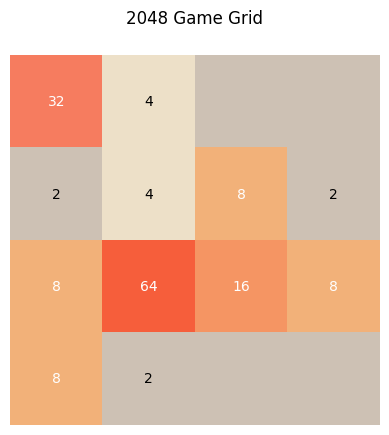

Score to beat: 6000
Dorment model score: 412.0


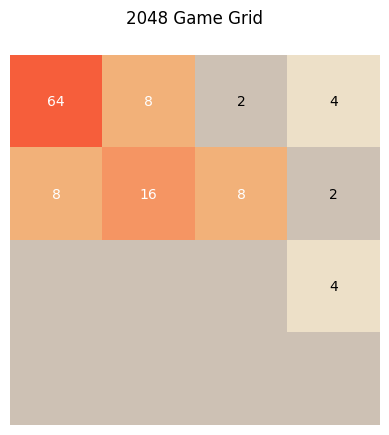

Score to beat: 6000
Dorment model score: 335.7


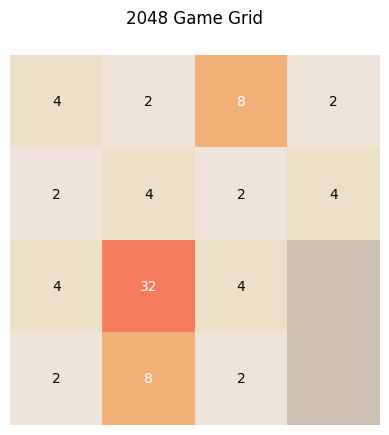

Score to beat: 6000
Dorment model score: 163.1


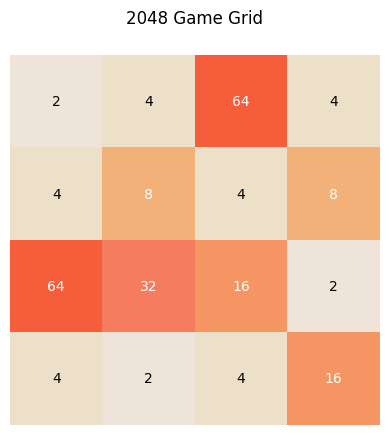

Score to beat: 6000
Dorment model score: 645.7


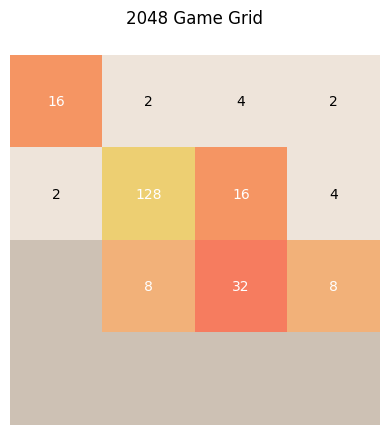

Score to beat: 6000
Dorment model score: 692.9


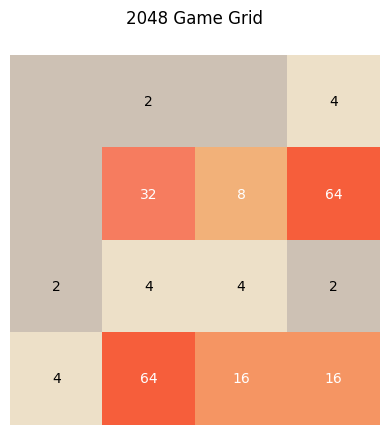

Score to beat: 6000
Dorment model score: 665.2


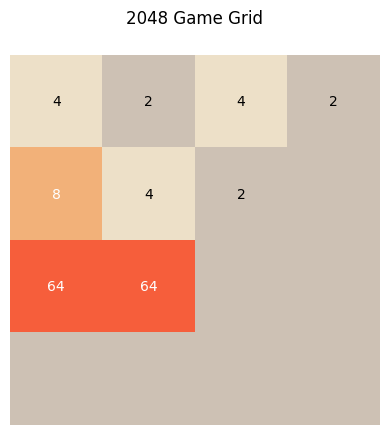

Score to beat: 6000
Dorment model score: 439.3


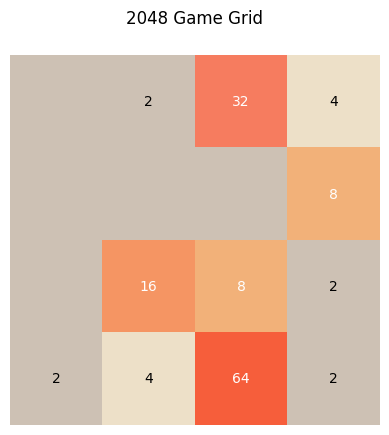

Score to beat: 6000
Dorment model score: 386.6


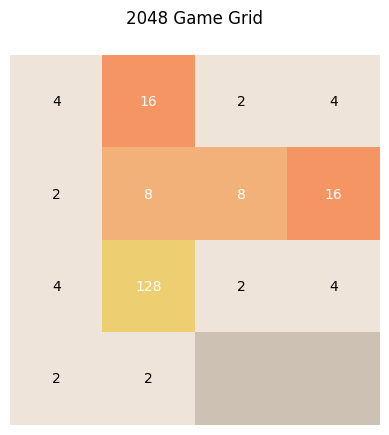

Score to beat: 6000
Dorment model score: 640.5


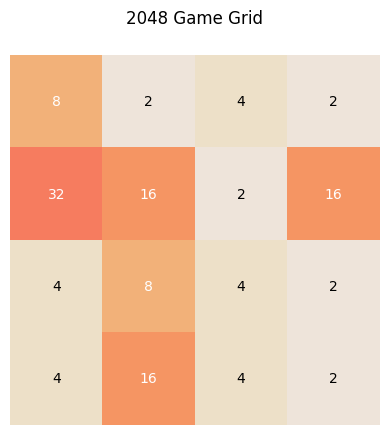

Score to beat: 6000
Dorment model score: 274.7


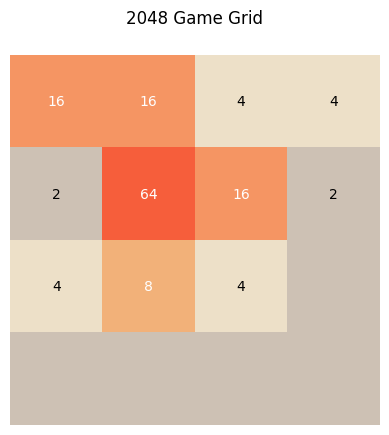

Score to beat: 6000
Dorment model score: 428.09999999999997


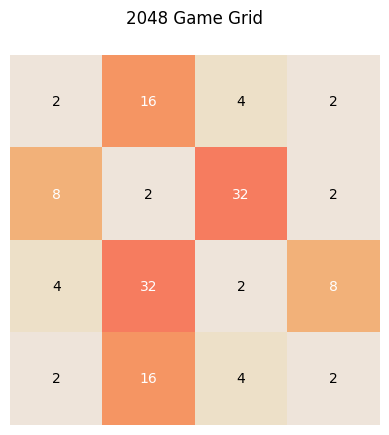

Score to beat: 6000
Dorment model score: 367.4


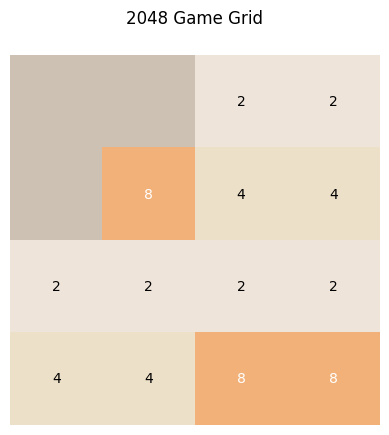

Score to beat: 6000
Dorment model score: 52.199999999999996


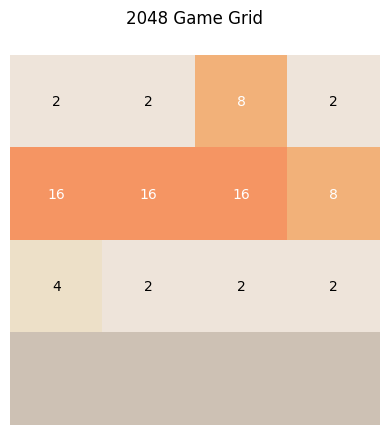

Score to beat: 6000
Dorment model score: 141.1


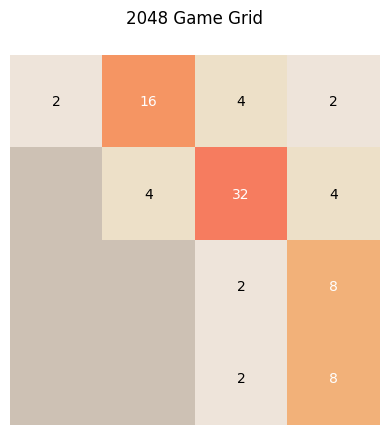

Score to beat: 6000
Dorment model score: 192.8


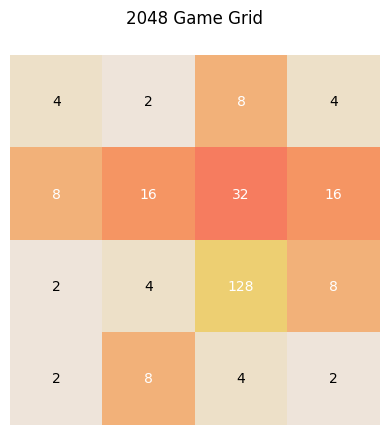

Score to beat: 6000
Dorment model score: 757.4999999999999


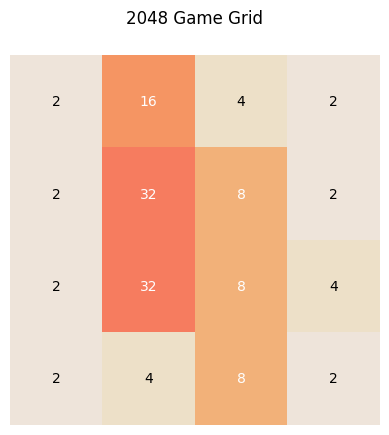

Score to beat: 6000
Dorment model score: 332.0


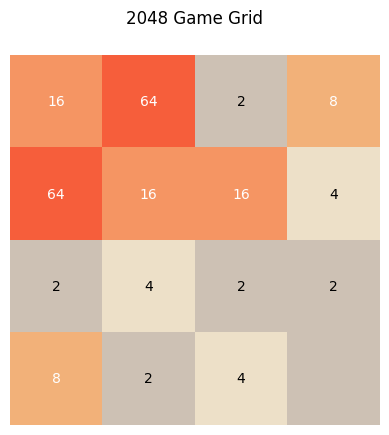

Score to beat: 6000
Dorment model score: 607.7


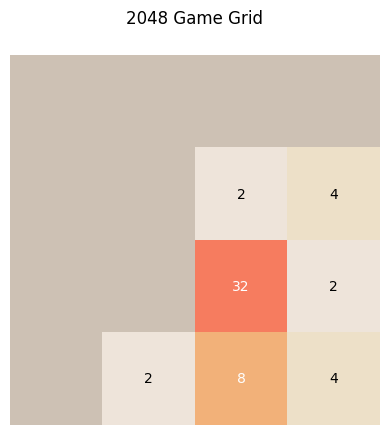

Score to beat: 6000
Dorment model score: 115.70000000000002


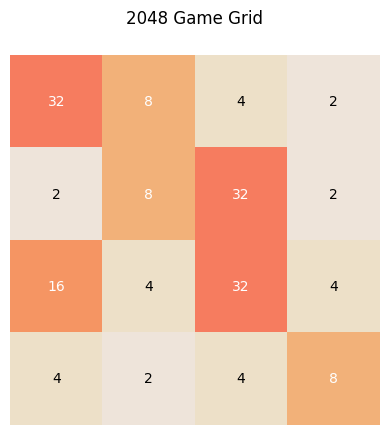

Score to beat: 6000
Dorment model score: 379.5


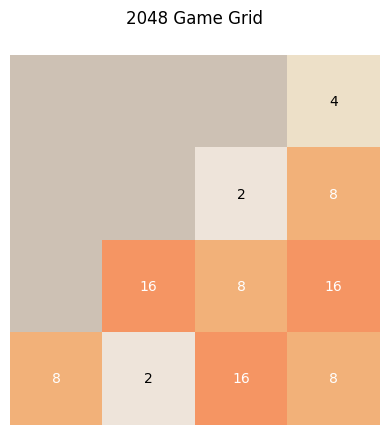

Score to beat: 6000
Dorment model score: 176.3


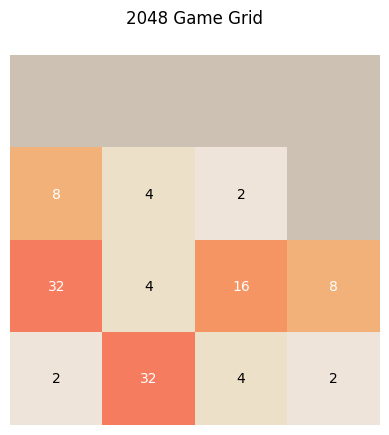

Score to beat: 6000
Dorment model score: 271.9


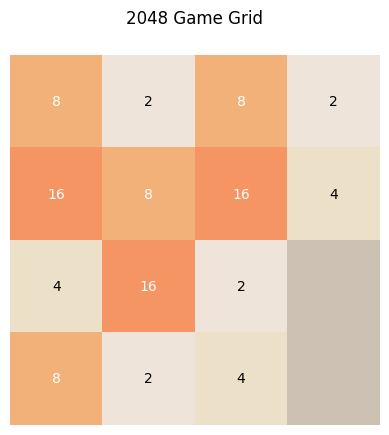

Score to beat: 6000
Dorment model score: 220.0


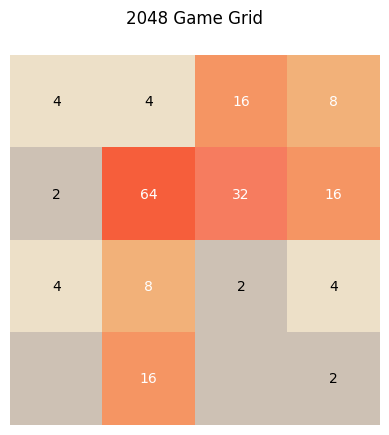

Score to beat: 6000
Dorment model score: 538.8


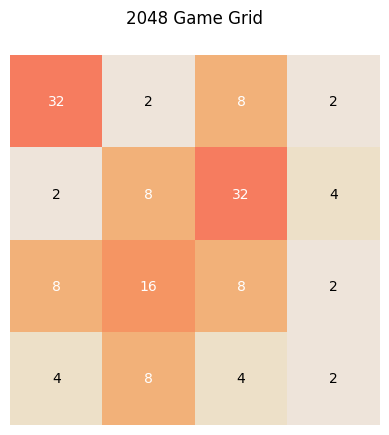

Score to beat: 6000
Dorment model score: 415.0


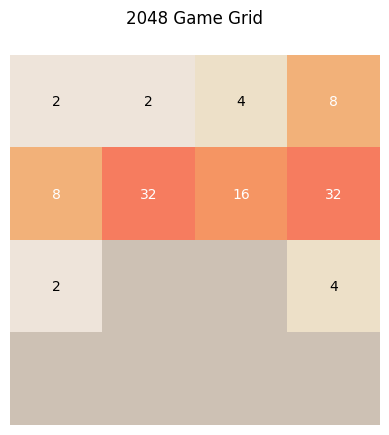

Score to beat: 6000
Dorment model score: 285.79999999999995


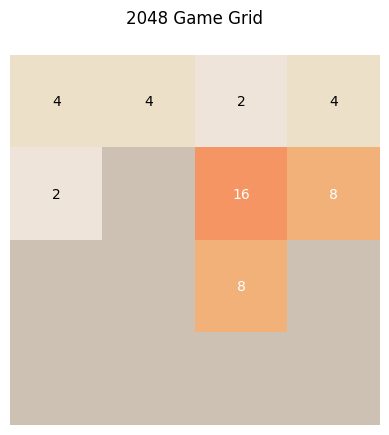

Score to beat: 6000
Dorment model score: 83.0


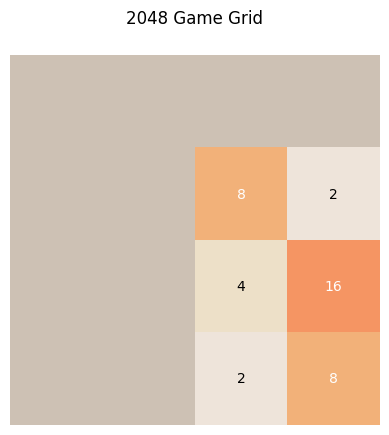

Score to beat: 6000
Dorment model score: 53.3


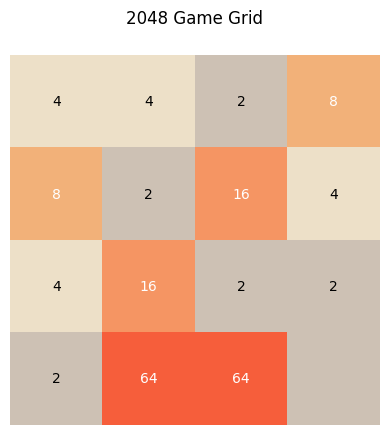

Score to beat: 6000
Dorment model score: 581.4


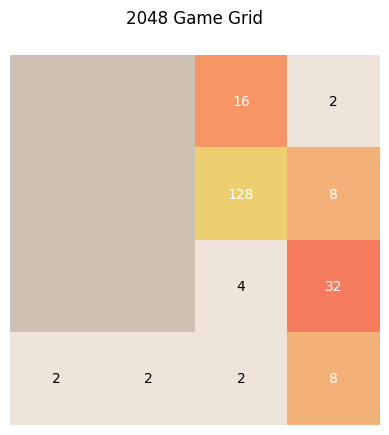

Score to beat: 6000
Dorment model score: 588.0


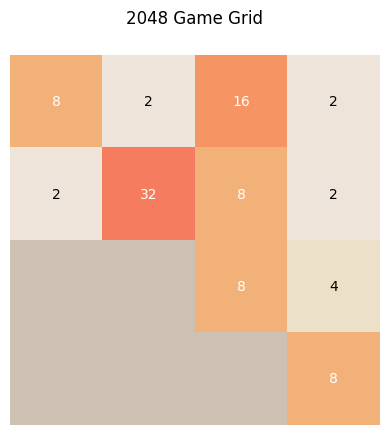

Score to beat: 6000
Dorment model score: 202.6


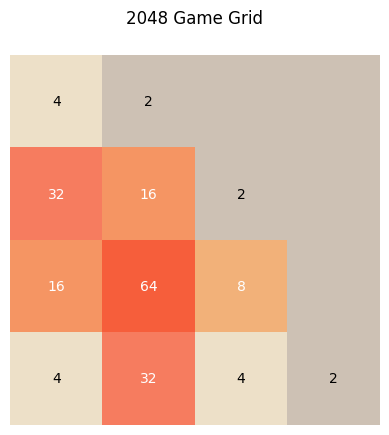

Score to beat: 6000
Dorment model score: 553.1999999999999


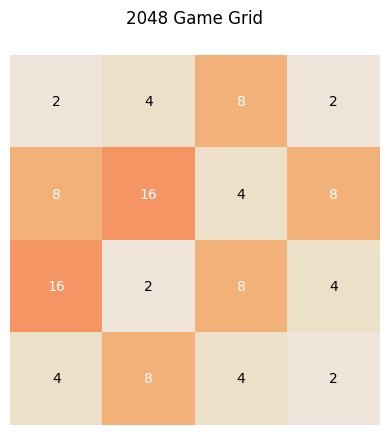

Score to beat: 6000
Dorment model score: 249.2


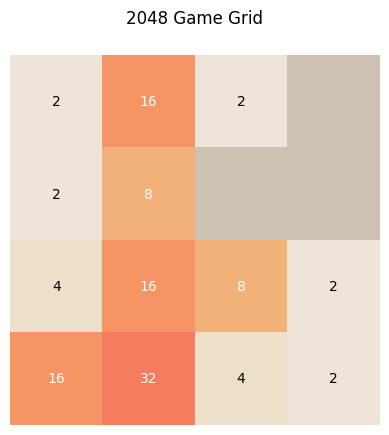

Score to beat: 6000
Dorment model score: 278.30000000000007


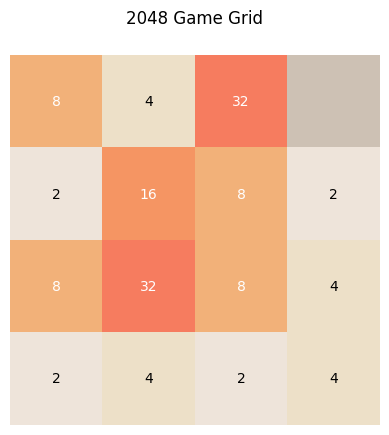

Score to beat: 6000
Dorment model score: 318.2


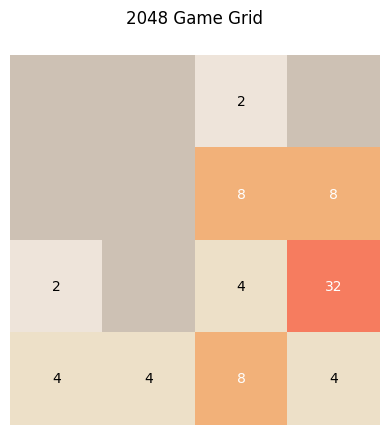

Score to beat: 6000
Dorment model score: 174.8


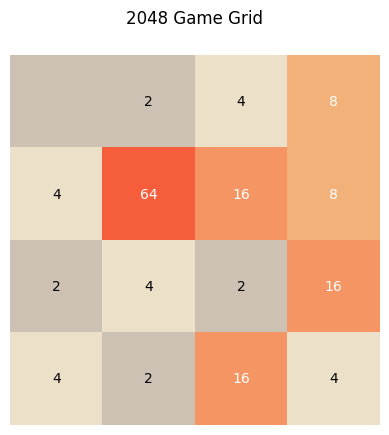

Score to beat: 6000
Dorment model score: 432.90000000000003


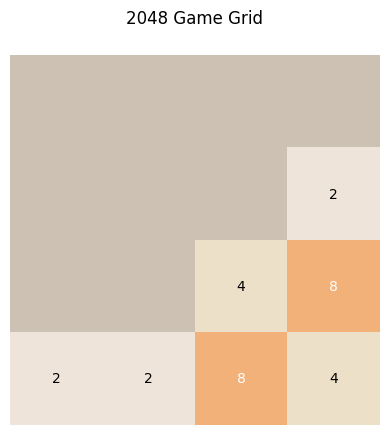

Score to beat: 6000
Dorment model score: 21.700000000000003


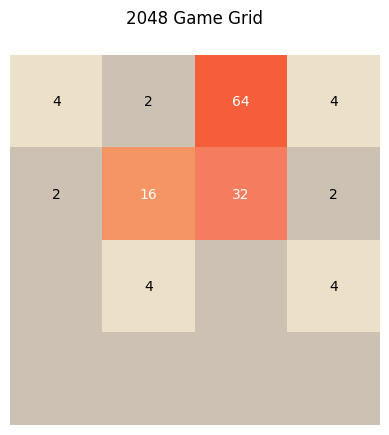

Score to beat: 6000
Dorment model score: 317.6


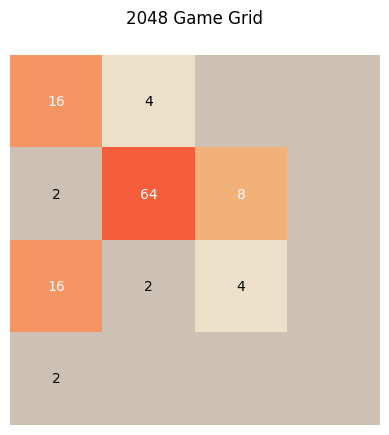

Score to beat: 6000
Dorment model score: 373.3999999999999


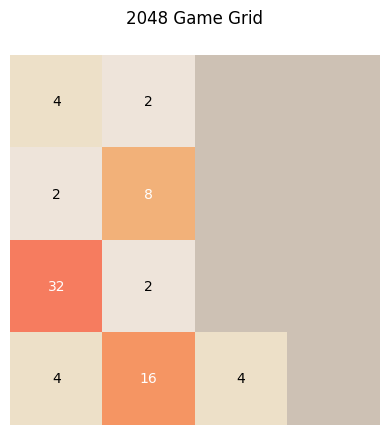

Score to beat: 6000
Dorment model score: 161.20000000000002


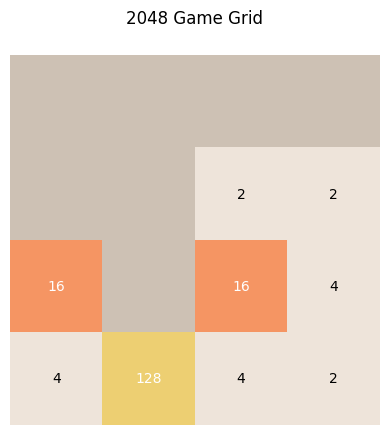

Score to beat: 6000
Dorment model score: 578.4999999999998


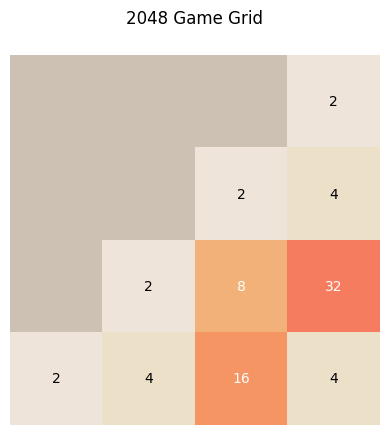

Score to beat: 6000
Dorment model score: 150.39999999999998


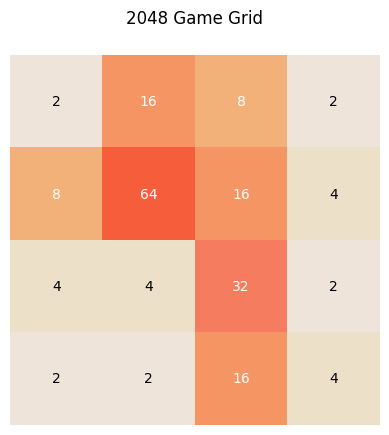

Score to beat: 6000
Dorment model score: 528.3000000000001


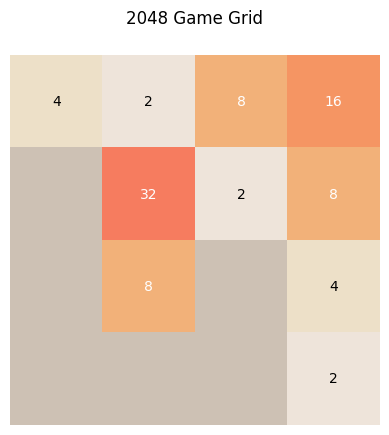

Score to beat: 6000
Dorment model score: 192.0


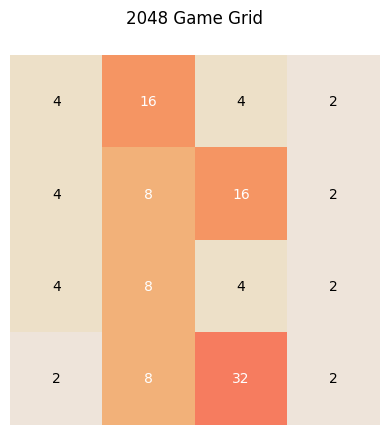

Score to beat: 6000
Dorment model score: 273.79999999999995


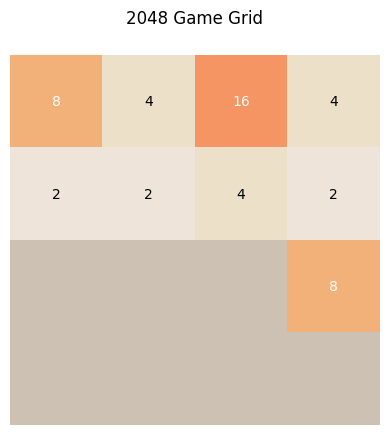

Score to beat: 6000
Dorment model score: 96.0


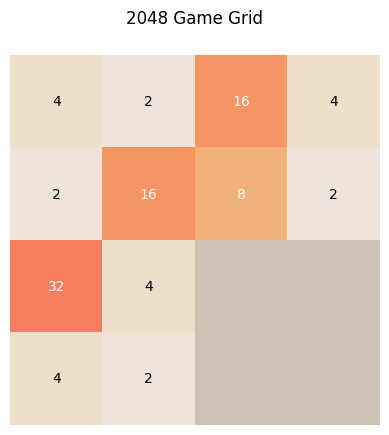

Score to beat: 6000
Dorment model score: 224.09999999999997


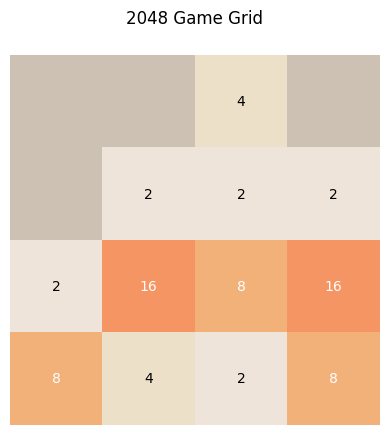

Score to beat: 6000
Dorment model score: 121.19999999999999


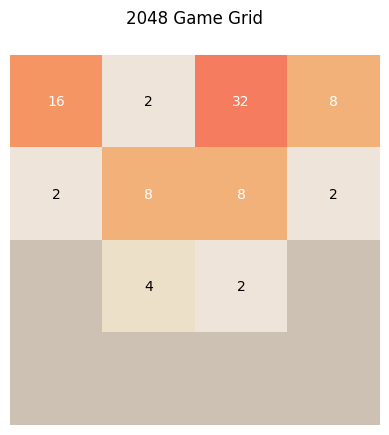

Score to beat: 6000
Dorment model score: 145.4


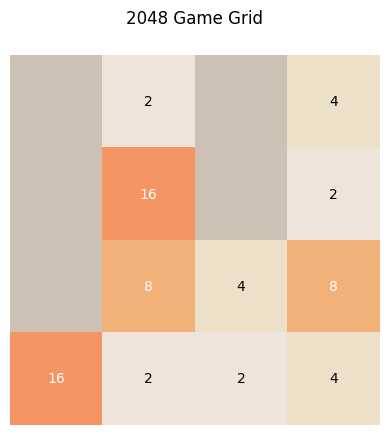

Score to beat: 6000
Dorment model score: 108.1


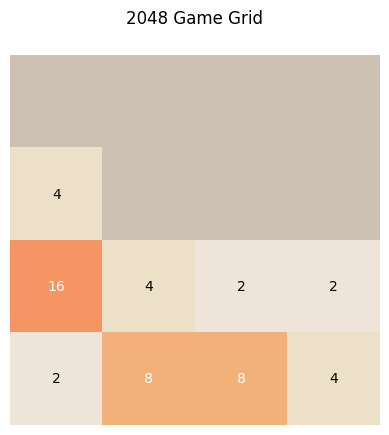

Score to beat: 6000
Dorment model score: 90.80000000000001


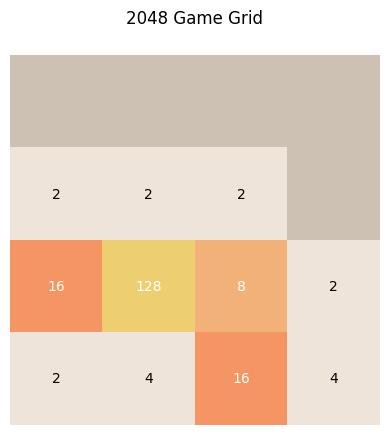

Score to beat: 6000
Dorment model score: 595.8


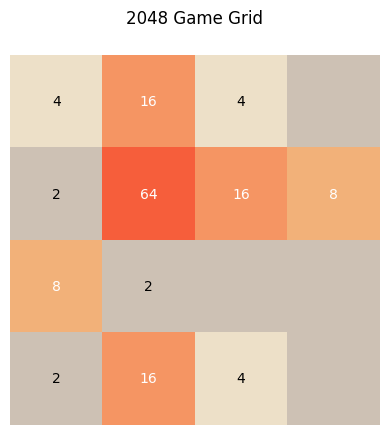

Score to beat: 6000
Dorment model score: 347.79999999999995


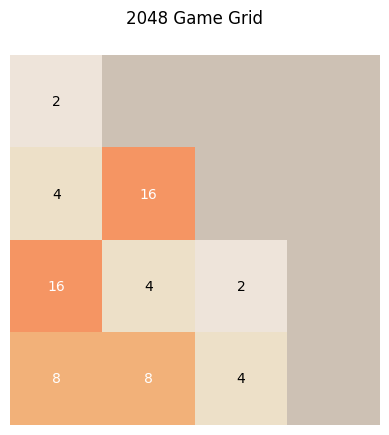

Score to beat: 6000
Dorment model score: 145.7


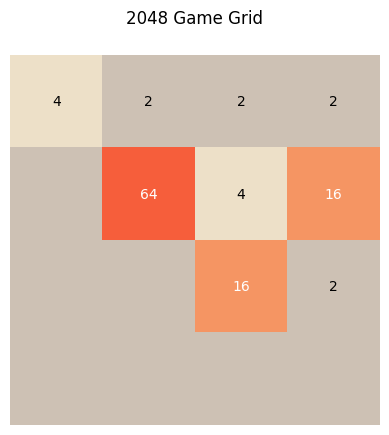

Score to beat: 6000
Dorment model score: 298.4


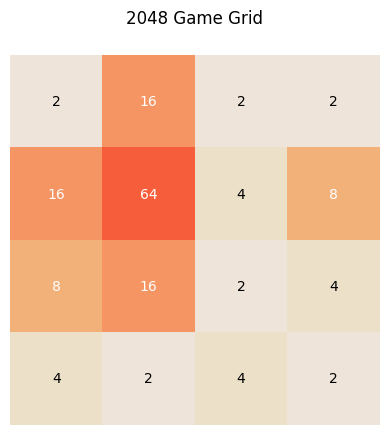

Score to beat: 6000
Dorment model score: 385.49999999999994


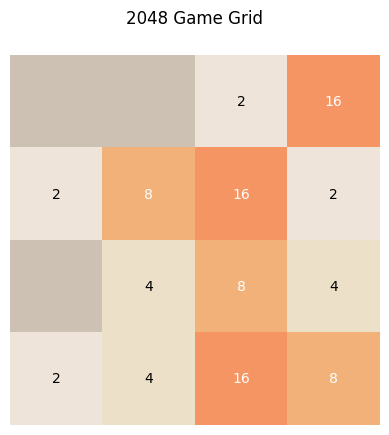

Score to beat: 6000
Dorment model score: 178.7


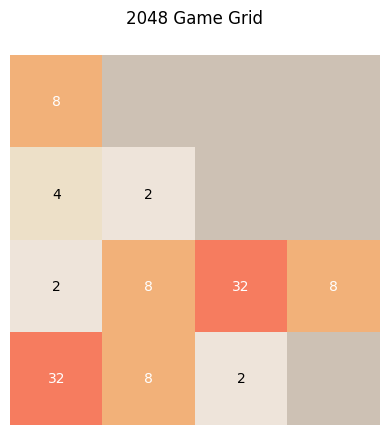

Score to beat: 6000
Dorment model score: 257.59999999999997


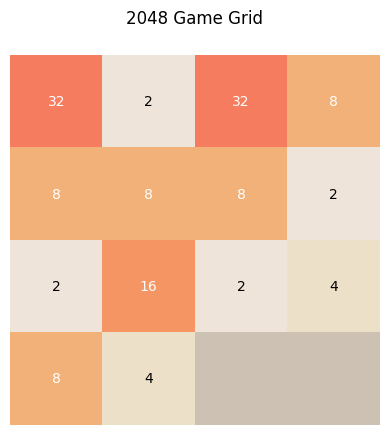

Score to beat: 6000
Dorment model score: 329.0


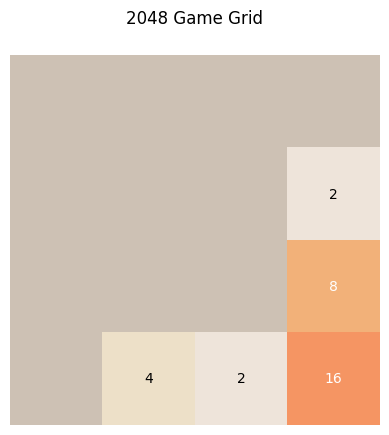

Score to beat: 6000
Dorment model score: 39.69999999999999


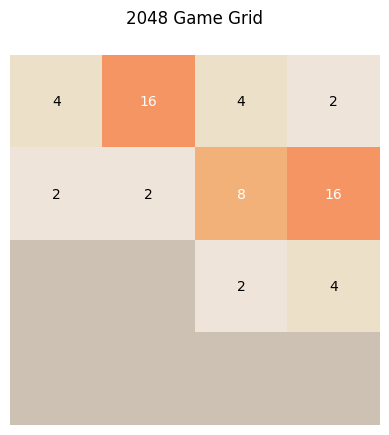

Score to beat: 6000
Dorment model score: 91.19999999999999


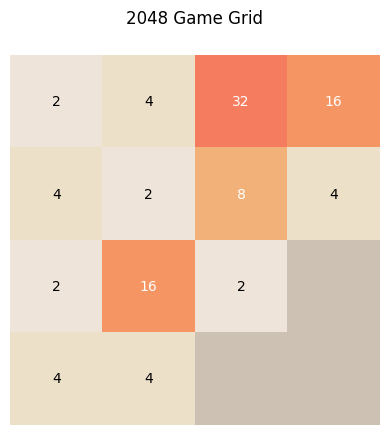

Score to beat: 6000
Dorment model score: 233.39999999999998


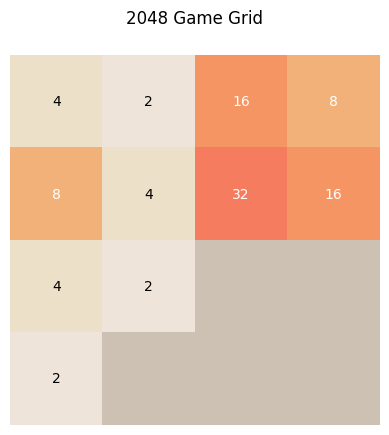

Score to beat: 6000
Dorment model score: 214.10000000000002


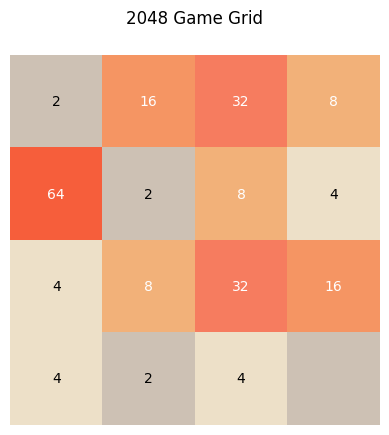

Score to beat: 6000
Dorment model score: 633.4


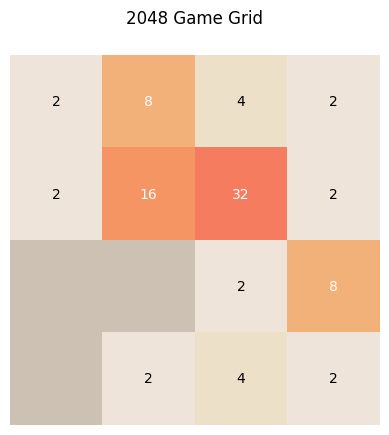

Score to beat: 6000
Dorment model score: 194.3


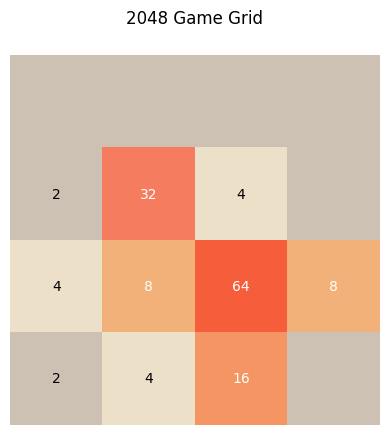

Score to beat: 6000
Dorment model score: 424.59999999999997


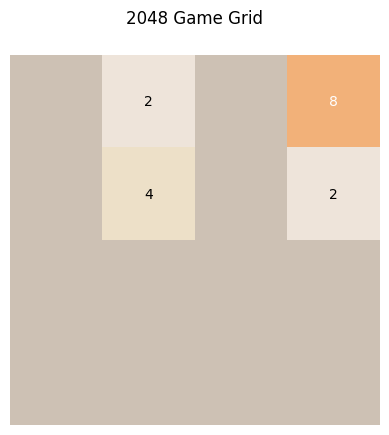

Score to beat: 6000
Dorment model score: -17.7


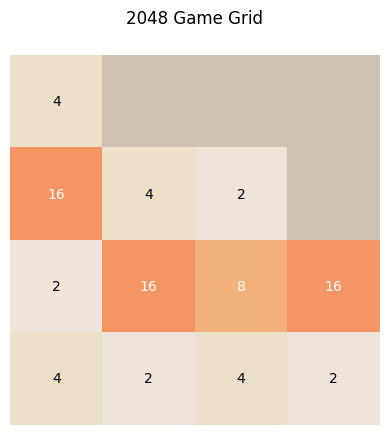

Score to beat: 6000
Dorment model score: 161.7


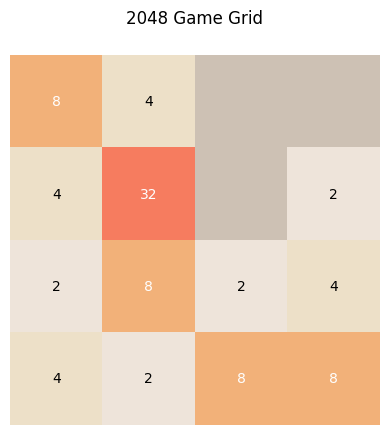

Score to beat: 6000
Dorment model score: 180.39999999999998


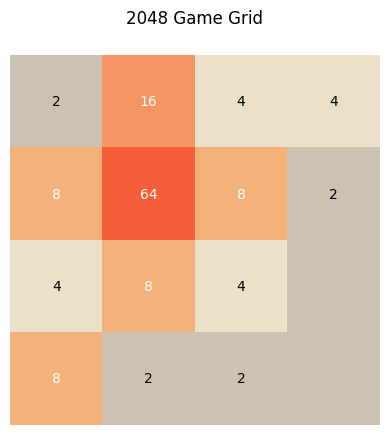

Score to beat: 6000
Dorment model score: 347.9


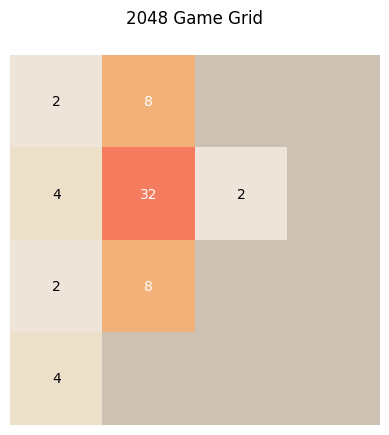

Score to beat: 6000
Dorment model score: 115.5


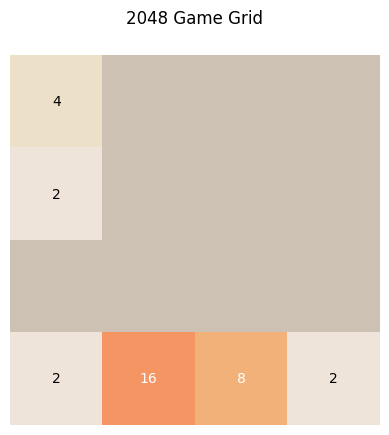

Score to beat: 6000
Dorment model score: 48.69999999999999


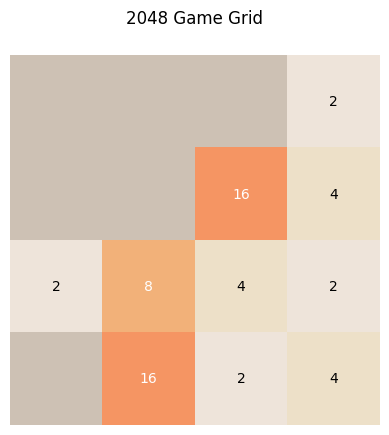

Score to beat: 6000
Dorment model score: 108.0


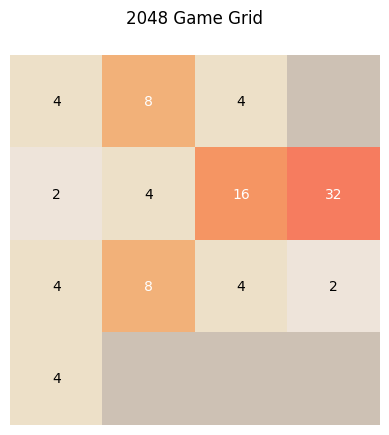

Score to beat: 6000
Dorment model score: 219.89999999999998


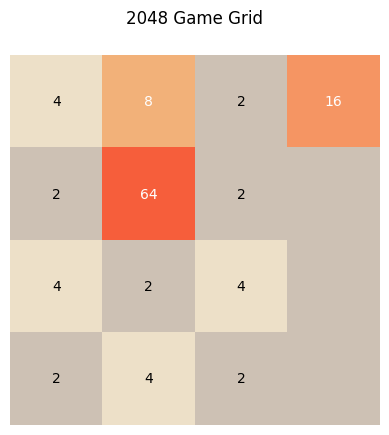

Score to beat: 6000
Dorment model score: 277.4


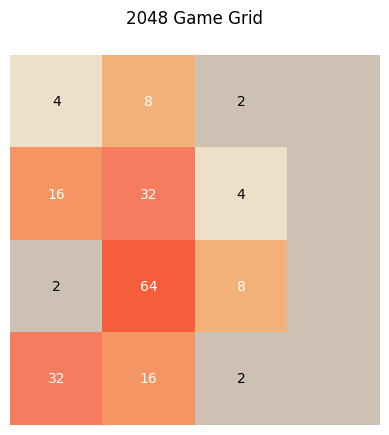

Score to beat: 6000
Dorment model score: 604.1999999999999


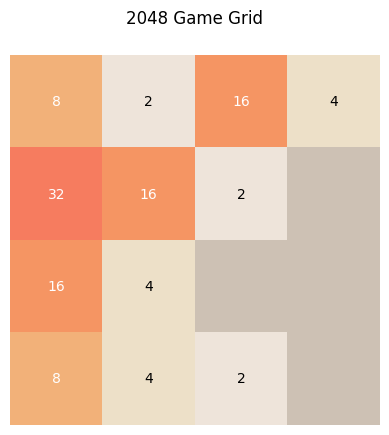

Score to beat: 6000
Dorment model score: 264.6


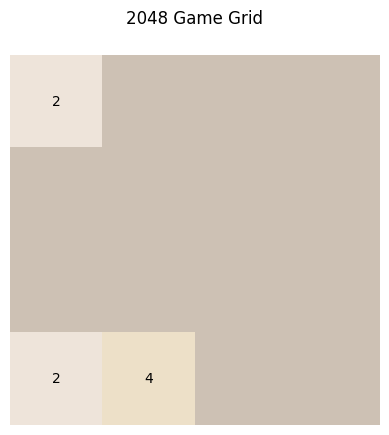

Score to beat: 6000
Dorment model score: -39.0


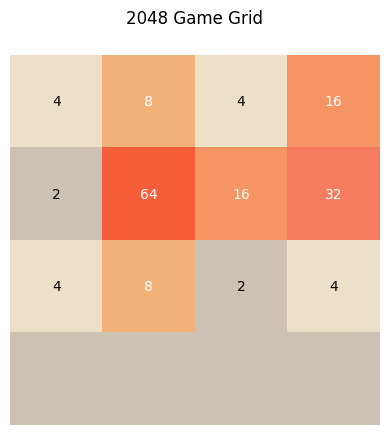

Score to beat: 6000
Dorment model score: 445.6


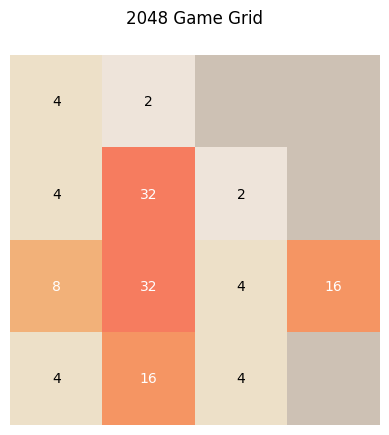

Score to beat: 6000
Dorment model score: 319.5


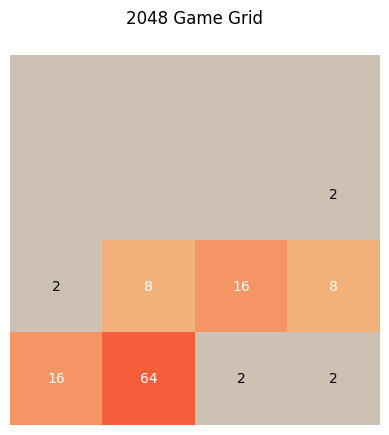

Score to beat: 6000
Dorment model score: 345.40000000000003


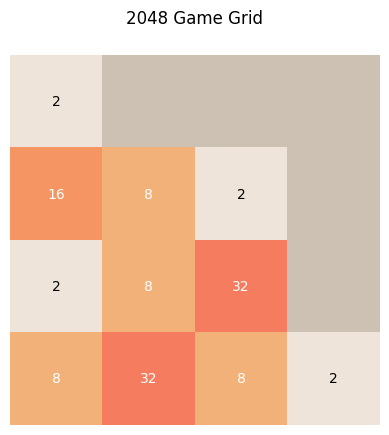

Score to beat: 6000
Dorment model score: 324.9


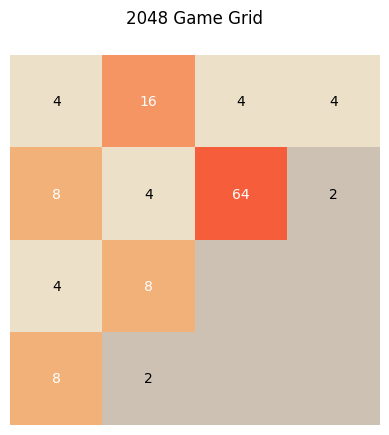

Score to beat: 6000
Dorment model score: 330.4


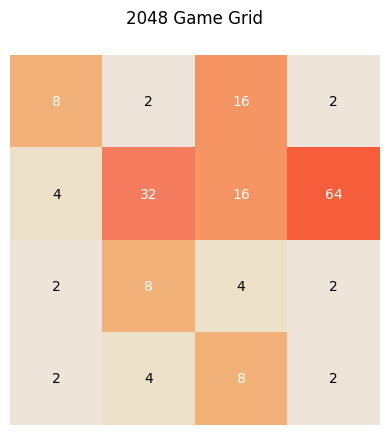

Score to beat: 6000
Dorment model score: 510.70000000000005


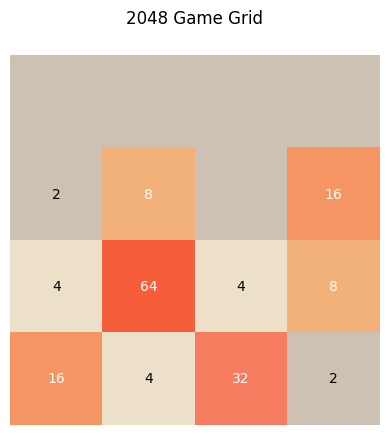

Score to beat: 6000
Dorment model score: 515.2


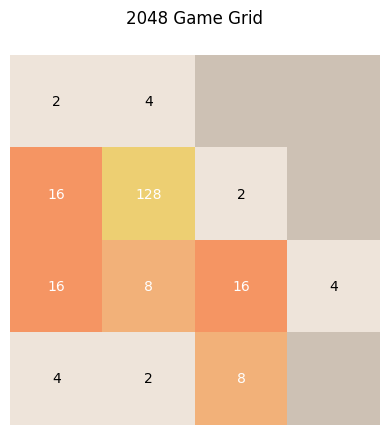

Score to beat: 6000
Dorment model score: 661.0999999999999


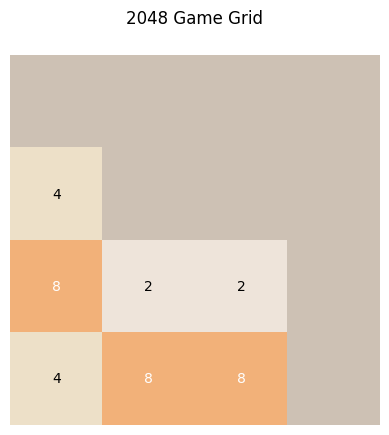

Score to beat: 6000
Dorment model score: 39.599999999999994


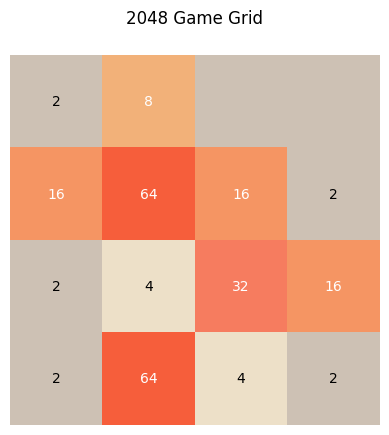

Score to beat: 6000
Dorment model score: 791.4


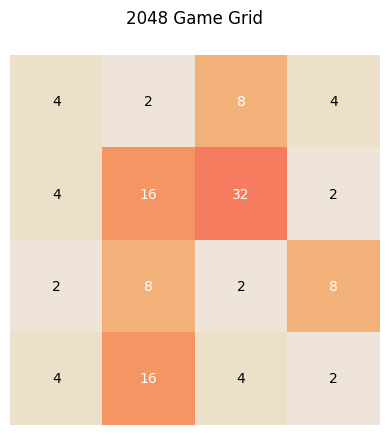

Score to beat: 6000
Dorment model score: 306.4


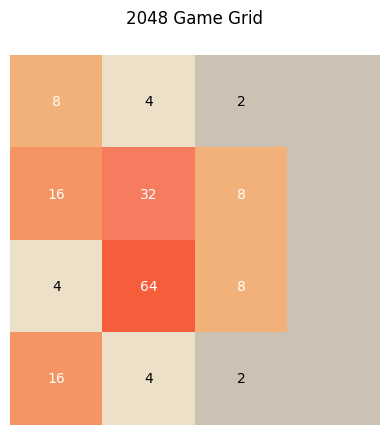

Score to beat: 6000
Dorment model score: 542.3999999999999


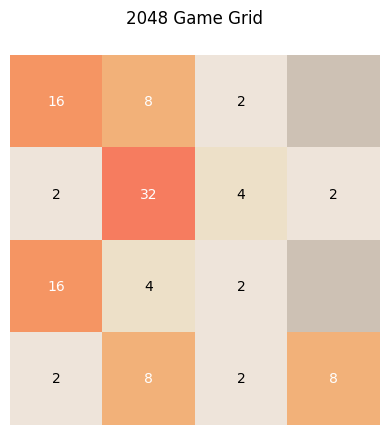

Score to beat: 6000
Dorment model score: 277.0


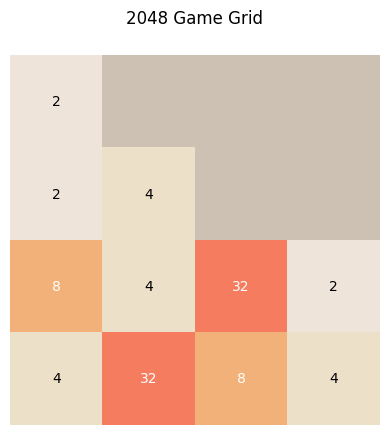

Score to beat: 6000
Dorment model score: 257.0


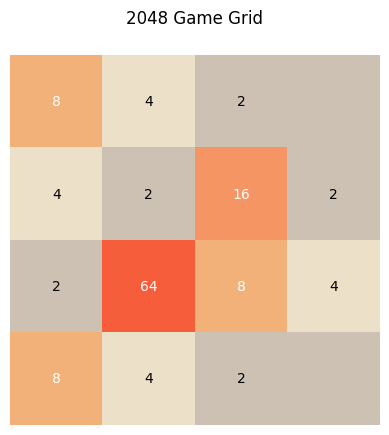

Score to beat: 6000
Dorment model score: 366.49999999999994


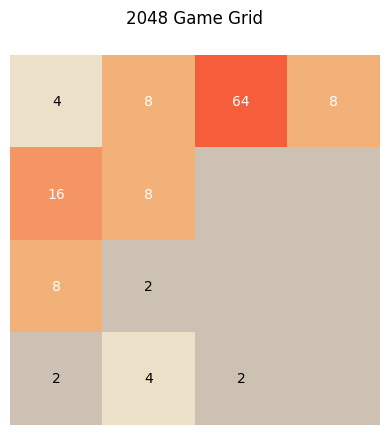

Score to beat: 6000
Dorment model score: 356.9


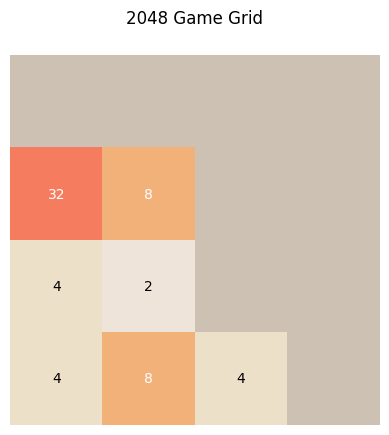

Score to beat: 6000
Dorment model score: 133.99999999999997


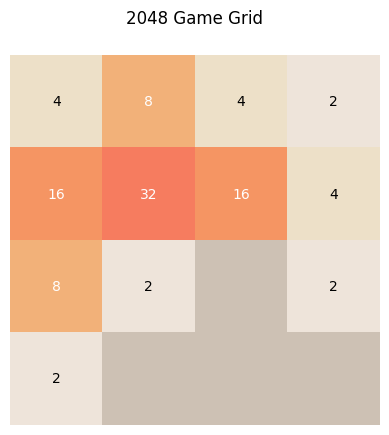

Score to beat: 6000
Dorment model score: 252.7


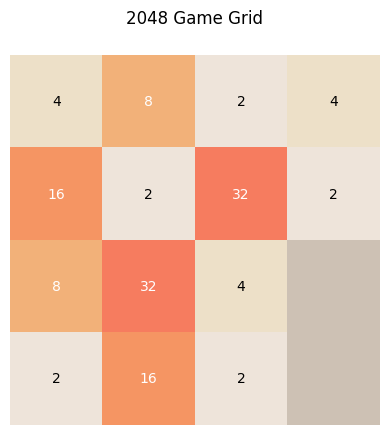

Score to beat: 6000
Dorment model score: 352.9


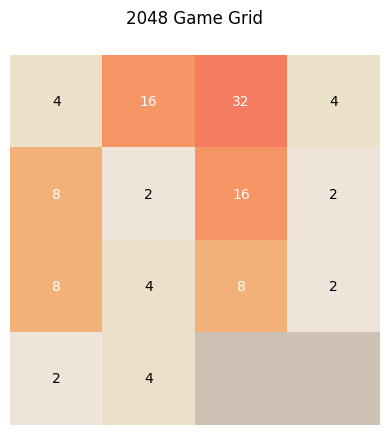

Score to beat: 6000
Dorment model score: 304.59999999999997


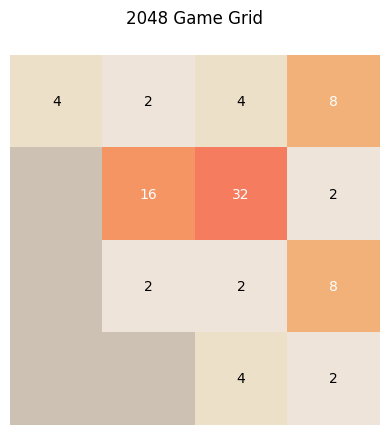

Score to beat: 6000
Dorment model score: 188.0


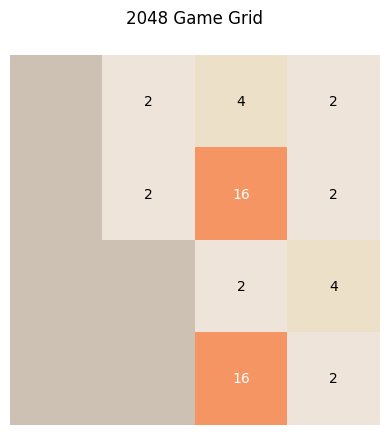

Score to beat: 6000
Dorment model score: 73.2


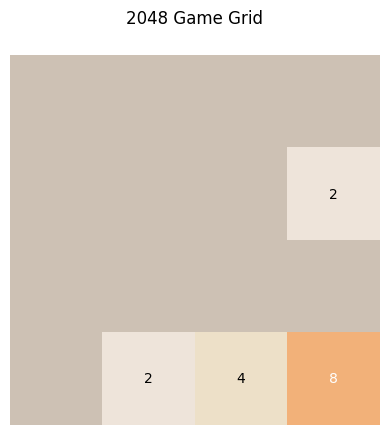

Score to beat: 6000
Dorment model score: -3.3999999999999986


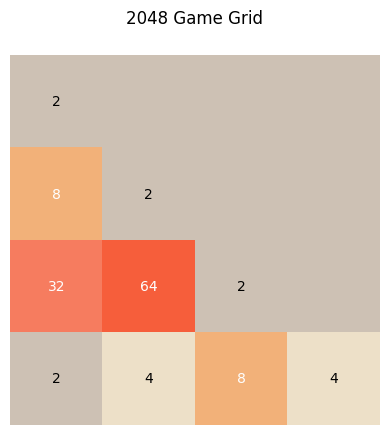

Score to beat: 6000
Dorment model score: 354.3


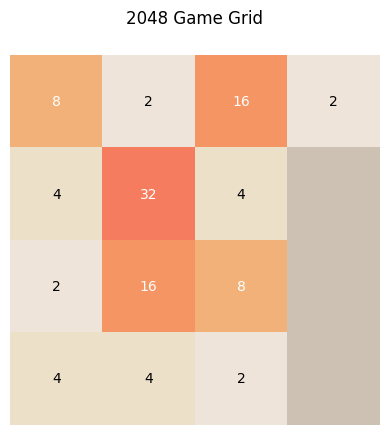

Score to beat: 6000
Dorment model score: 232.39999999999998


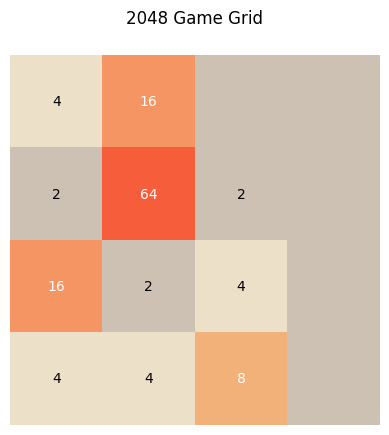

Score to beat: 6000
Dorment model score: 342.0


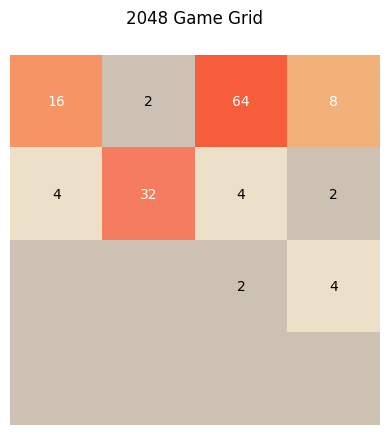

Score to beat: 6000
Dorment model score: 427.6


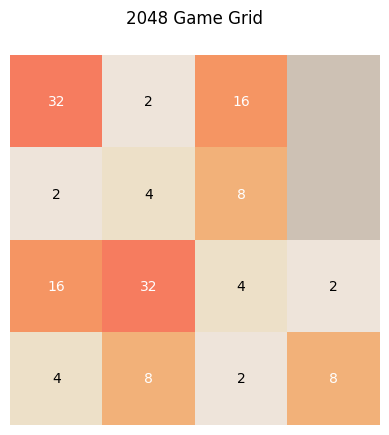

Score to beat: 6000
Dorment model score: 338.8


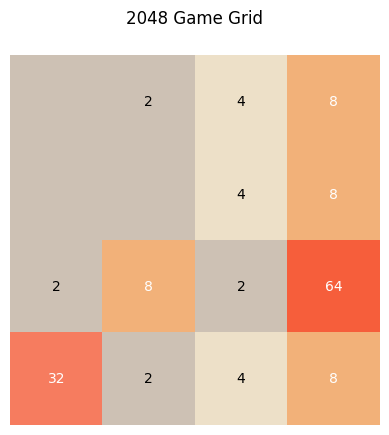

Score to beat: 6000
Dorment model score: 416.00000000000006


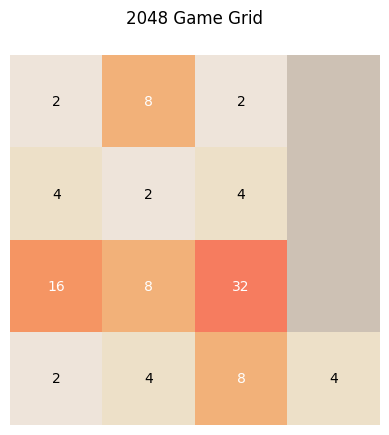

Score to beat: 6000
Dorment model score: 275.3


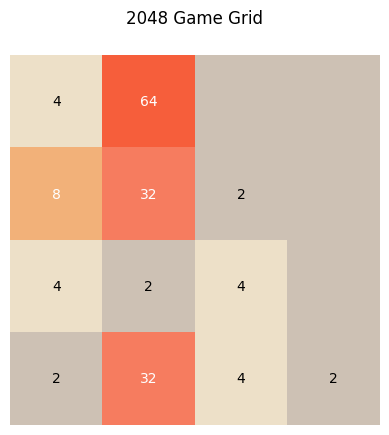

Score to beat: 6000
Dorment model score: 468.79999999999995


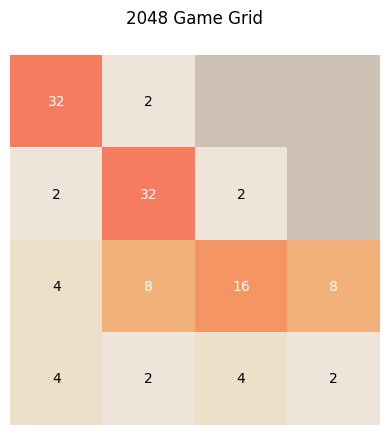

Score to beat: 6000
Dorment model score: 285.1


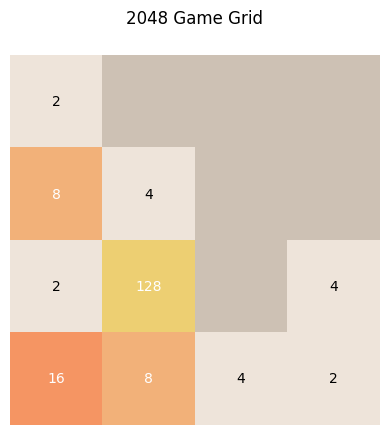

Score to beat: 6000
Dorment model score: 568.8


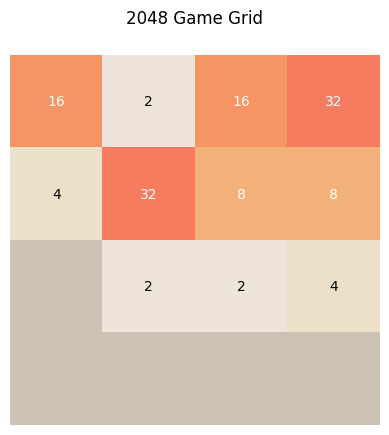

Score to beat: 6000
Dorment model score: 331.90000000000003


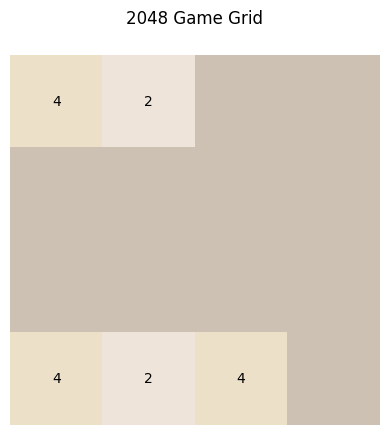

Score to beat: 6000
Dorment model score: -28.5


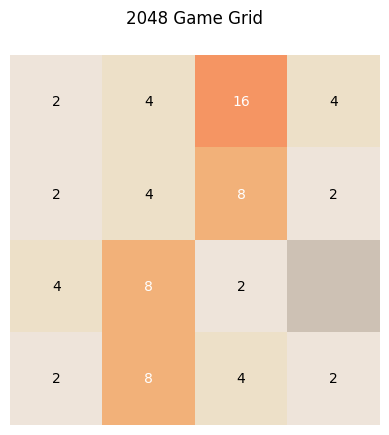

Score to beat: 6000
Dorment model score: 140.10000000000002


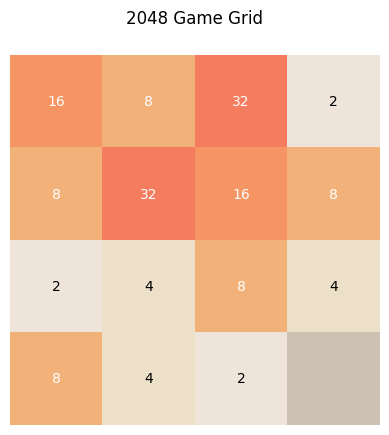

Score to beat: 6000
Dorment model score: 442.0


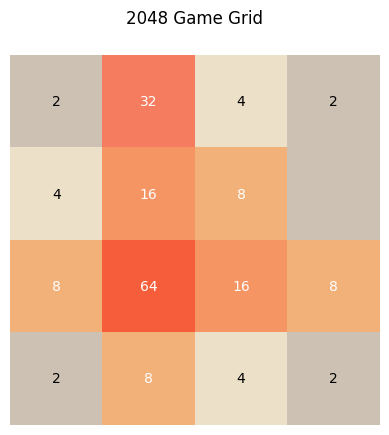

Score to beat: 6000
Dorment model score: 557.9000000000001


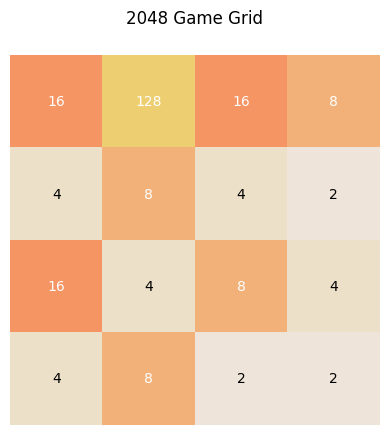

Score to beat: 6000
Dorment model score: 690.8000000000001


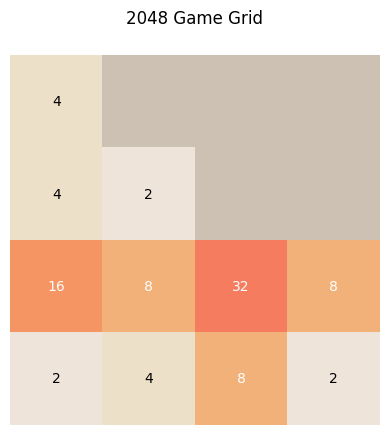

Score to beat: 6000
Dorment model score: 244.39999999999998


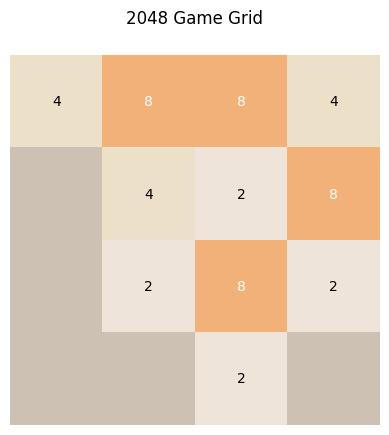

Score to beat: 6000
Dorment model score: 60.7
TARGET UPDATED


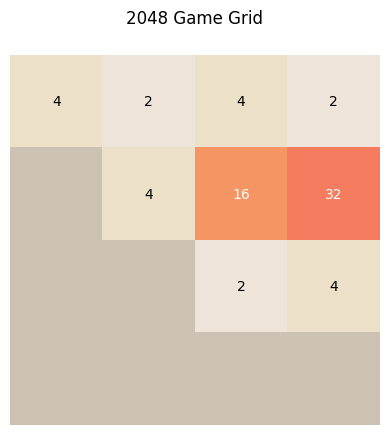

Score to beat: 6000
Dorment model score: 132.5


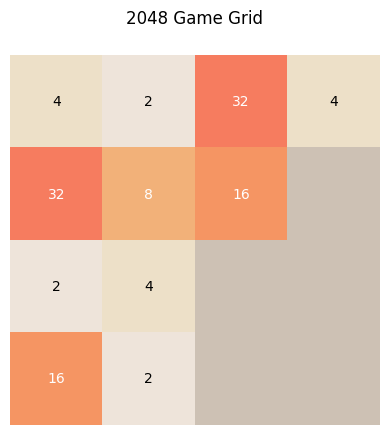

Score to beat: 6000
Dorment model score: 359.5


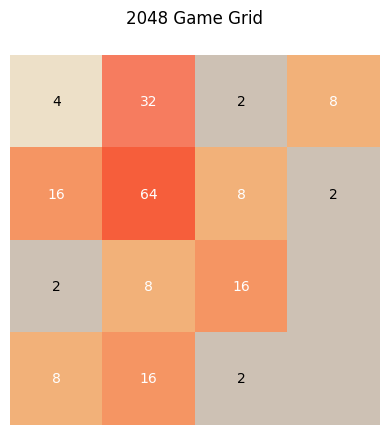

Score to beat: 6000
Dorment model score: 537.3


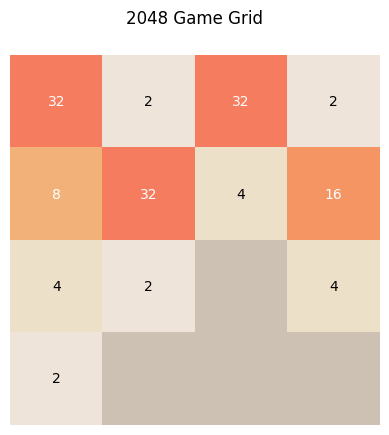

Score to beat: 6000
Dorment model score: 343.8


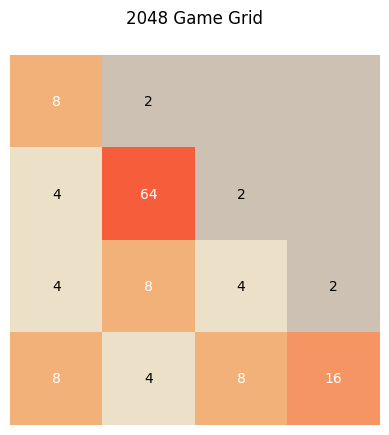

Score to beat: 6000
Dorment model score: 363.6


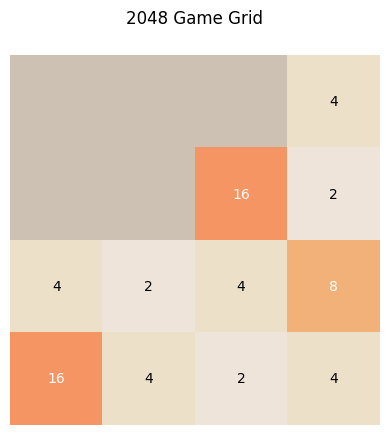

Score to beat: 6000
Dorment model score: 115.1


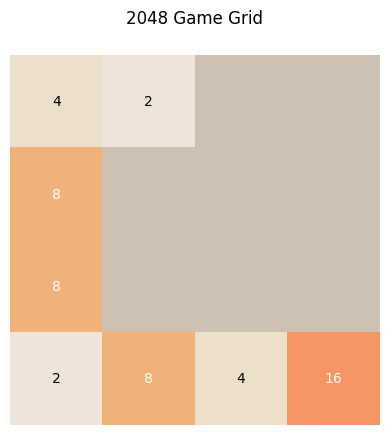

Score to beat: 6000
Dorment model score: 100.0


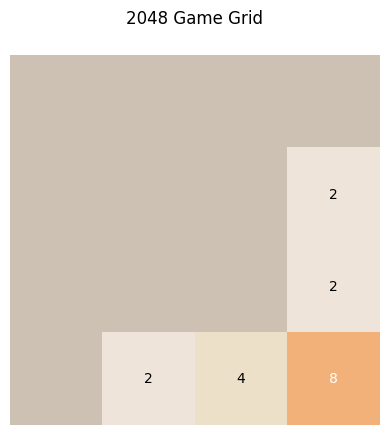

Score to beat: 6000
Dorment model score: -7.299999999999997


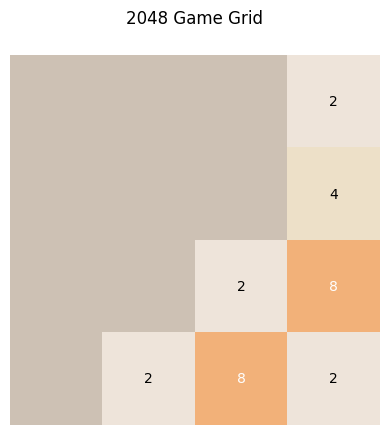

Score to beat: 6000
Dorment model score: 15.600000000000001


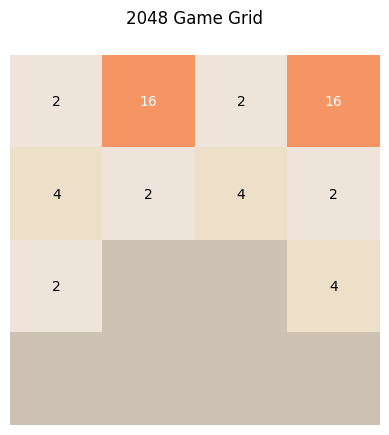

Score to beat: 6000
Dorment model score: 109.19999999999999


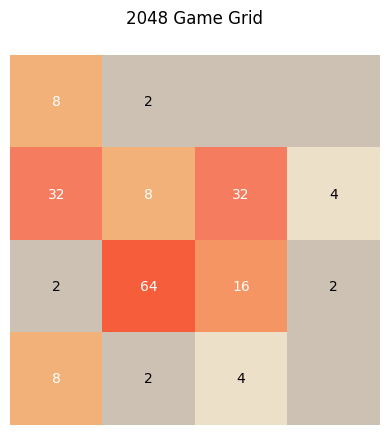

Score to beat: 6000
Dorment model score: 555.0


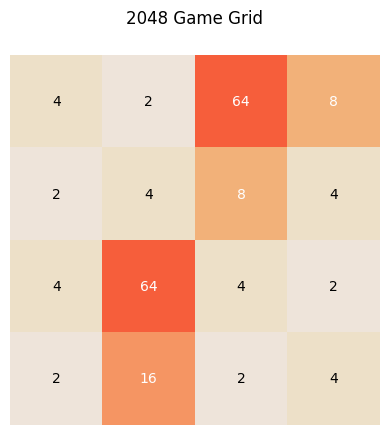

Score to beat: 6000
Dorment model score: 533.5999999999999


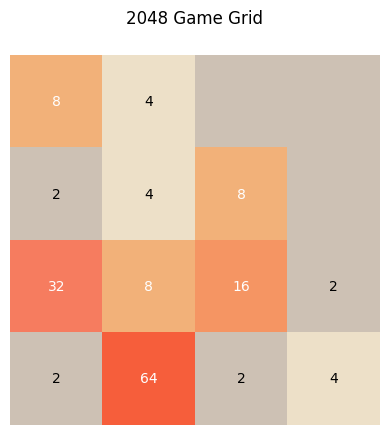

Score to beat: 6000
Dorment model score: 412.79999999999995


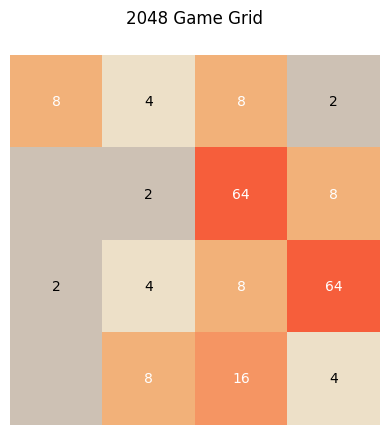

Score to beat: 6000
Dorment model score: 590.0


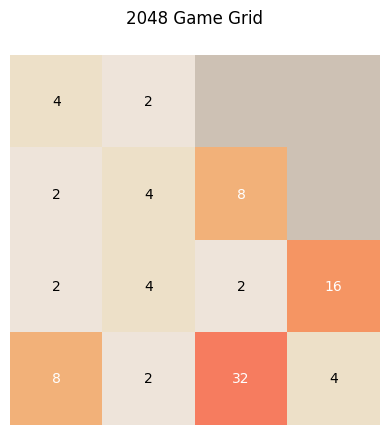

Score to beat: 6000
Dorment model score: 227.7


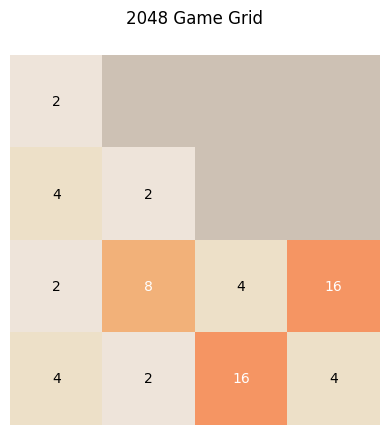

Score to beat: 6000
Dorment model score: 98.4


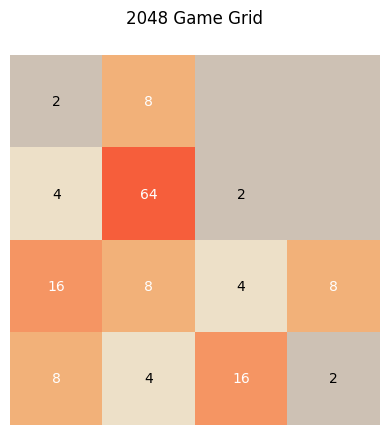

Score to beat: 6000
Dorment model score: 408.2


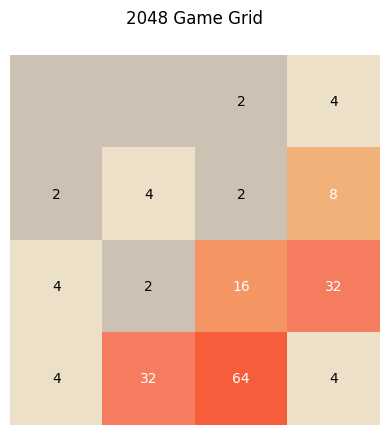

Score to beat: 6000
Dorment model score: 497.4000000000001


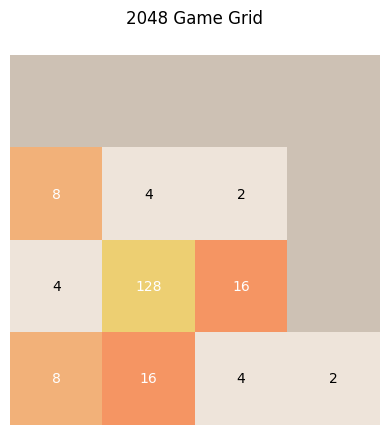

Score to beat: 6000
Dorment model score: 607.1999999999999


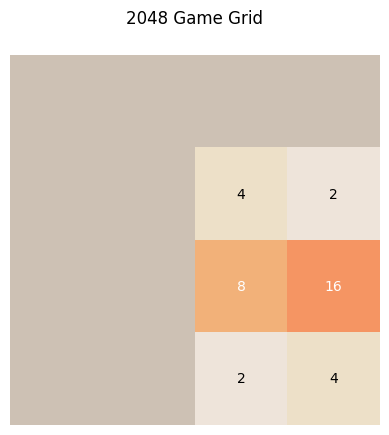

Score to beat: 6000
Dorment model score: 33.8


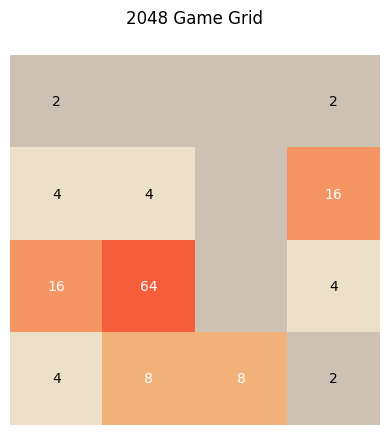

Score to beat: 6000
Dorment model score: 371.59999999999997


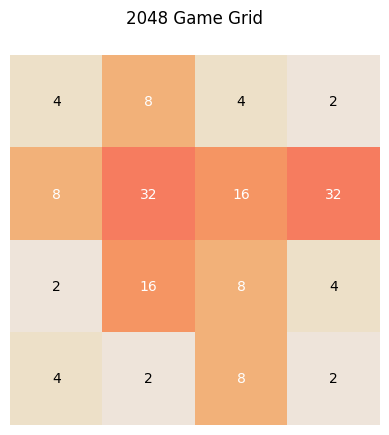

Score to beat: 6000
Dorment model score: 409.3


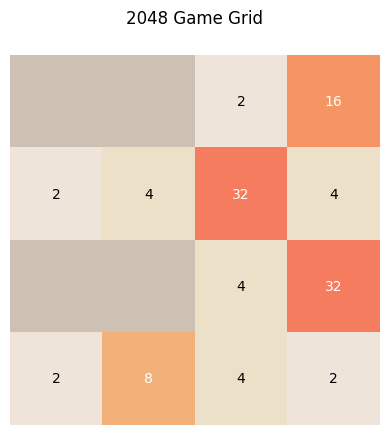

Score to beat: 6000
Dorment model score: 295.70000000000005


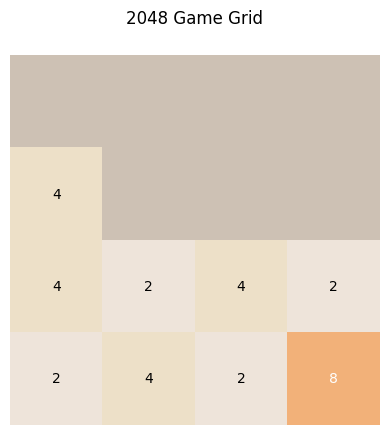

Score to beat: 6000
Dorment model score: 33.2


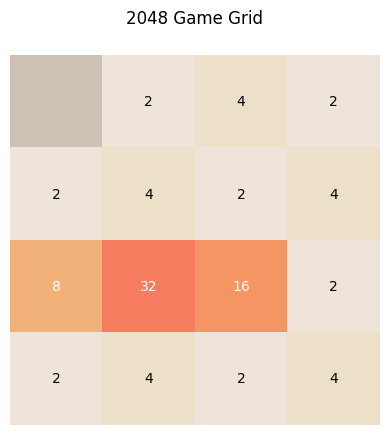

Score to beat: 6000
Dorment model score: 170.9


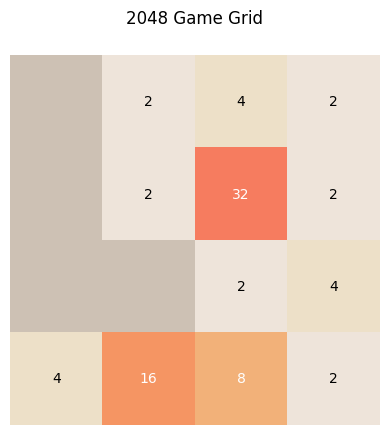

Score to beat: 6000
Dorment model score: 191.89999999999998


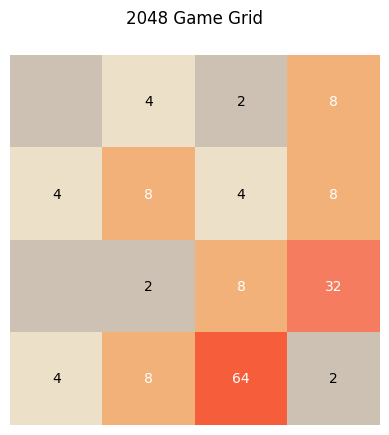

Score to beat: 6000
Dorment model score: 428.2


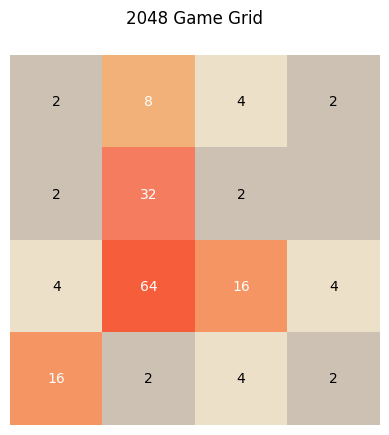

Score to beat: 6000
Dorment model score: 432.19999999999993


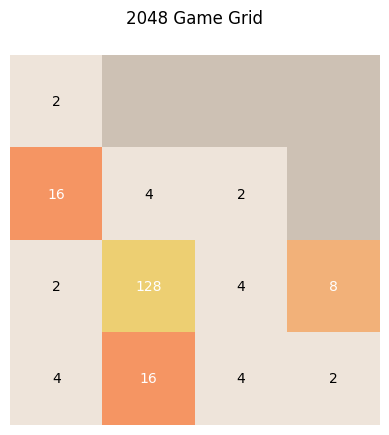

Score to beat: 6000
Dorment model score: 619.9


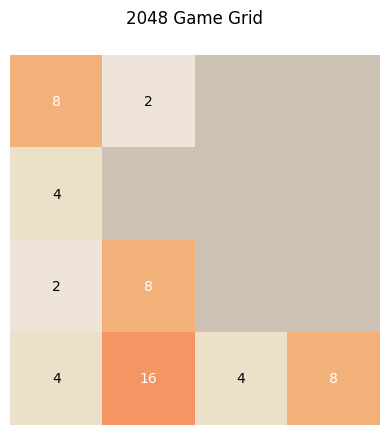

Score to beat: 6000
Dorment model score: 129.5


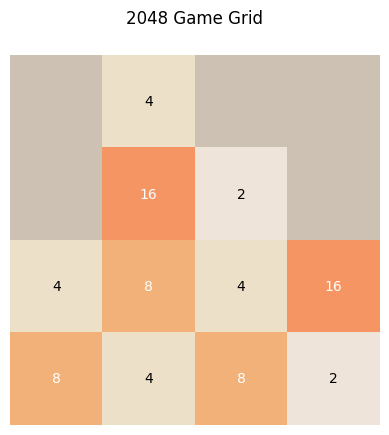

Score to beat: 6000
Dorment model score: 154.8


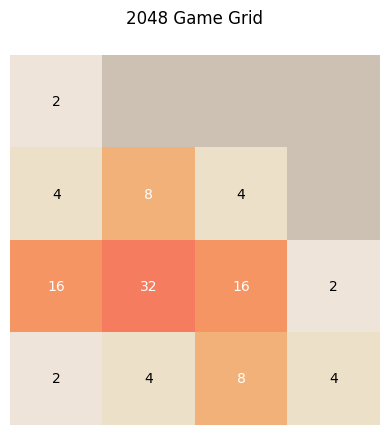

Score to beat: 6000
Dorment model score: 268.9


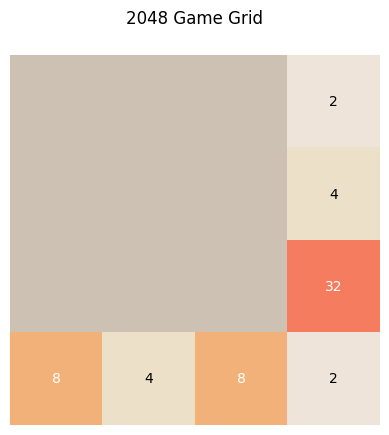

Score to beat: 6000
Dorment model score: 122.69999999999999


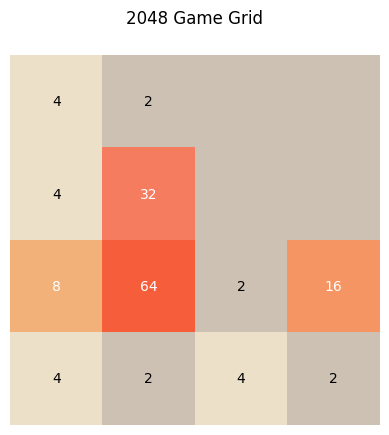

Score to beat: 6000
Dorment model score: 418.20000000000005


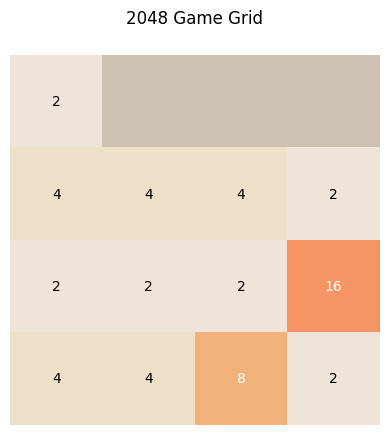

Score to beat: 6000
Dorment model score: 67.1


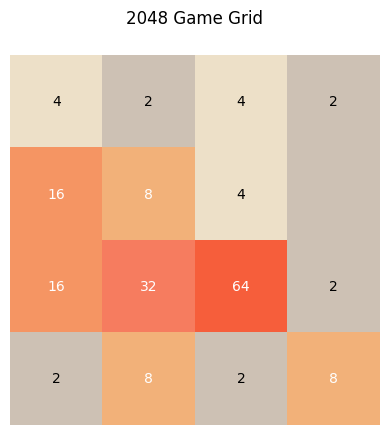

Score to beat: 6000
Dorment model score: 559.8


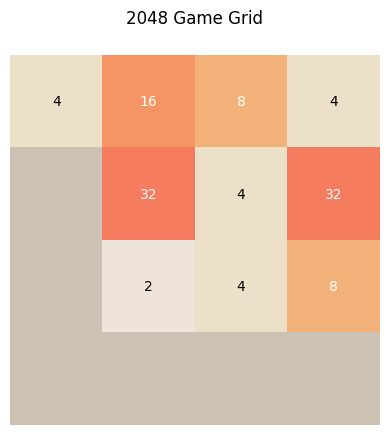

Score to beat: 6000
Dorment model score: 277.19999999999993


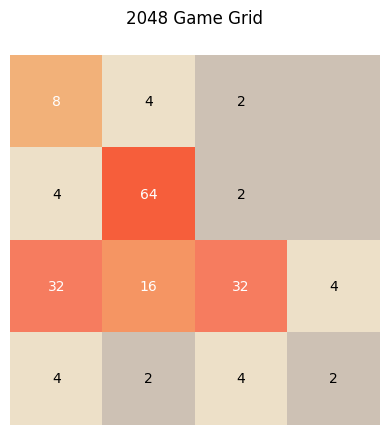

Score to beat: 6000
Dorment model score: 526.9


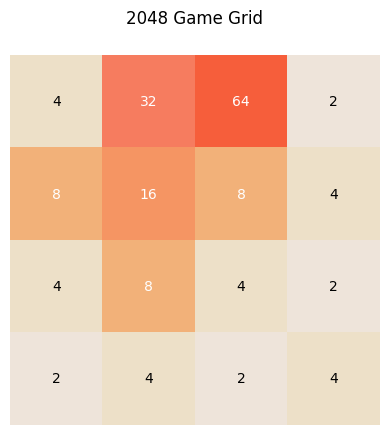

Score to beat: 6000
Dorment model score: 494.20000000000005


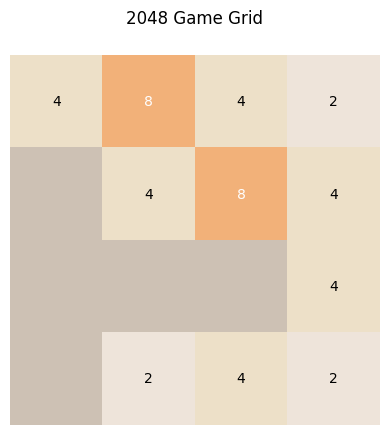

Score to beat: 6000
Dorment model score: 57.7


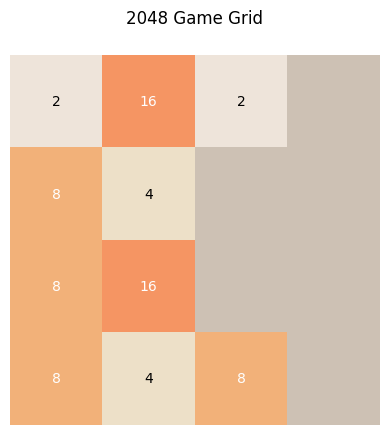

Score to beat: 6000
Dorment model score: 167.6


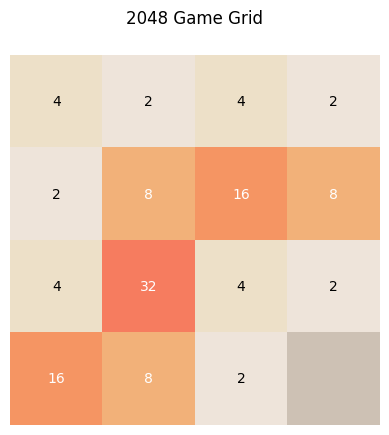

Score to beat: 6000
Dorment model score: 300.8


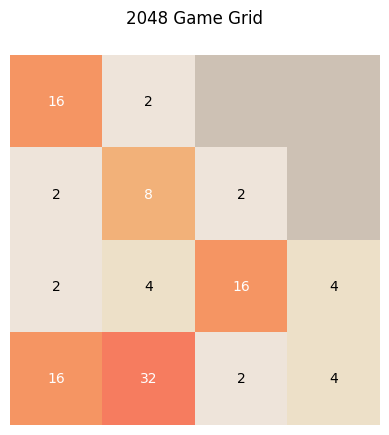

Score to beat: 6000
Dorment model score: 271.4


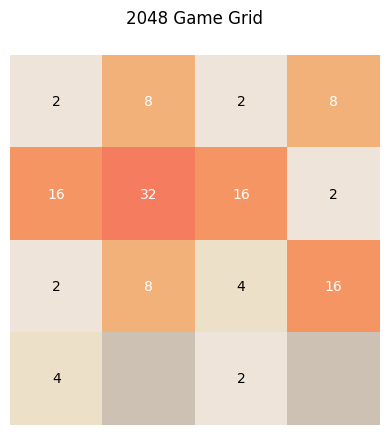

Score to beat: 6000
Dorment model score: 326.09999999999997


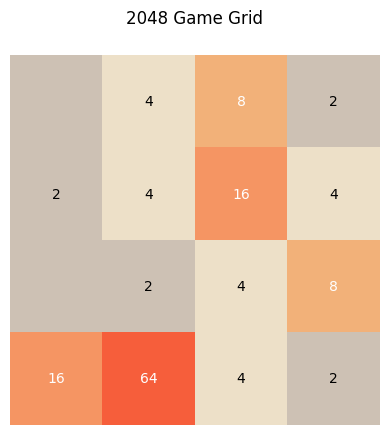

Score to beat: 6000
Dorment model score: 383.7


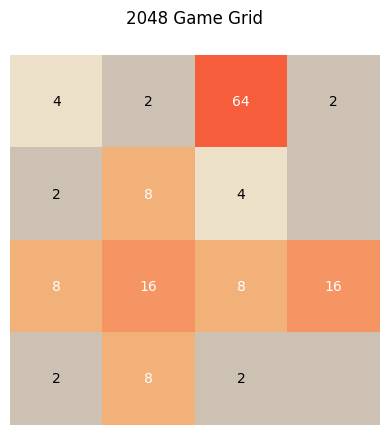

Score to beat: 6000
Dorment model score: 407.1


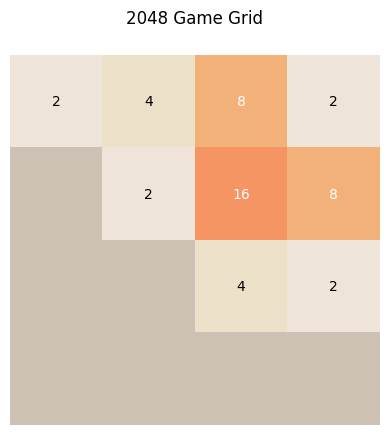

Score to beat: 6000
Dorment model score: 67.4


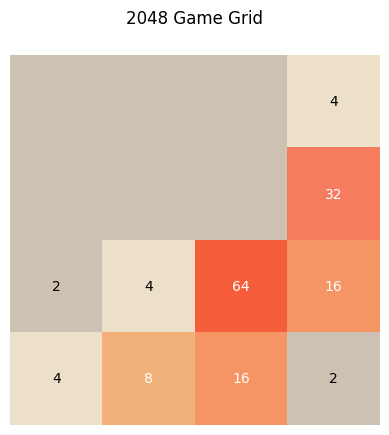

Score to beat: 6000
Dorment model score: 439.49999999999994


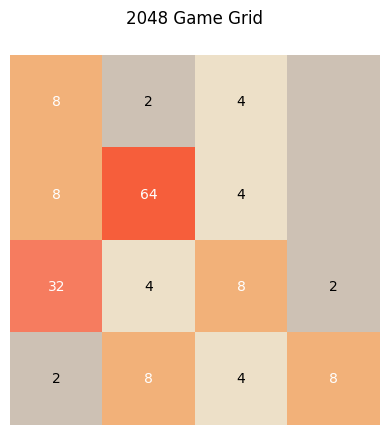

Score to beat: 6000
Dorment model score: 483.79999999999995


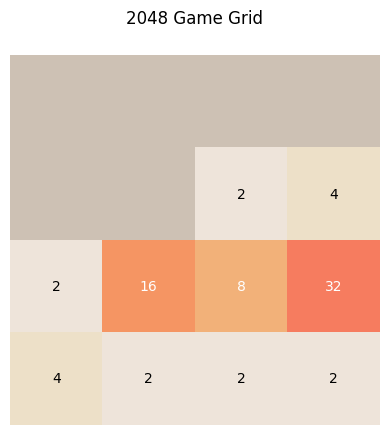

Score to beat: 6000
Dorment model score: 166.5


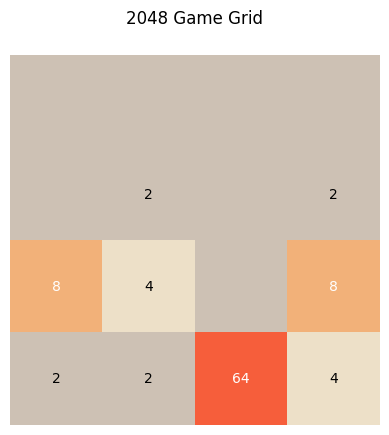

Score to beat: 6000
Dorment model score: 256.79999999999995


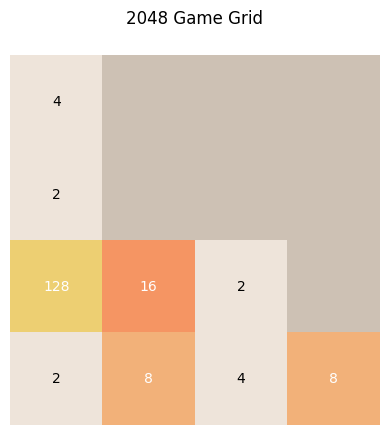

Score to beat: 6000
Dorment model score: 542.6


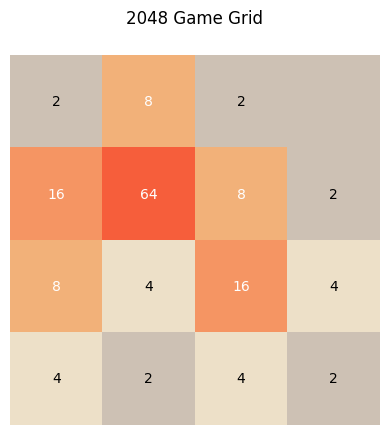

Score to beat: 6000
Dorment model score: 381.6


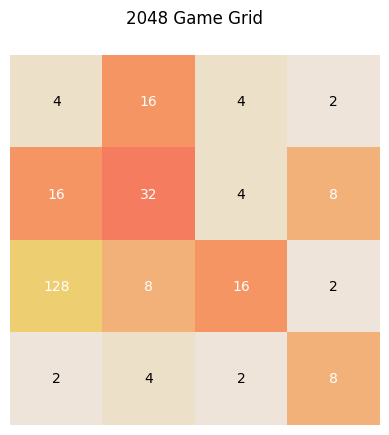

Score to beat: 6000
Dorment model score: 872.5999999999999


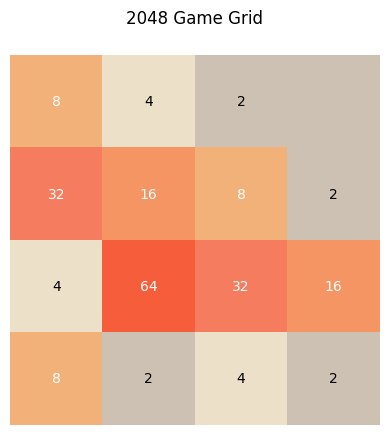

Score to beat: 6000
Dorment model score: 595.0999999999999


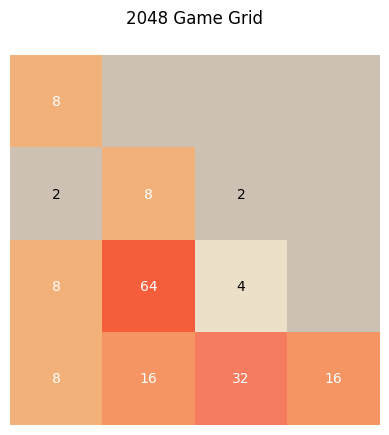

Score to beat: 6000
Dorment model score: 537.0999999999999


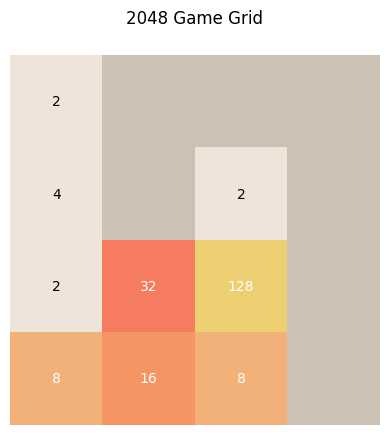

Score to beat: 6000
Dorment model score: 673.3


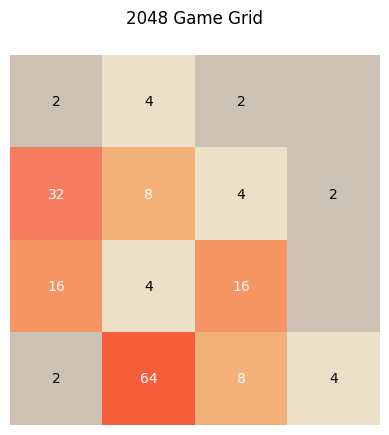

Score to beat: 6000
Dorment model score: 520.0


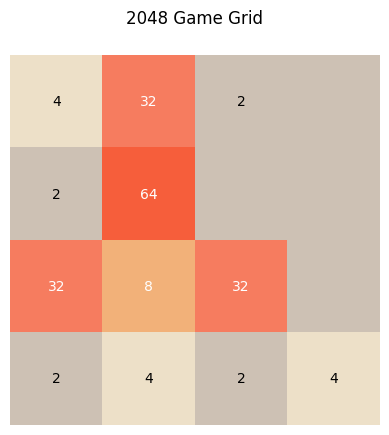

Score to beat: 6000
Dorment model score: 559.5


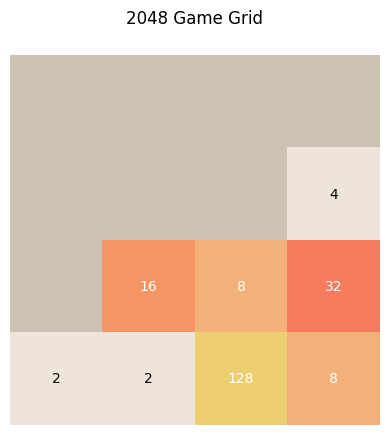

Score to beat: 6000
Dorment model score: 598.6999999999999


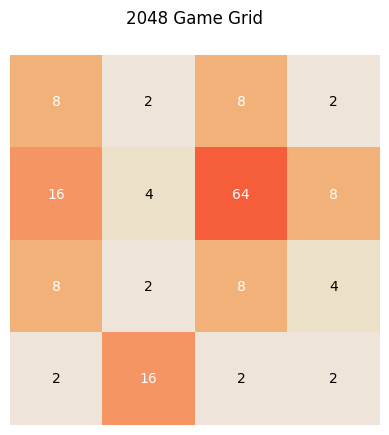

Score to beat: 6000
Dorment model score: 474.19999999999993


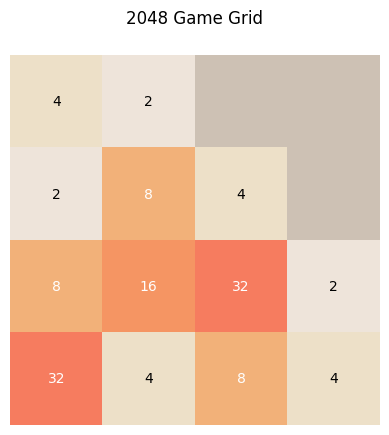

Score to beat: 6000
Dorment model score: 371.1


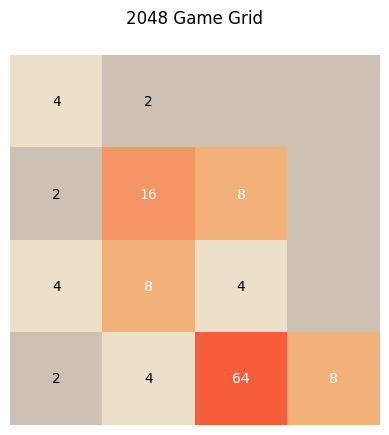

Score to beat: 6000
Dorment model score: 377.8999999999999


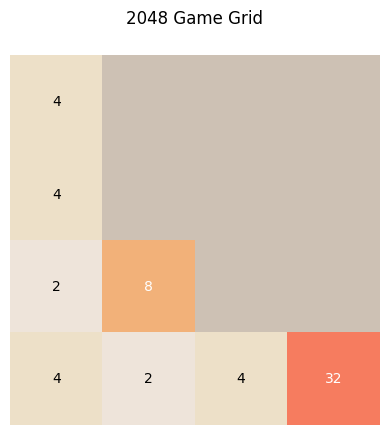

Score to beat: 6000
Dorment model score: 104.19999999999999


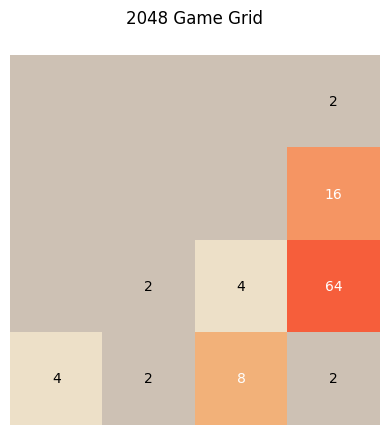

Score to beat: 6000
Dorment model score: 302.7


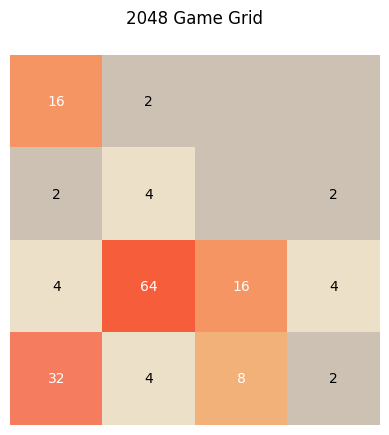

Score to beat: 6000
Dorment model score: 467.70000000000005


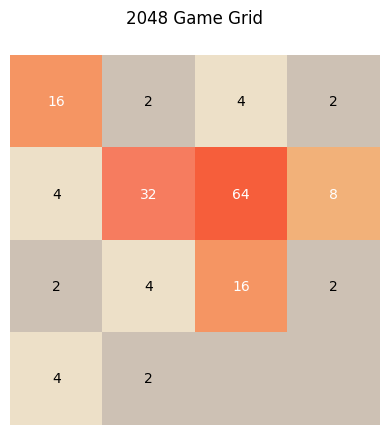

Score to beat: 6000
Dorment model score: 436.2


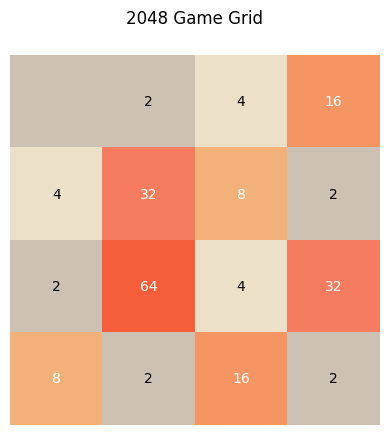

Score to beat: 6000
Dorment model score: 628.0


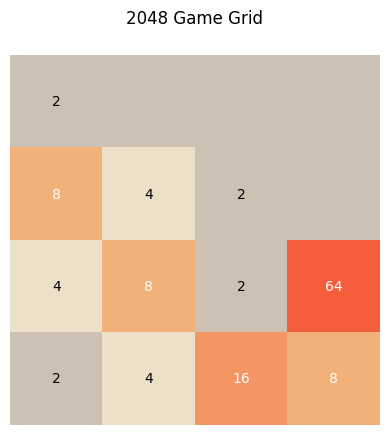

Score to beat: 6000
Dorment model score: 343.7


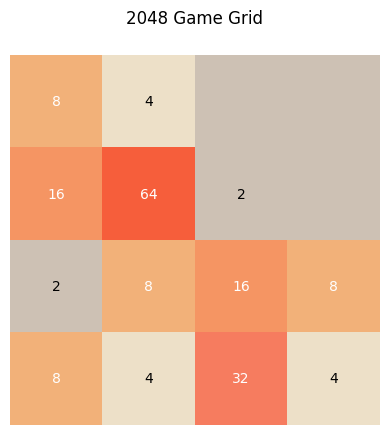

Score to beat: 6000
Dorment model score: 528.5999999999999


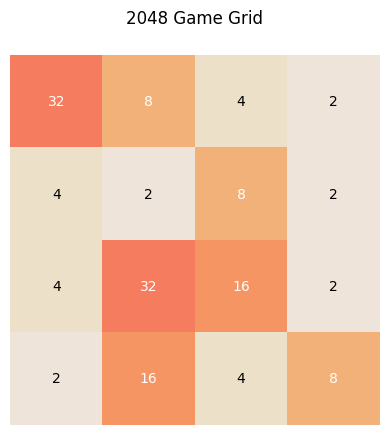

Score to beat: 6000
Dorment model score: 379.6


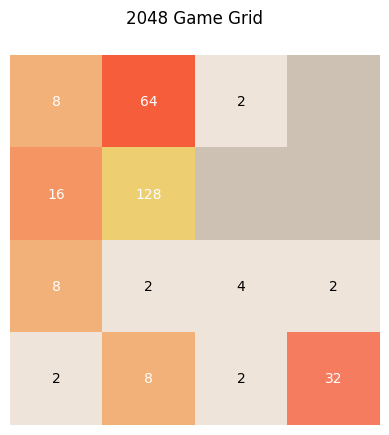

Score to beat: 6000
Dorment model score: 941.0


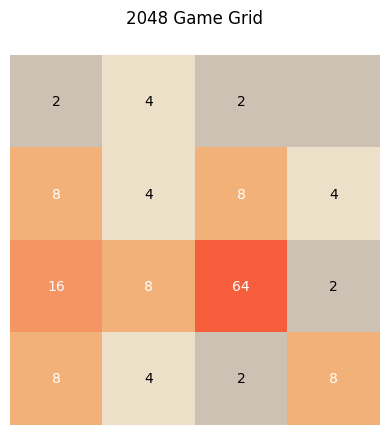

Score to beat: 6000
Dorment model score: 405.4


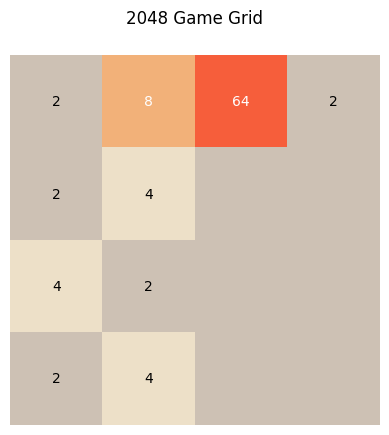

Score to beat: 6000
Dorment model score: 218.40000000000003


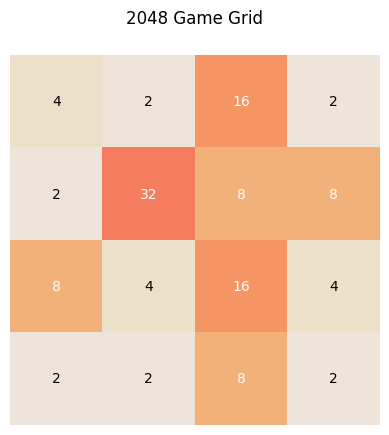

Score to beat: 6000
Dorment model score: 350.1


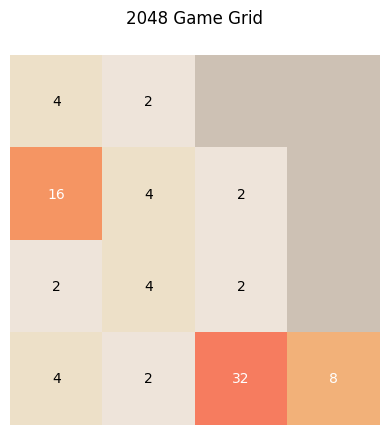

Score to beat: 6000
Dorment model score: 148.4


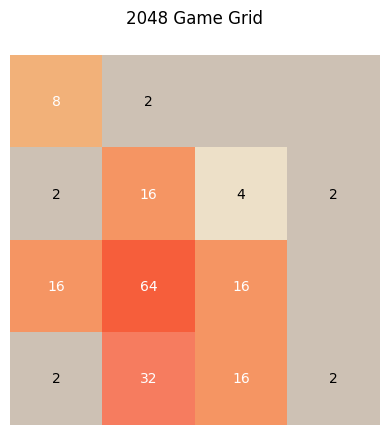

Score to beat: 6000
Dorment model score: 560.9


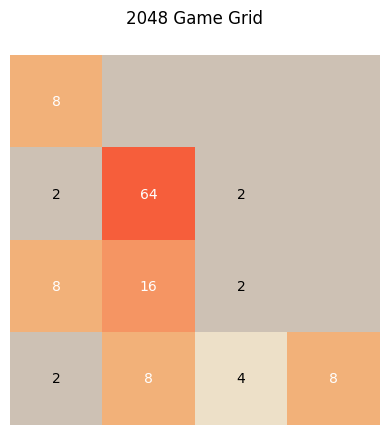

Score to beat: 6000
Dorment model score: 327.50000000000006


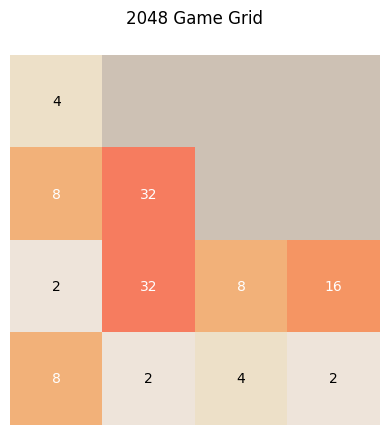

Score to beat: 6000
Dorment model score: 317.09999999999997


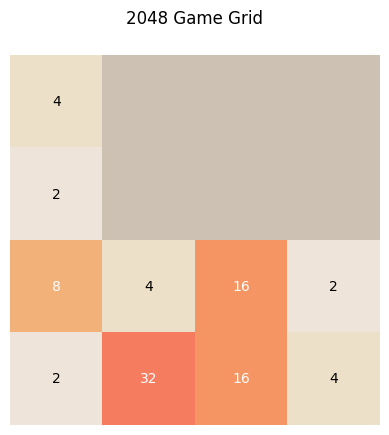

Score to beat: 6000
Dorment model score: 272.5


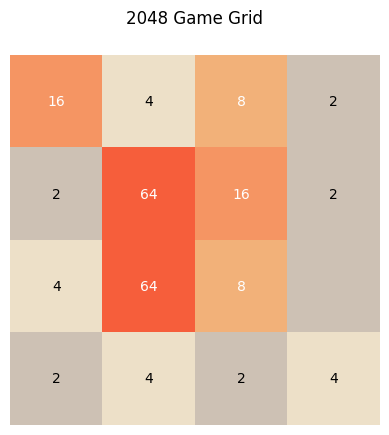

Score to beat: 6000
Dorment model score: 612.1999999999999


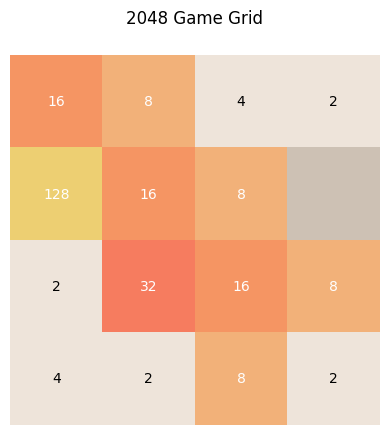

Score to beat: 6000
Dorment model score: 912.9000000000001


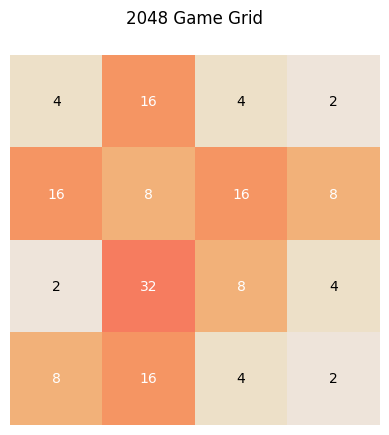

Score to beat: 6000
Dorment model score: 460.2


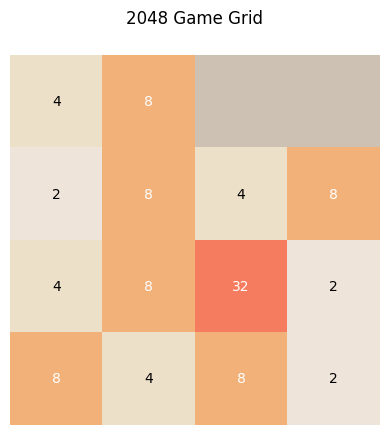

Score to beat: 6000
Dorment model score: 215.09999999999997


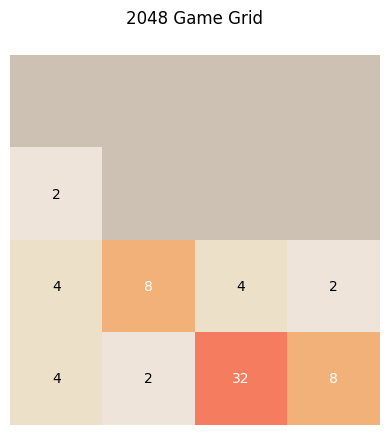

Score to beat: 6000
Dorment model score: 177.7


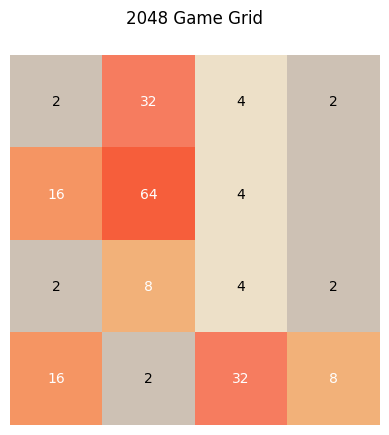

Score to beat: 6000
Dorment model score: 632.7


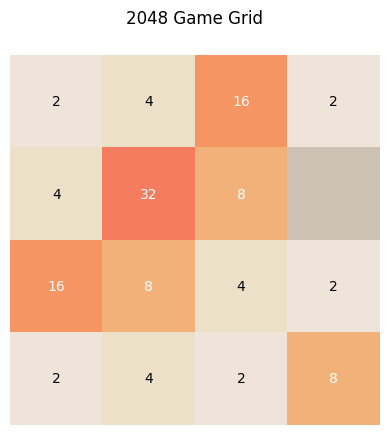

Score to beat: 6000
Dorment model score: 301.1


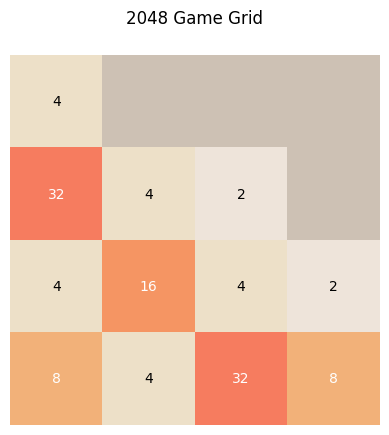

Score to beat: 6000
Dorment model score: 329.0


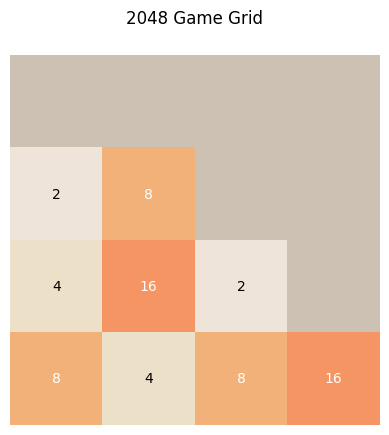

Score to beat: 6000
Dorment model score: 153.5


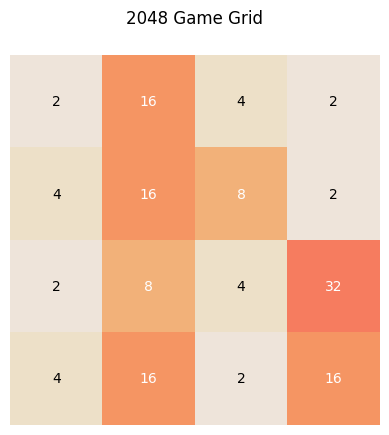

Score to beat: 6000
Dorment model score: 398.4


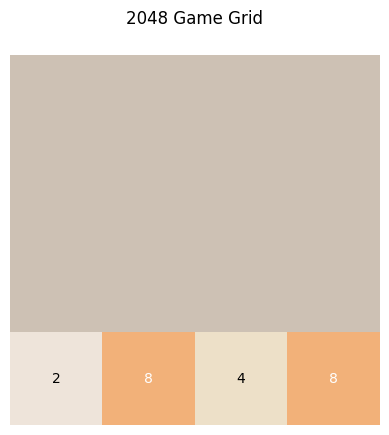

Score to beat: 6000
Dorment model score: 3.700000000000003


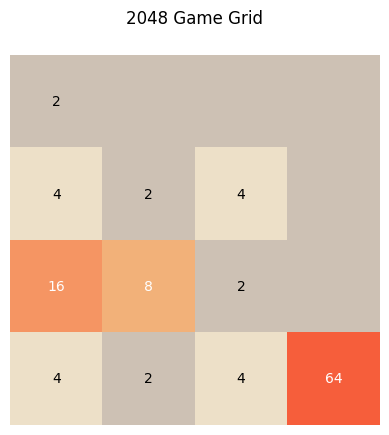

Score to beat: 6000
Dorment model score: 321.79999999999995


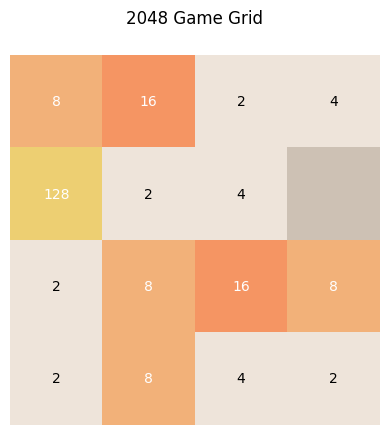

Score to beat: 6000
Dorment model score: 637.4


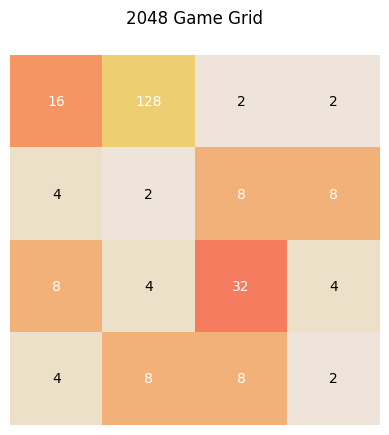

Score to beat: 6000
Dorment model score: 751.3


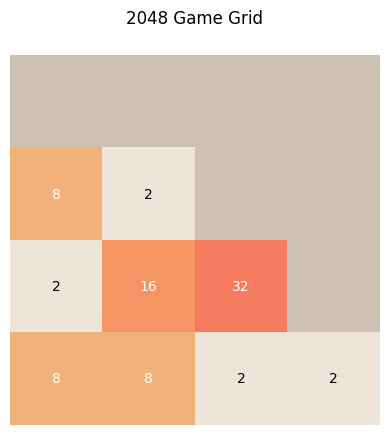

Score to beat: 6000
Dorment model score: 203.79999999999998


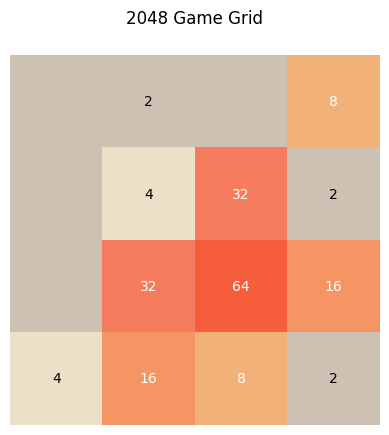

Score to beat: 6000
Dorment model score: 586.6999999999999


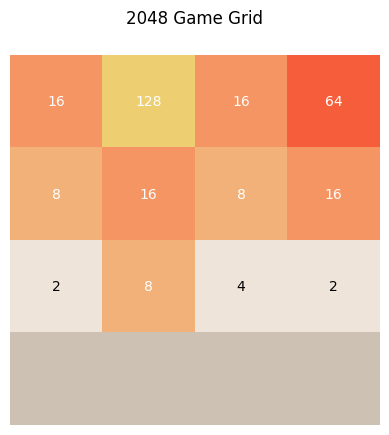

Score to beat: 6000
Dorment model score: 957.9999999999997


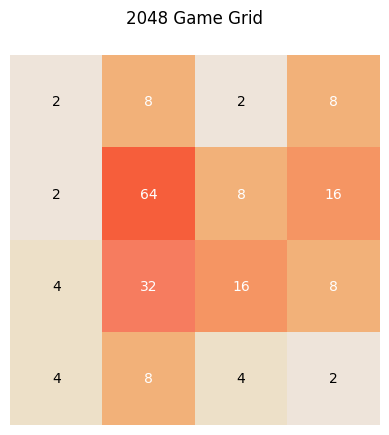

Score to beat: 6000
Dorment model score: 583.2


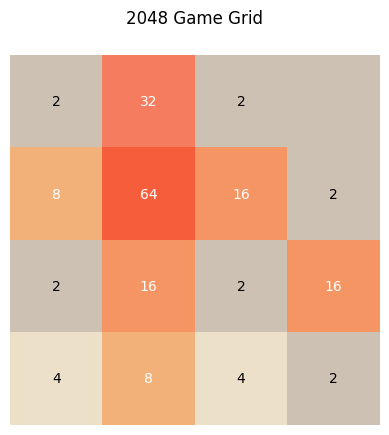

Score to beat: 6000
Dorment model score: 571.5999999999999


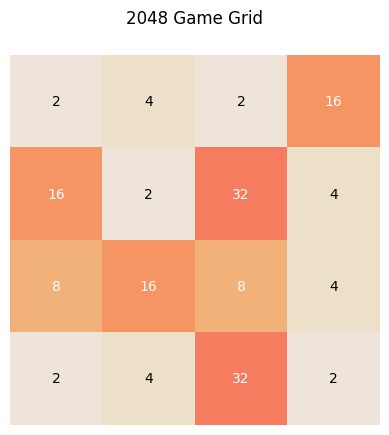

Score to beat: 6000
Dorment model score: 449.0


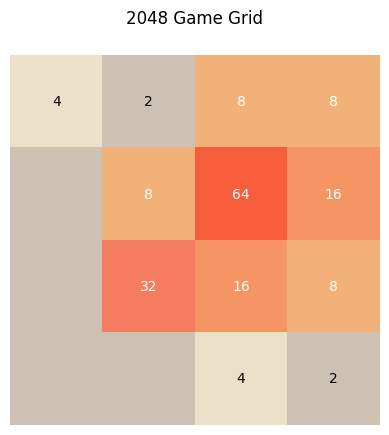

Score to beat: 6000
Dorment model score: 525.5


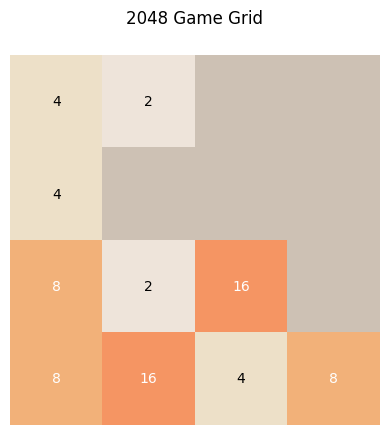

Score to beat: 6000
Dorment model score: 200.89999999999998


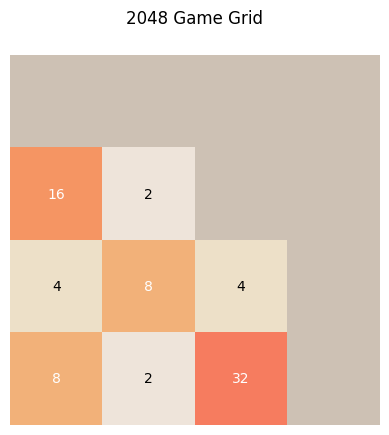

Score to beat: 6000
Dorment model score: 166.70000000000002


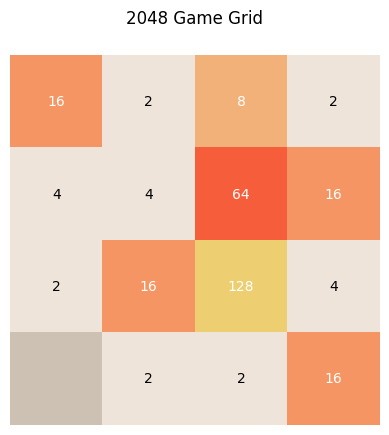

Score to beat: 6000
Dorment model score: 979.0999999999999


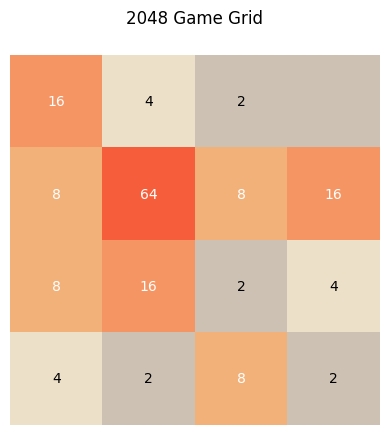

Score to beat: 6000
Dorment model score: 448.20000000000005


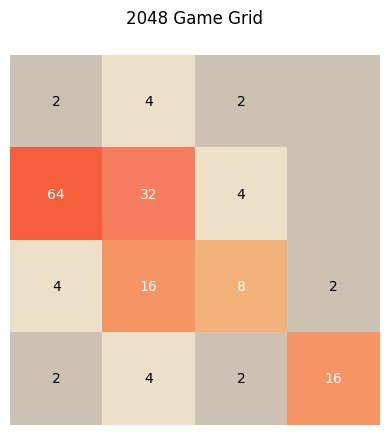

Score to beat: 6000
Dorment model score: 486.69999999999993


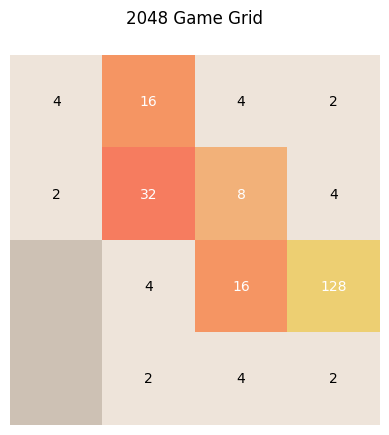

Score to beat: 6000
Dorment model score: 744.4


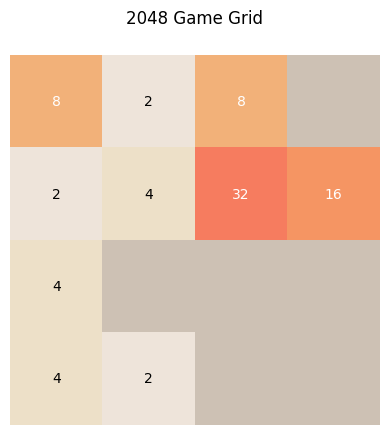

Score to beat: 6000
Dorment model score: 222.7
TARGET UPDATED


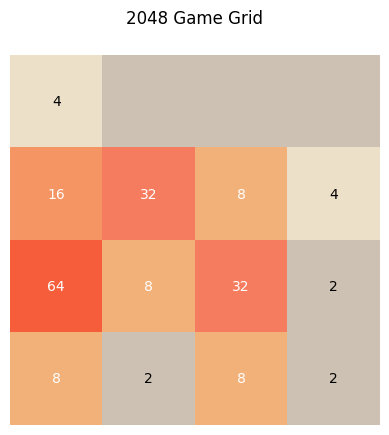

Score to beat: 6000
Dorment model score: 625.6


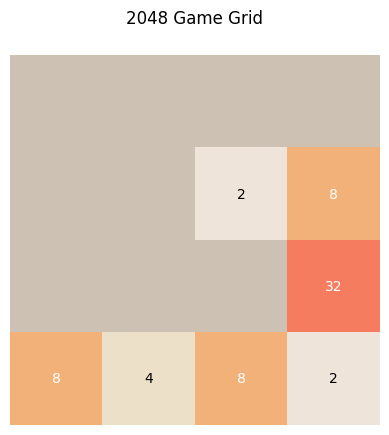

Score to beat: 6000
Dorment model score: 167.5


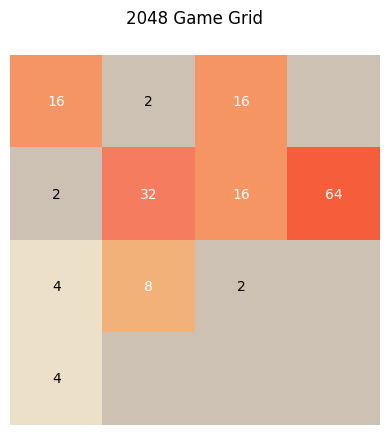

Score to beat: 6000
Dorment model score: 551.6999999999999


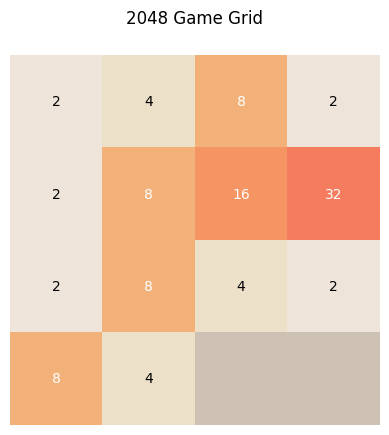

Score to beat: 6000
Dorment model score: 242.39999999999998


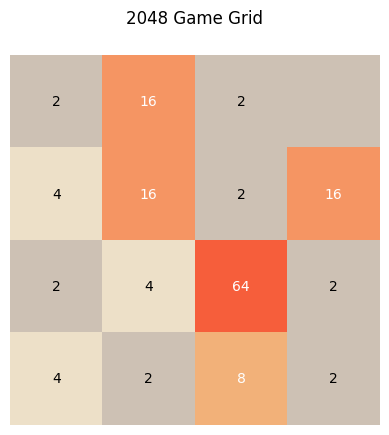

Score to beat: 6000
Dorment model score: 429.2


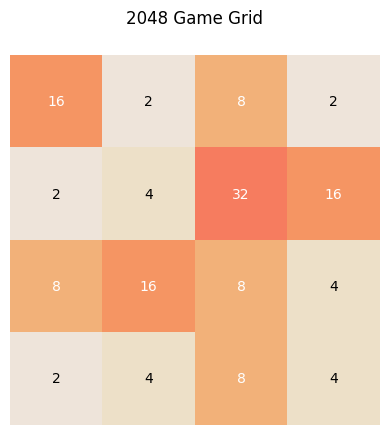

Score to beat: 6000
Dorment model score: 400.3


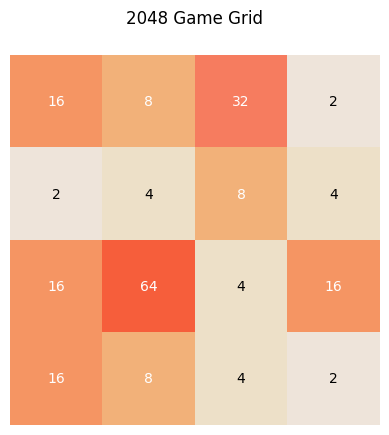

Score to beat: 6000
Dorment model score: 656.5999999999999


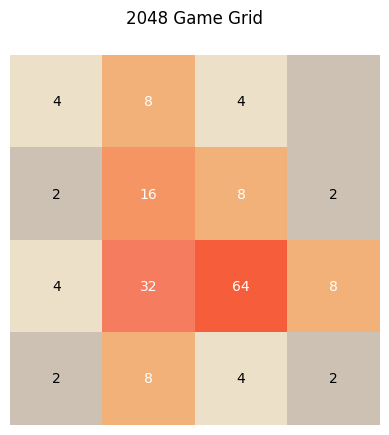

Score to beat: 6000
Dorment model score: 502.4


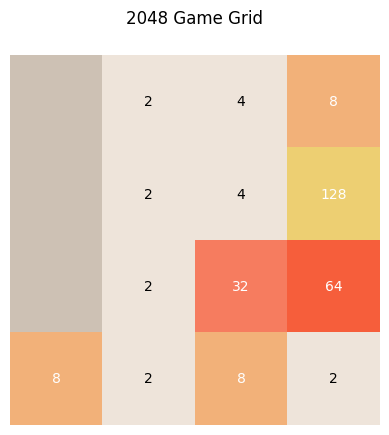

Score to beat: 6000
Dorment model score: 862.5999999999999


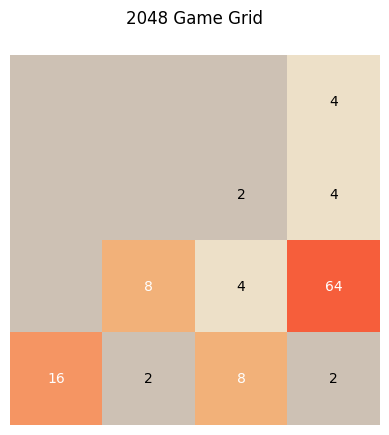

Score to beat: 6000
Dorment model score: 339.0


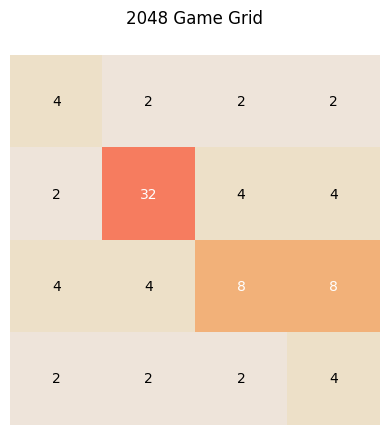

Score to beat: 6000
Dorment model score: 166.29999999999998


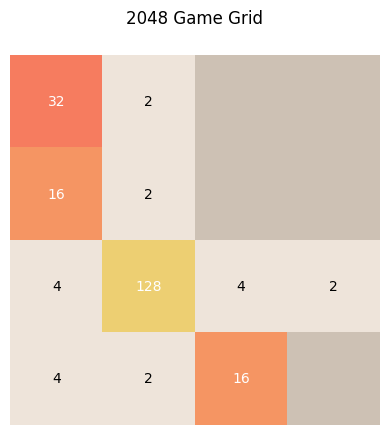

Score to beat: 6000
Dorment model score: 690.6000000000001


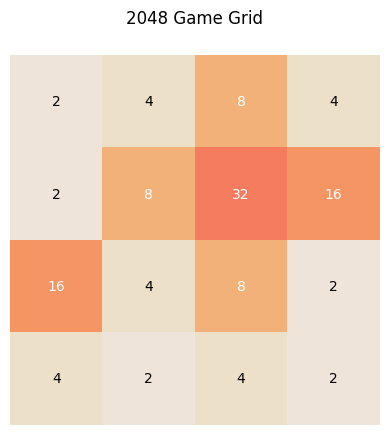

Score to beat: 6000
Dorment model score: 283.9


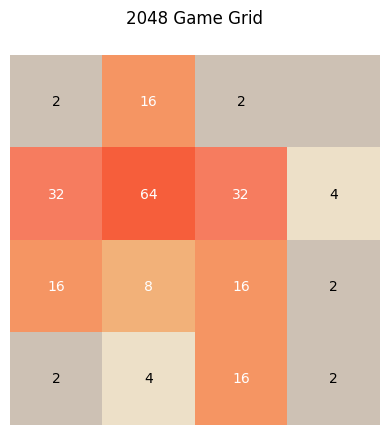

Score to beat: 6000
Dorment model score: 747.1


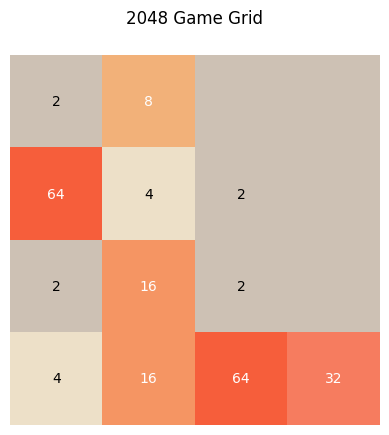

Score to beat: 6000
Dorment model score: 685.3


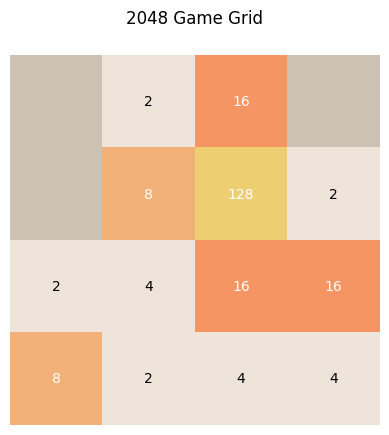

Score to beat: 6000
Dorment model score: 663.9999999999999


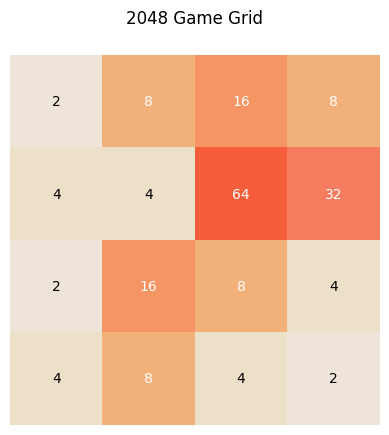

Score to beat: 6000
Dorment model score: 558.3


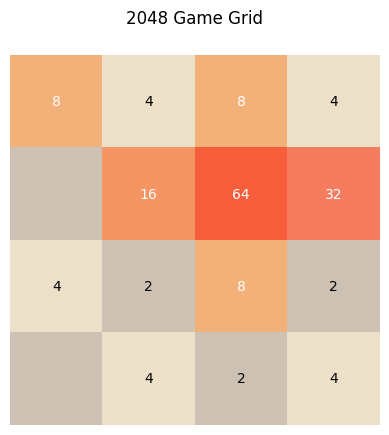

Score to beat: 6000
Dorment model score: 465.7


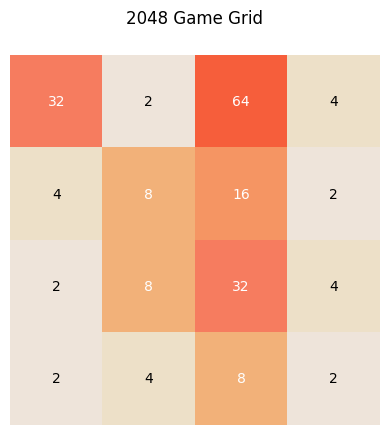

Score to beat: 6000
Dorment model score: 561.9


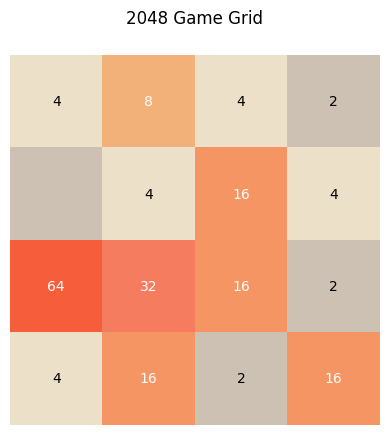

Score to beat: 6000
Dorment model score: 590.0999999999999


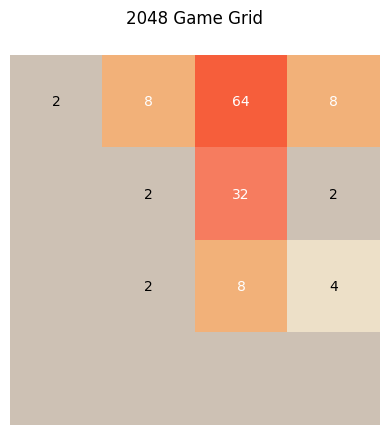

Score to beat: 6000
Dorment model score: 380.09999999999997


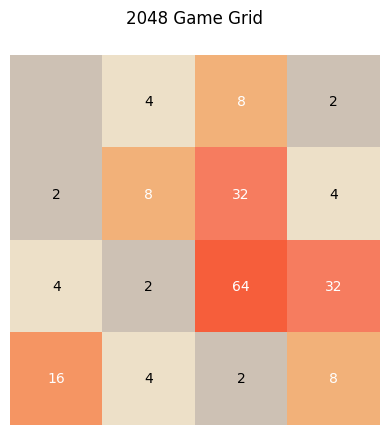

Score to beat: 6000
Dorment model score: 581.5


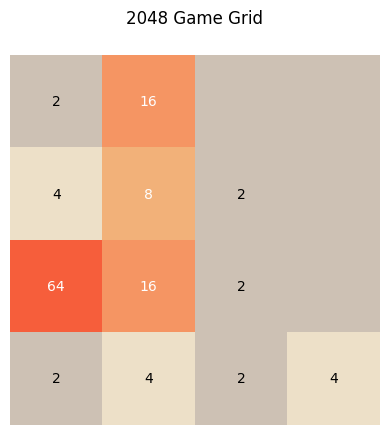

Score to beat: 6000
Dorment model score: 377.3


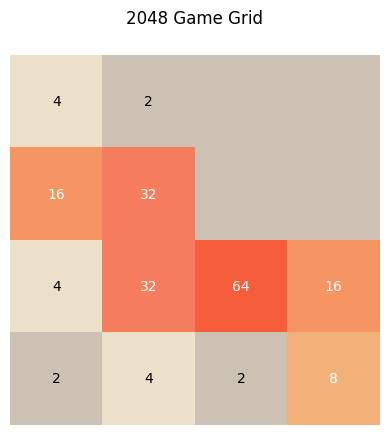

Score to beat: 6000
Dorment model score: 575.6999999999999


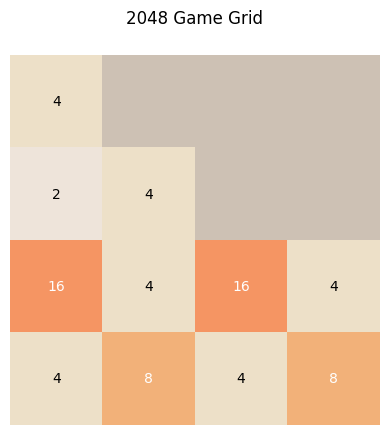

Score to beat: 6000
Dorment model score: 186.5


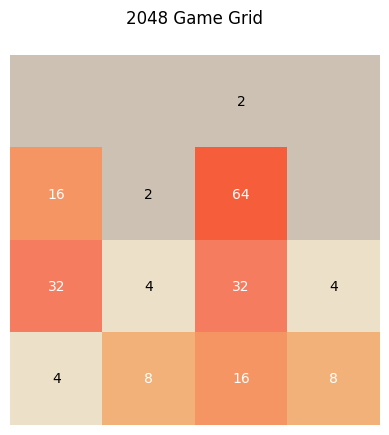

Score to beat: 6000
Dorment model score: 565.1999999999999


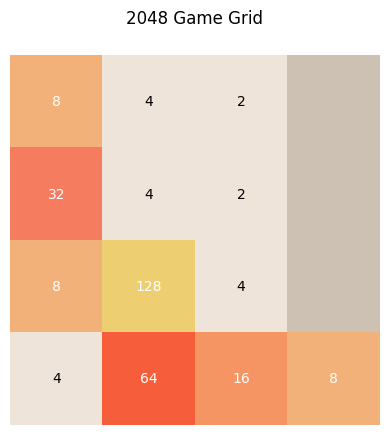

Score to beat: 6000
Dorment model score: 942.8999999999999


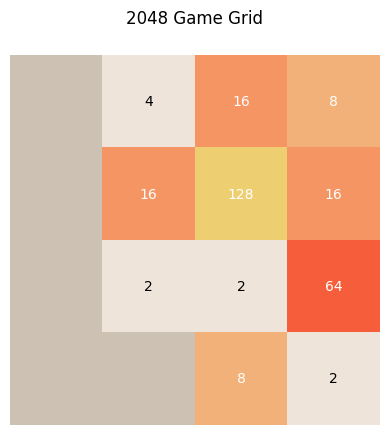

Score to beat: 6000
Dorment model score: 906.8999999999997


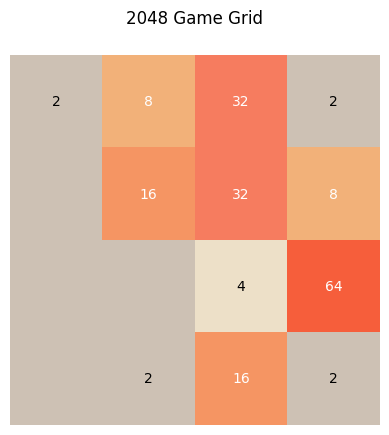

Score to beat: 6000
Dorment model score: 562.9


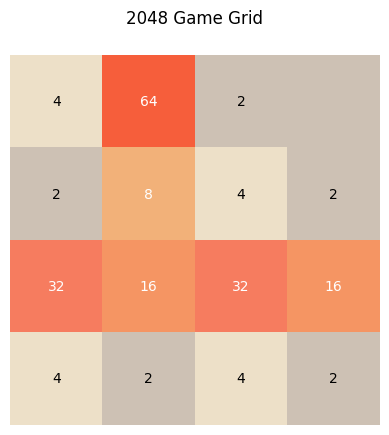

Score to beat: 6000
Dorment model score: 548.5


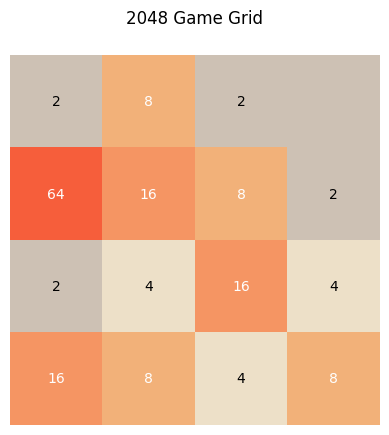

Score to beat: 6000
Dorment model score: 502.29999999999995


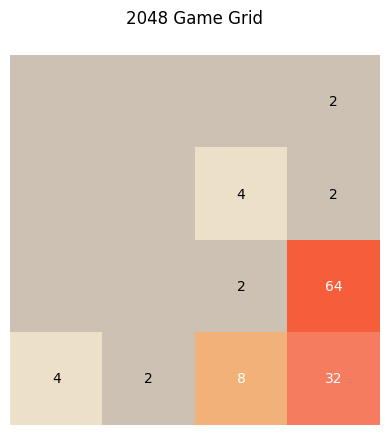

Score to beat: 6000
Dorment model score: 302.5


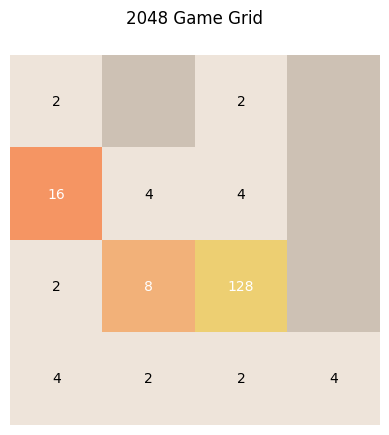

Score to beat: 6000
Dorment model score: 578.3


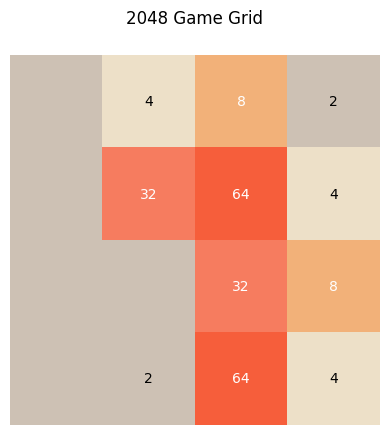

Score to beat: 6000
Dorment model score: 666.9999999999999


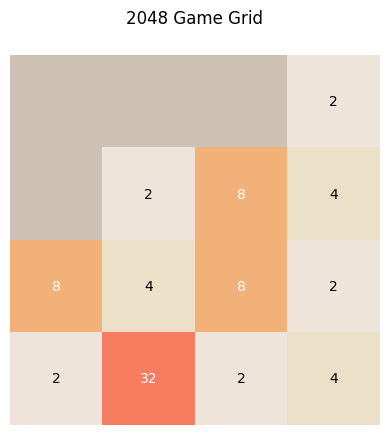

Score to beat: 6000
Dorment model score: 169.79999999999998


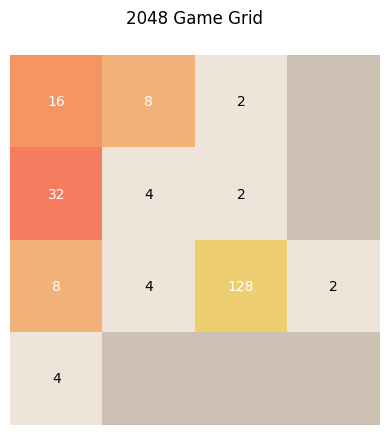

Score to beat: 6000
Dorment model score: 698.0


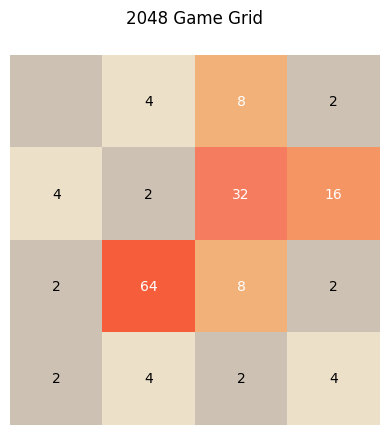

Score to beat: 6000
Dorment model score: 463.7


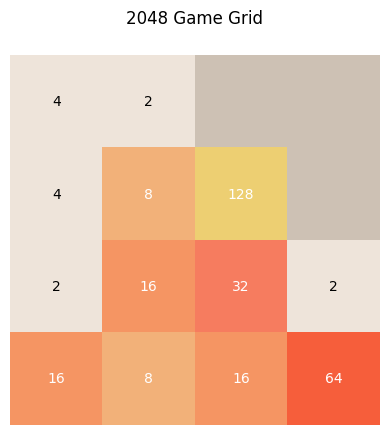

Score to beat: 6000
Dorment model score: 1002.8


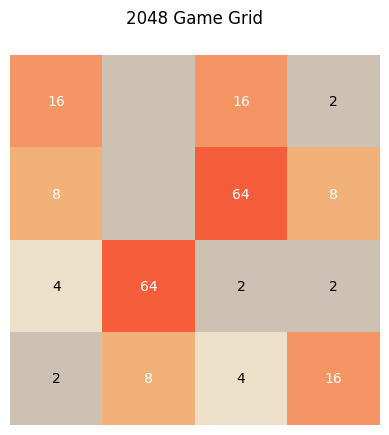

Score to beat: 6000
Dorment model score: 657.3


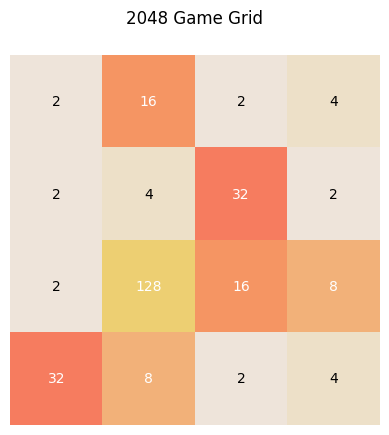

Score to beat: 6000
Dorment model score: 924.3


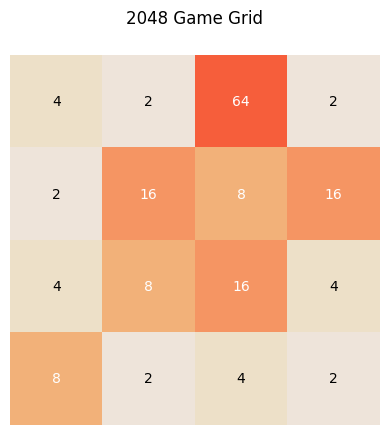

Score to beat: 6000
Dorment model score: 507.79999999999995


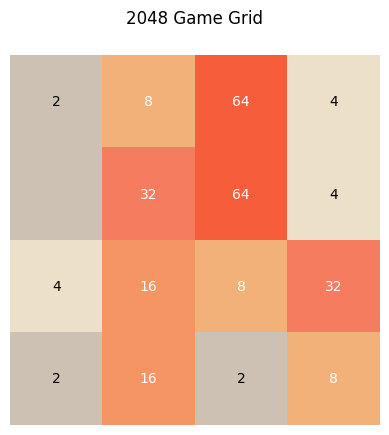

Score to beat: 6000
Dorment model score: 846.1999999999999


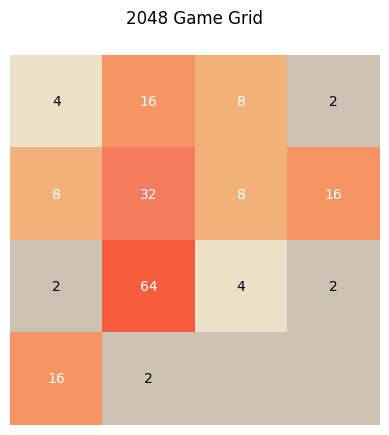

Score to beat: 6000
Dorment model score: 529.4000000000001


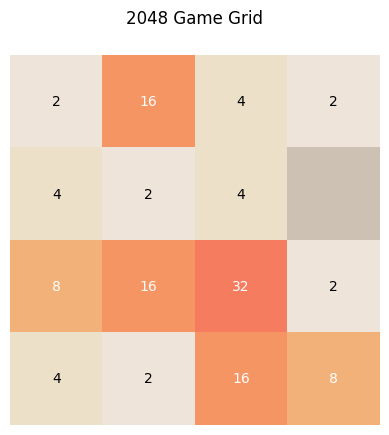

Score to beat: 6000
Dorment model score: 340.19999999999993


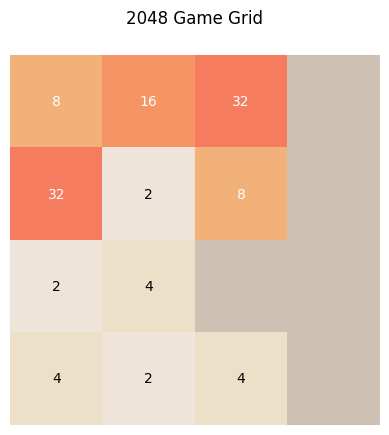

Score to beat: 6000
Dorment model score: 333.8


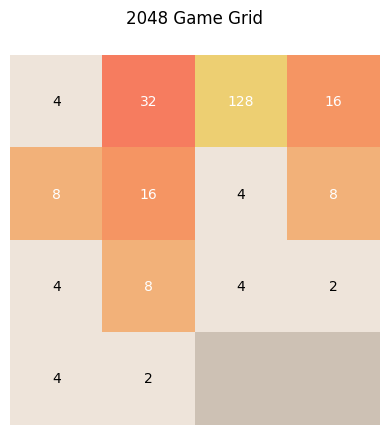

Score to beat: 6000
Dorment model score: 798.9999999999999


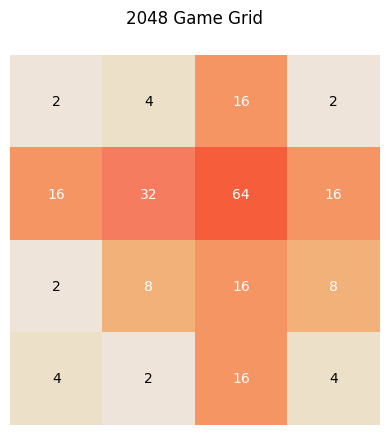

Score to beat: 6000
Dorment model score: 633.5


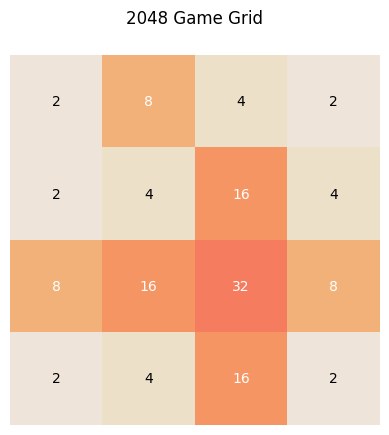

Score to beat: 6000
Dorment model score: 373.09999999999997


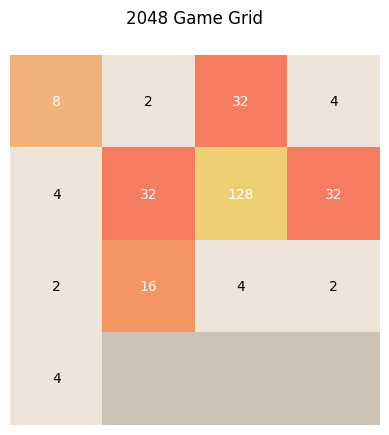

Score to beat: 6000
Dorment model score: 894.0999999999999


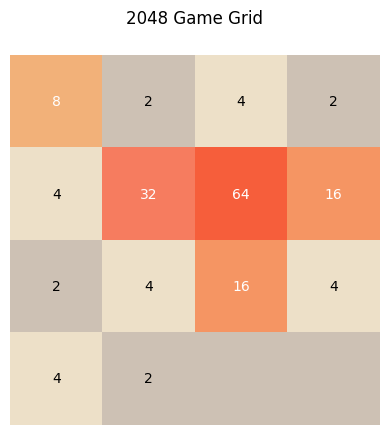

Score to beat: 6000
Dorment model score: 540.4


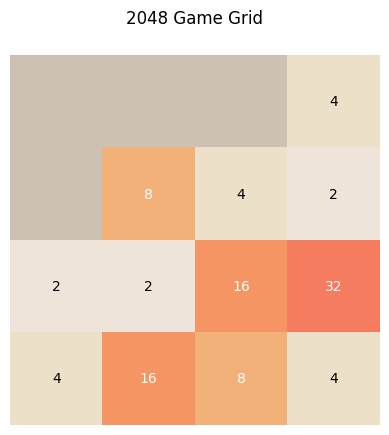

Score to beat: 6000
Dorment model score: 277.90000000000003


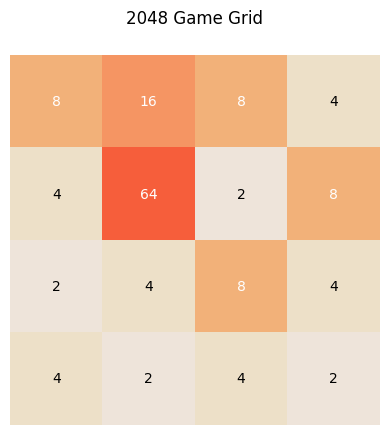

Score to beat: 6000
Dorment model score: 408.59999999999997


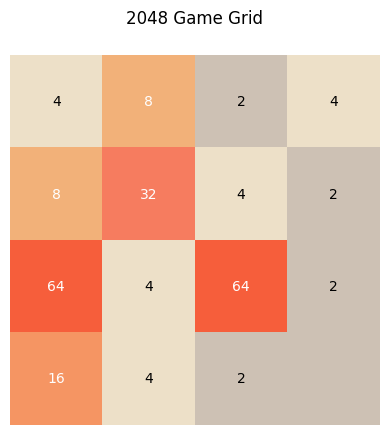

Score to beat: 6000
Dorment model score: 699.6


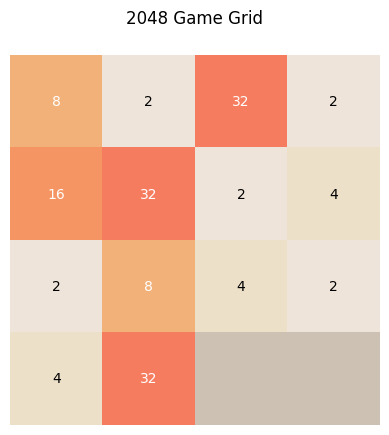

Score to beat: 6000
Dorment model score: 430.2


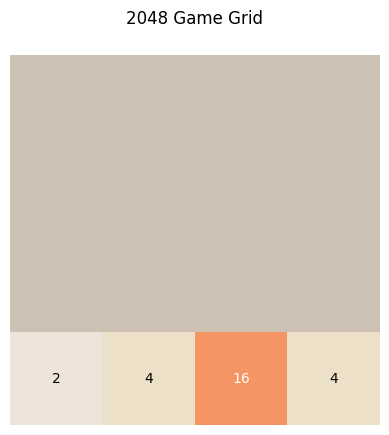

Score to beat: 6000
Dorment model score: 37.7


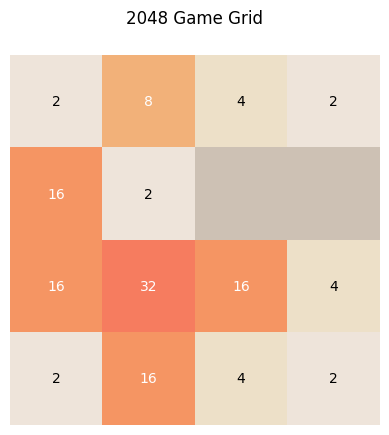

Score to beat: 6000
Dorment model score: 407.09999999999997


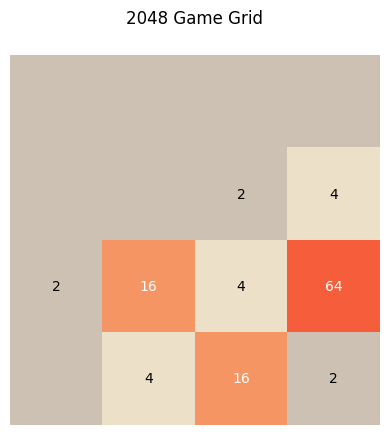

Score to beat: 6000
Dorment model score: 327.29999999999995


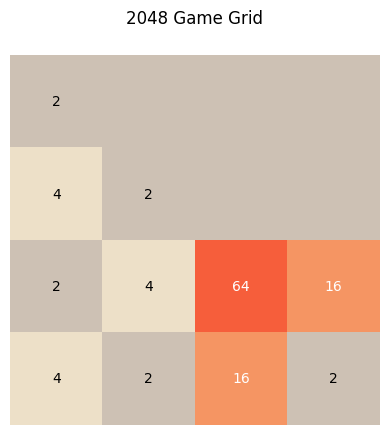

Score to beat: 6000
Dorment model score: 344.29999999999995


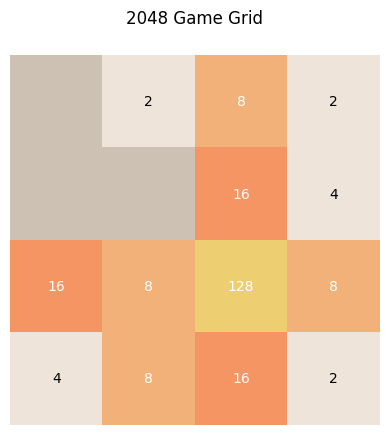

Score to beat: 6000
Dorment model score: 618.2999999999998


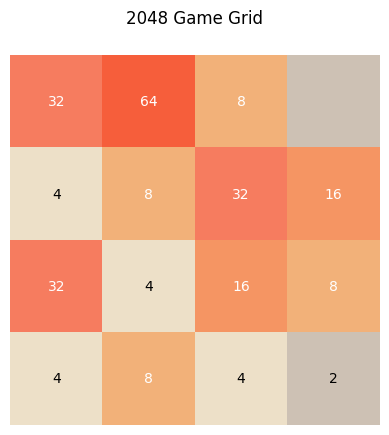

Score to beat: 6000
Dorment model score: 779.0999999999999


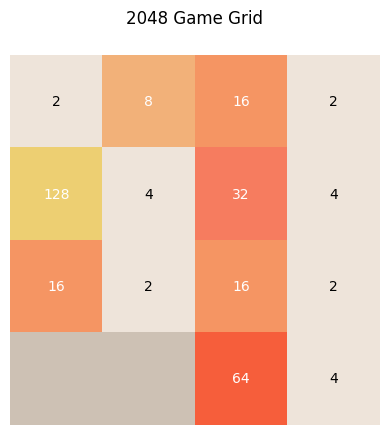

Score to beat: 6000
Dorment model score: 1085.2


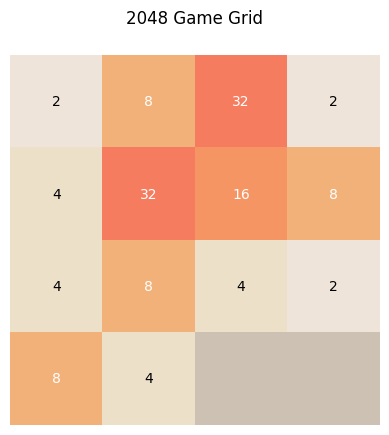

Score to beat: 6000
Dorment model score: 372.29999999999995


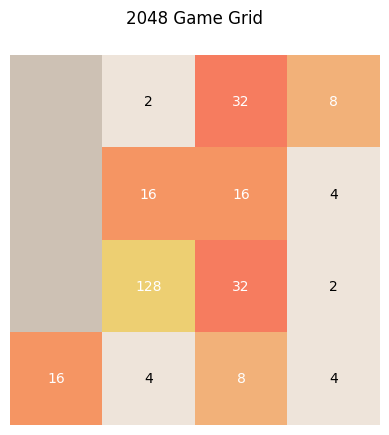

Score to beat: 6000
Dorment model score: 935.0


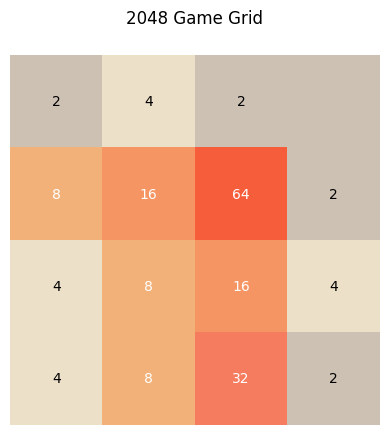

Score to beat: 6000
Dorment model score: 516.9000000000001


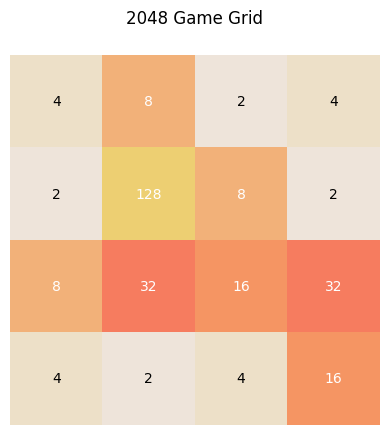

Score to beat: 6000
Dorment model score: 907.0999999999999


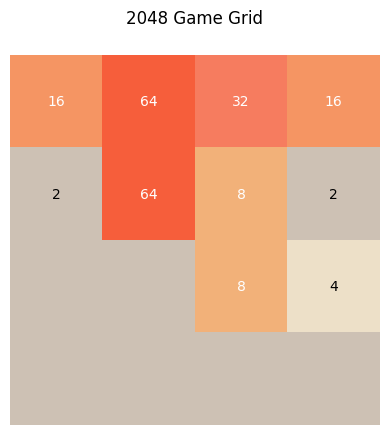

Score to beat: 6000
Dorment model score: 674.9999999999999


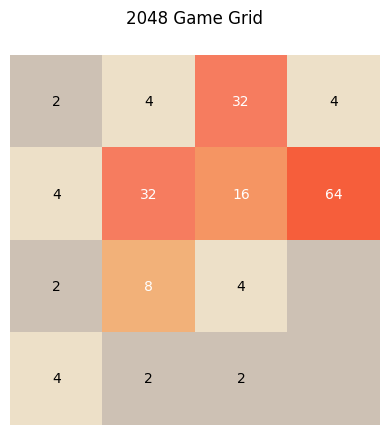

Score to beat: 6000
Dorment model score: 547.8


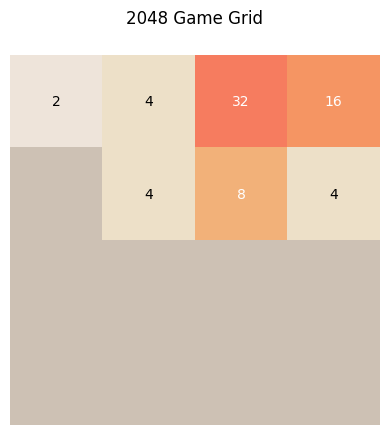

Score to beat: 6000
Dorment model score: 179.6


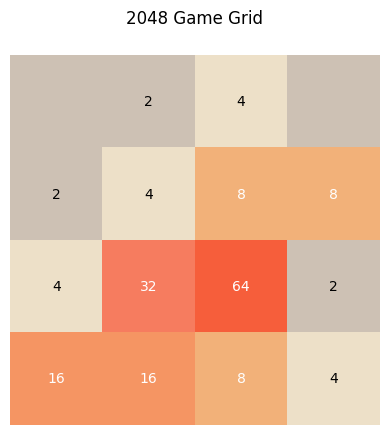

Score to beat: 6000
Dorment model score: 580.4


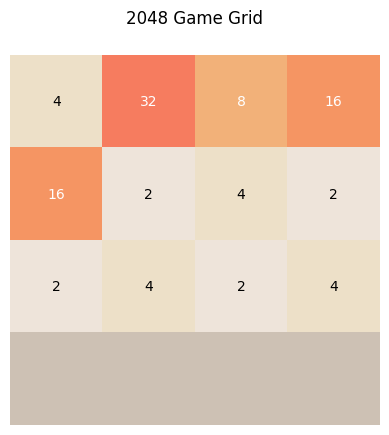

Score to beat: 6000
Dorment model score: 252.0


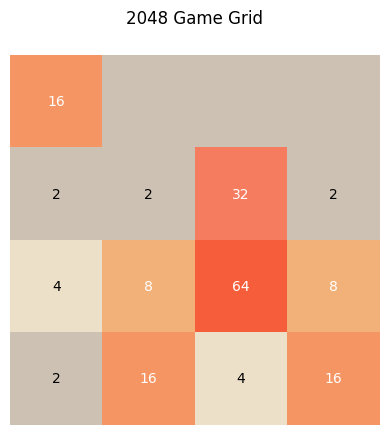

Score to beat: 6000
Dorment model score: 564.8999999999999


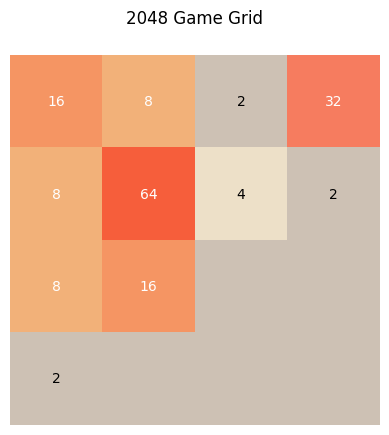

Score to beat: 6000
Dorment model score: 448.5


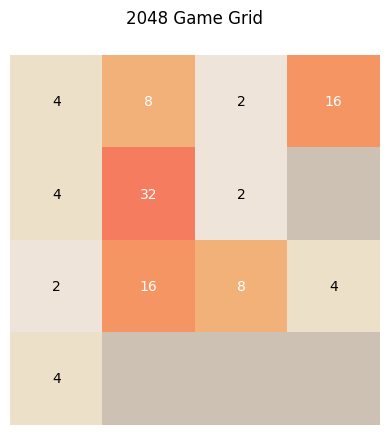

Score to beat: 6000
Dorment model score: 237.7


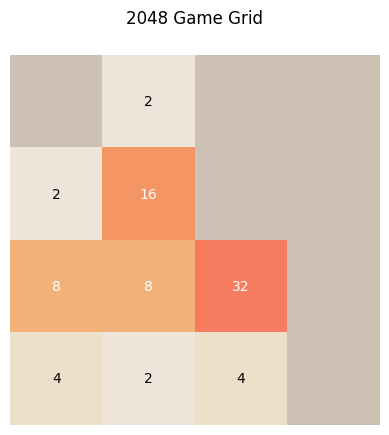

Score to beat: 6000
Dorment model score: 216.8


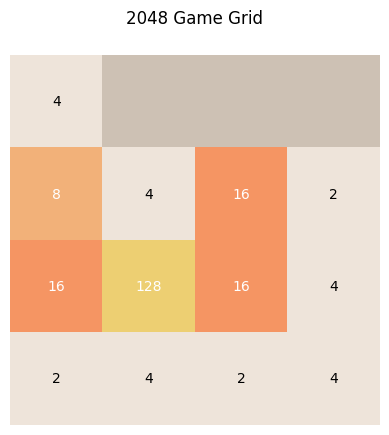

Score to beat: 6000
Dorment model score: 628.8999999999999


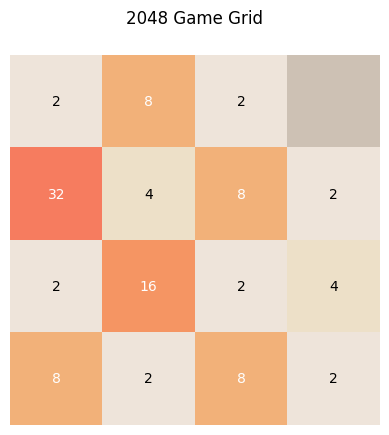

Score to beat: 6000
Dorment model score: 259.9


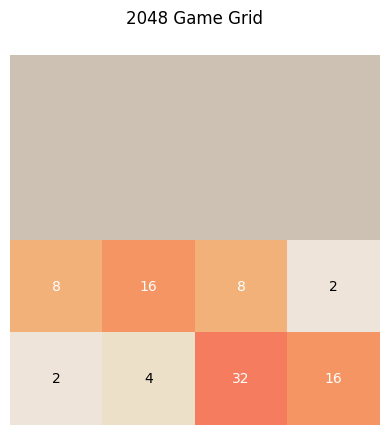

Score to beat: 6000
Dorment model score: 216.7


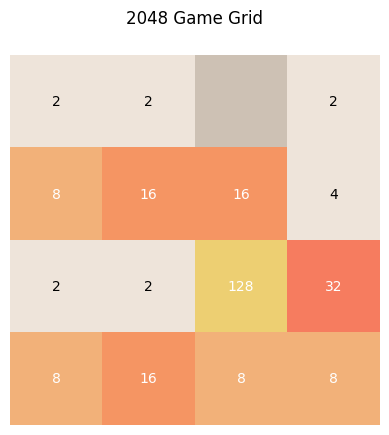

Score to beat: 6000
Dorment model score: 794.3


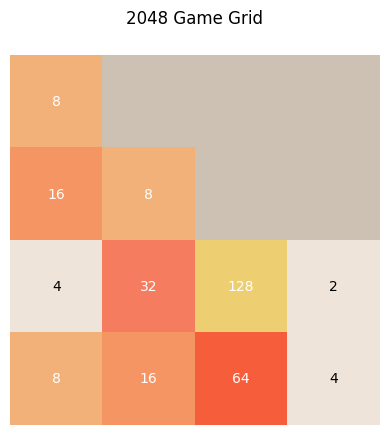

Score to beat: 6000
Dorment model score: 979.2999999999997


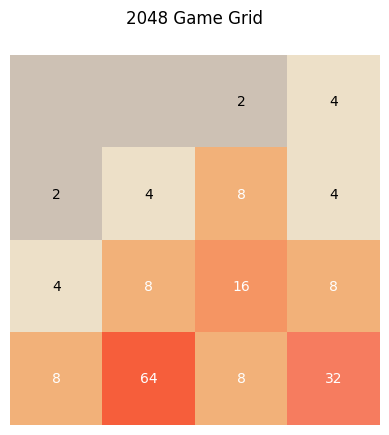

Score to beat: 6000
Dorment model score: 551.3999999999999


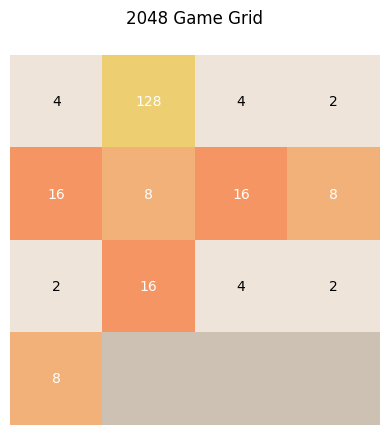

Score to beat: 6000
Dorment model score: 703.4


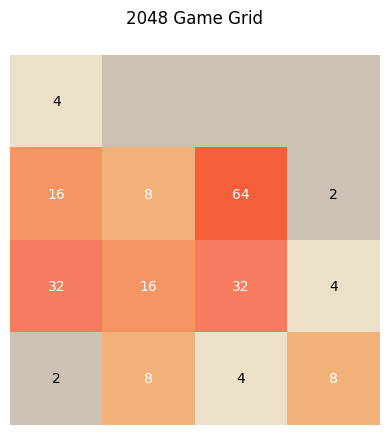

Score to beat: 6000
Dorment model score: 625.4


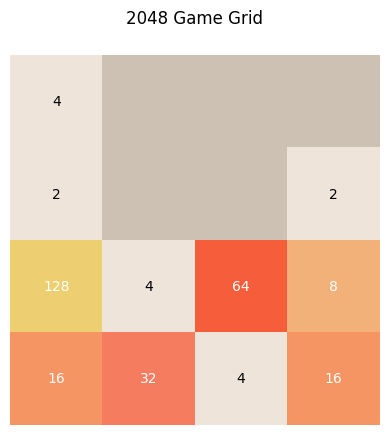

Score to beat: 6000
Dorment model score: 929.7999999999998


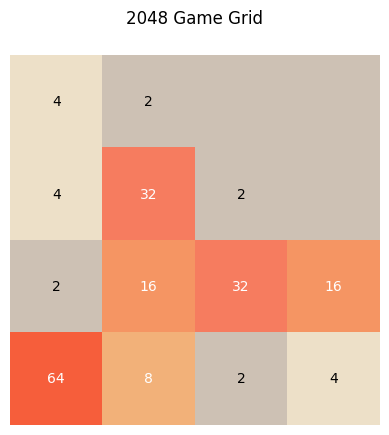

Score to beat: 6000
Dorment model score: 585.5


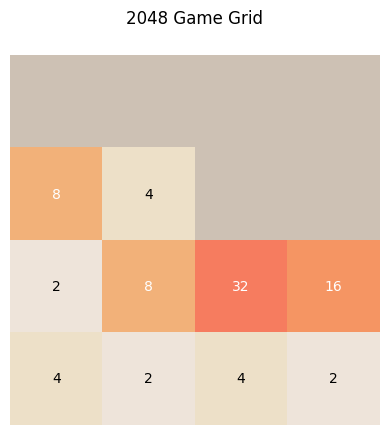

Score to beat: 6000
Dorment model score: 244.39999999999998


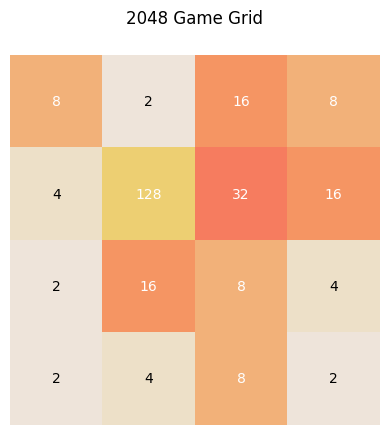

Score to beat: 6000
Dorment model score: 815.5
TARGET UPDATED


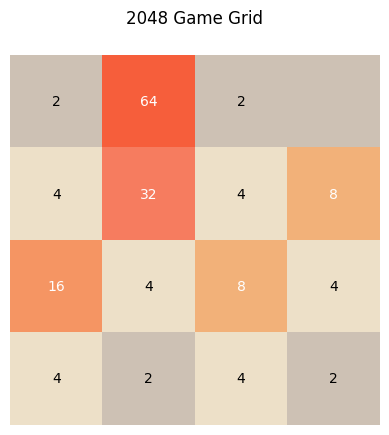

Score to beat: 6000
Dorment model score: 465.29999999999995


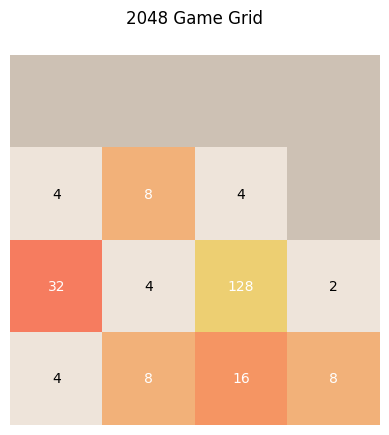

Score to beat: 6000
Dorment model score: 736.6


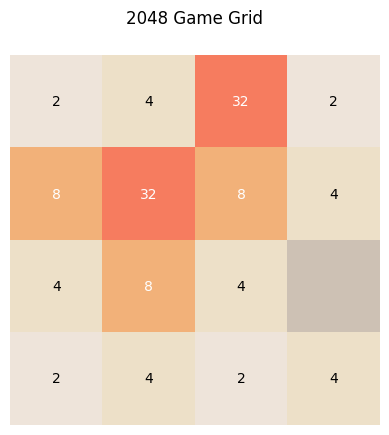

Score to beat: 6000
Dorment model score: 303.1


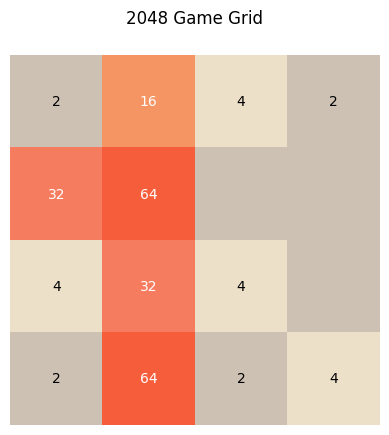

Score to beat: 6000
Dorment model score: 740.1999999999999


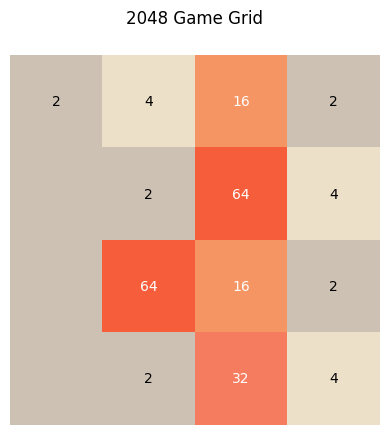

Score to beat: 6000
Dorment model score: 708.3


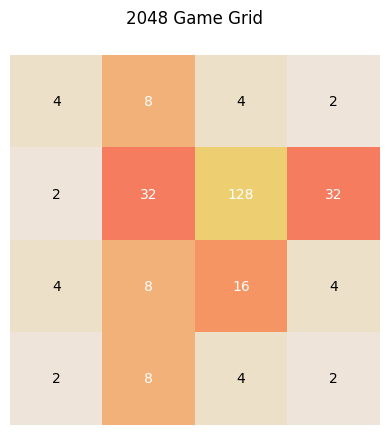

Score to beat: 6000
Dorment model score: 875.9


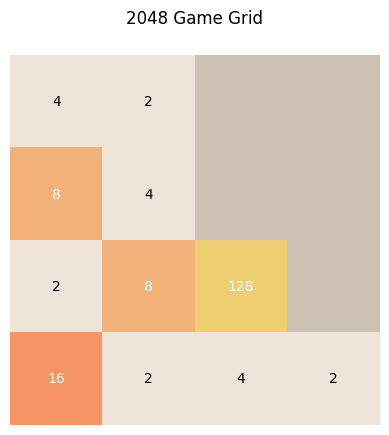

Score to beat: 6000
Dorment model score: 608.9999999999999


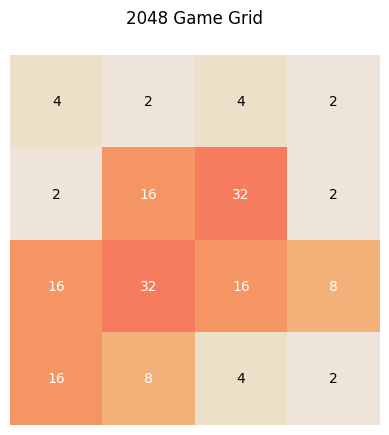

Score to beat: 6000
Dorment model score: 462.9


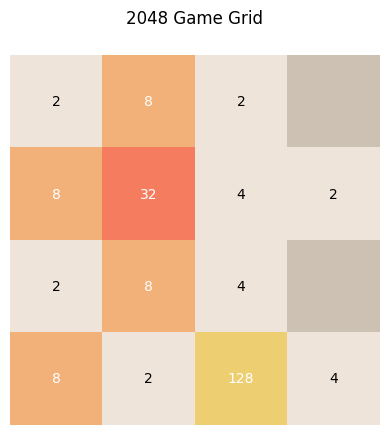

Score to beat: 6000
Dorment model score: 691.2


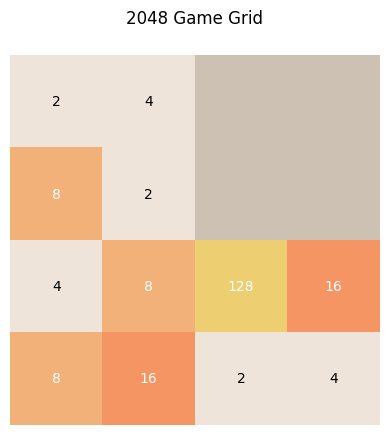

Score to beat: 6000
Dorment model score: 639.3999999999999


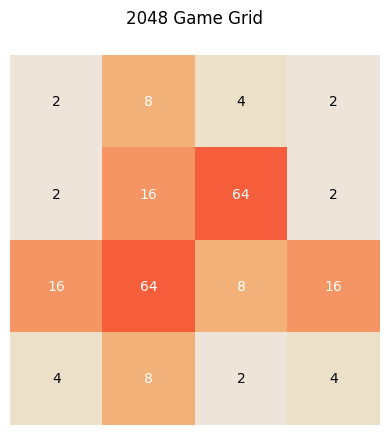

Score to beat: 6000
Dorment model score: 679.3


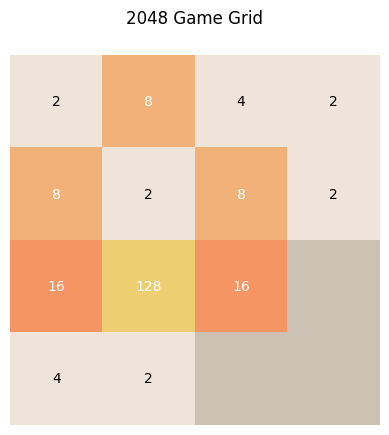

Score to beat: 6000
Dorment model score: 591.6999999999998


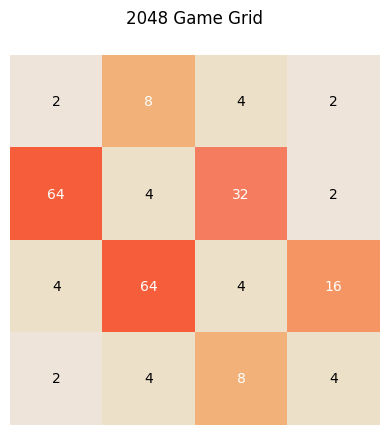

Score to beat: 6000
Dorment model score: 779.2


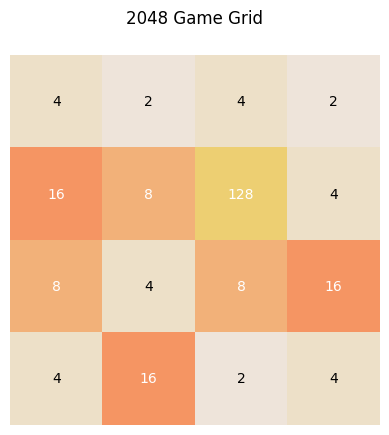

Score to beat: 6000
Dorment model score: 744.0


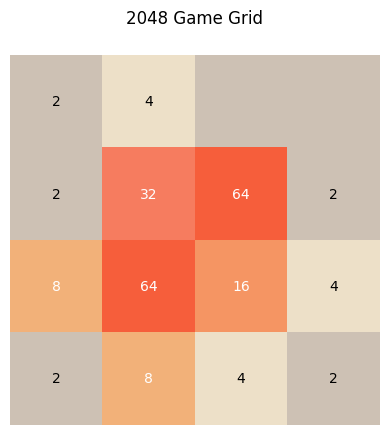

Score to beat: 6000
Dorment model score: 742.3


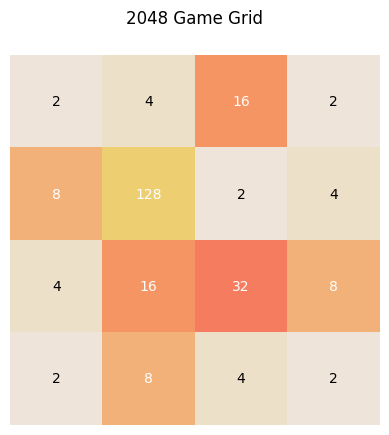

Score to beat: 6000
Dorment model score: 791.7


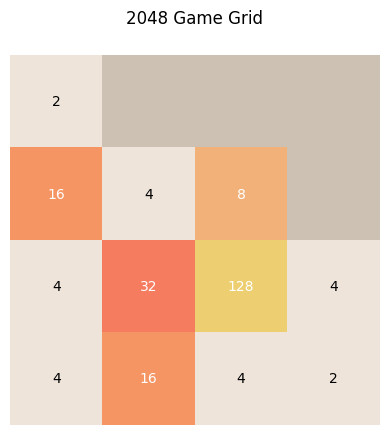

Score to beat: 6000
Dorment model score: 763.9


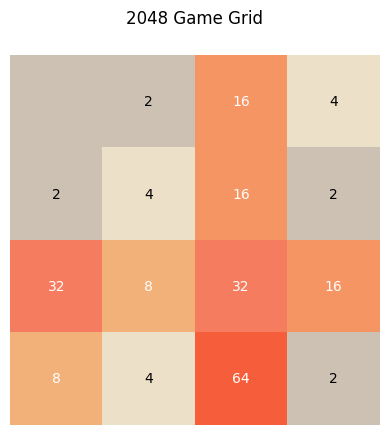

Score to beat: 6000
Dorment model score: 644.8


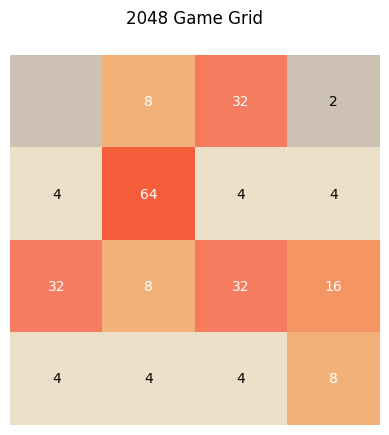

Score to beat: 6000
Dorment model score: 728.9


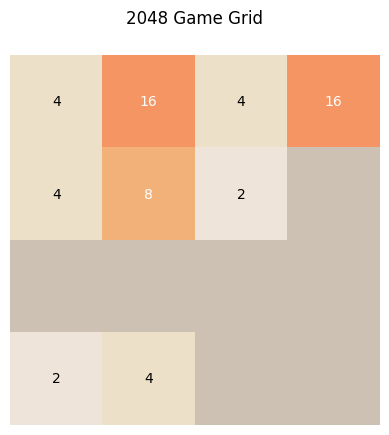

Score to beat: 6000
Dorment model score: 113.70000000000002


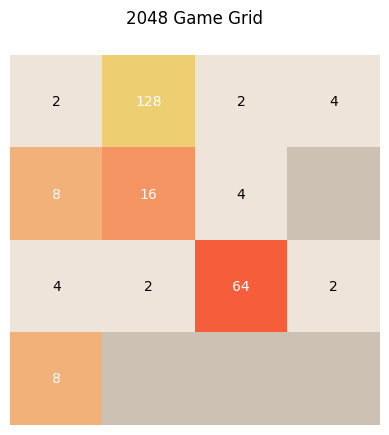

Score to beat: 6000
Dorment model score: 791.4999999999999


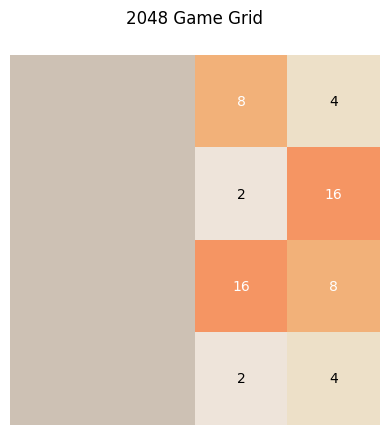

Score to beat: 6000
Dorment model score: 150.70000000000002


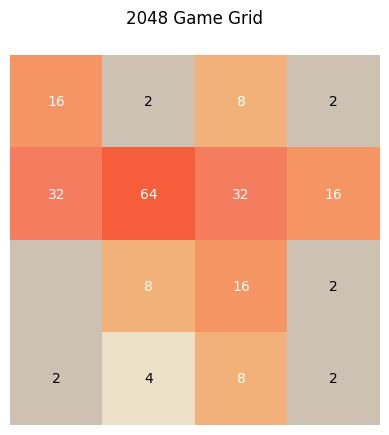

Score to beat: 6000
Dorment model score: 734.4999999999999


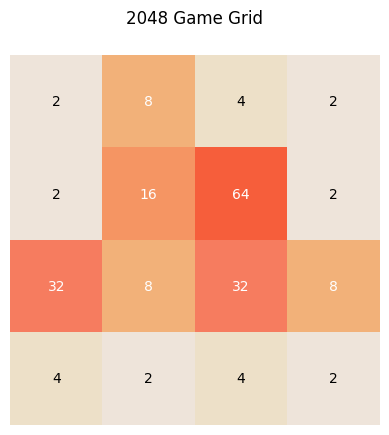

Score to beat: 6000
Dorment model score: 616.9999999999999


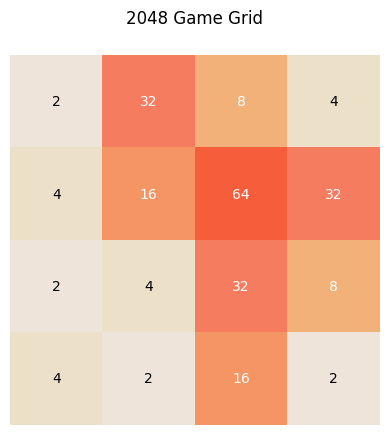

Score to beat: 6000
Dorment model score: 806.6


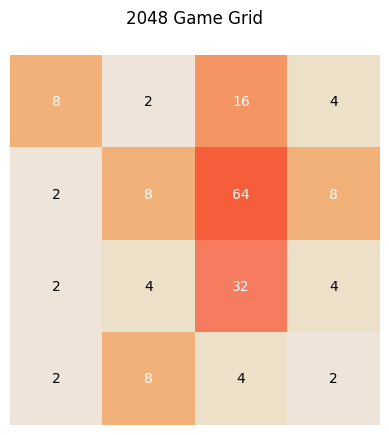

Score to beat: 6000
Dorment model score: 473.20000000000005


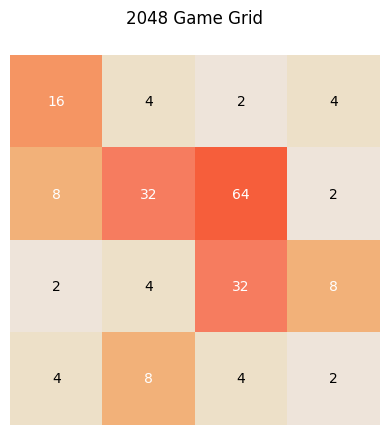

Score to beat: 6000
Dorment model score: 594.4


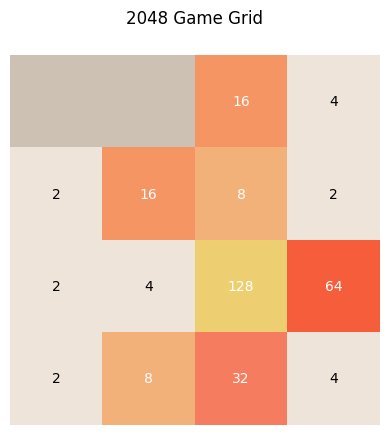

Score to beat: 6000
Dorment model score: 980.8999999999999


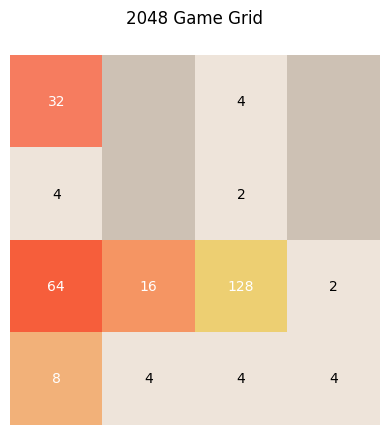

Score to beat: 6000
Dorment model score: 983.5999999999999


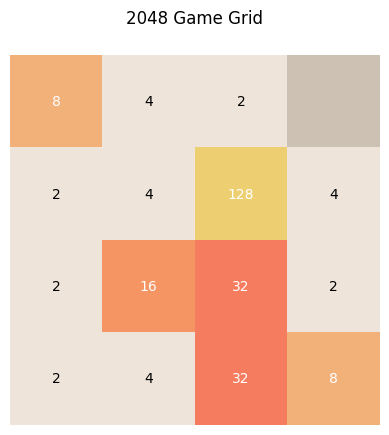

Score to beat: 6000
Dorment model score: 800.8


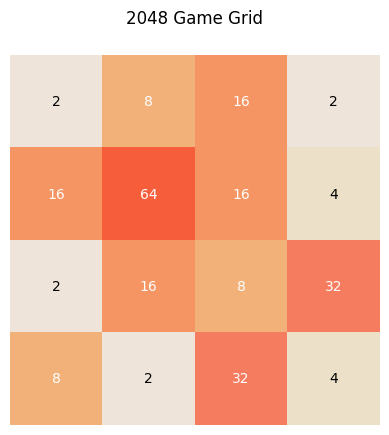

Score to beat: 6000
Dorment model score: 735.6999999999999


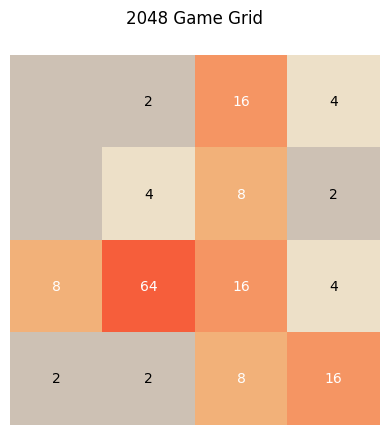

Score to beat: 6000
Dorment model score: 451.99999999999994


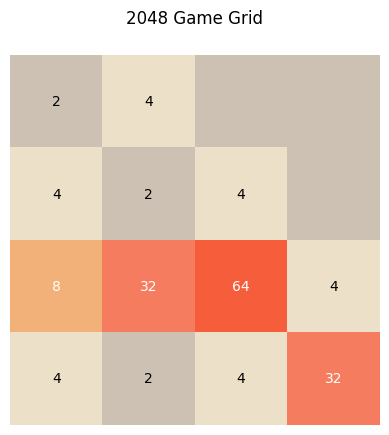

Score to beat: 6000
Dorment model score: 500.6


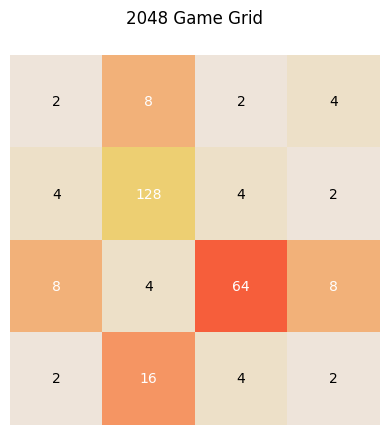

Score to beat: 6000
Dorment model score: 800.8


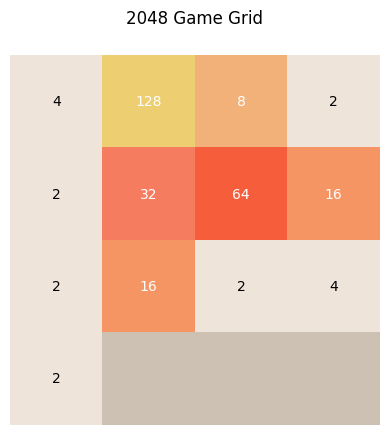

Score to beat: 6000
Dorment model score: 984.5999999999999


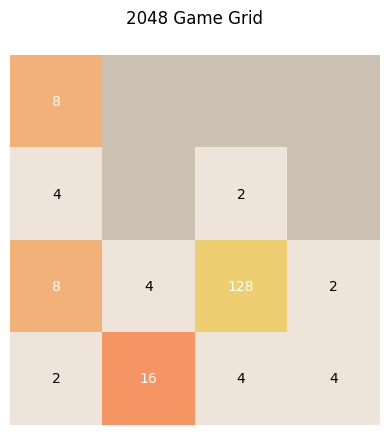

Score to beat: 6000
Dorment model score: 608.1999999999999


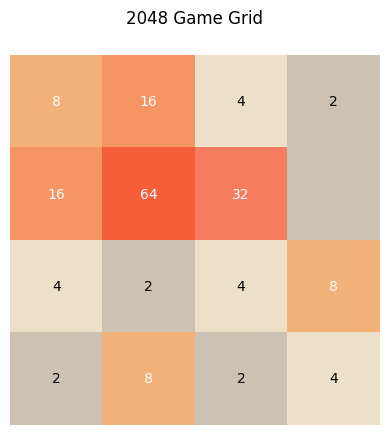

Score to beat: 6000
Dorment model score: 496.1


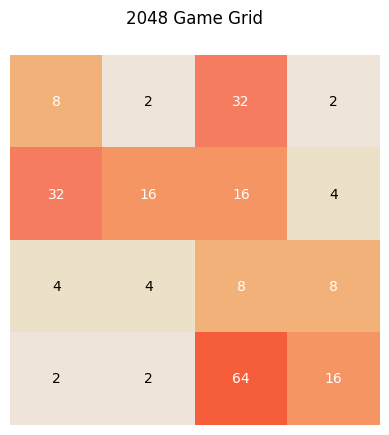

Score to beat: 6000
Dorment model score: 705.8


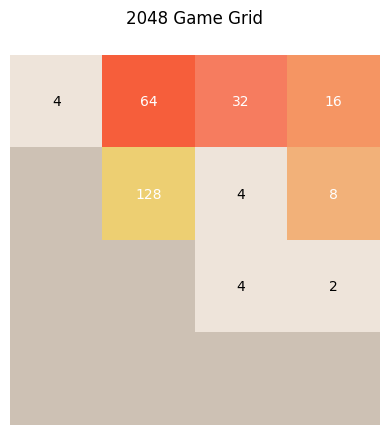

Score to beat: 6000
Dorment model score: 886.1999999999999


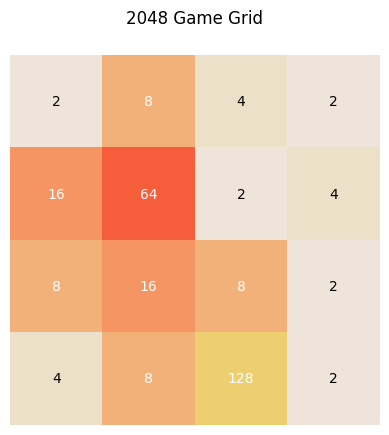

Score to beat: 6000
Dorment model score: 973.5999999999999


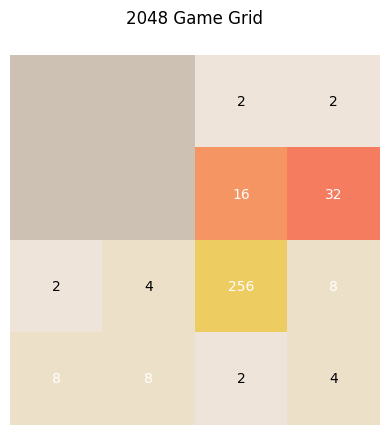

Score to beat: 6000
Dorment model score: 1188.3999999999999


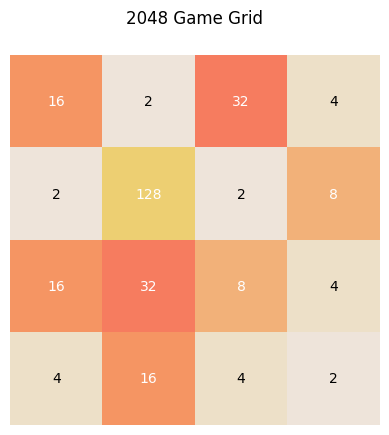

Score to beat: 6000
Dorment model score: 976.9


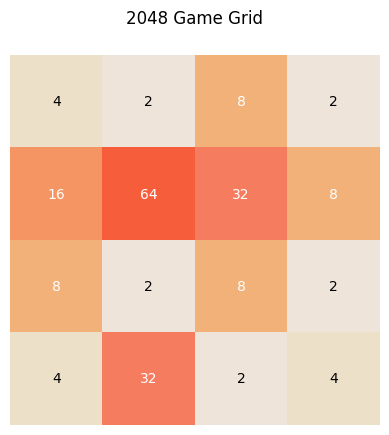

Score to beat: 6000
Dorment model score: 598.2


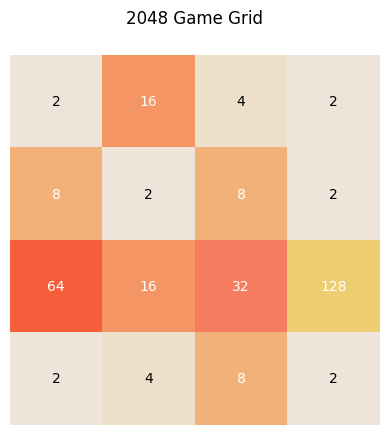

Score to beat: 6000
Dorment model score: 1069.6999999999998


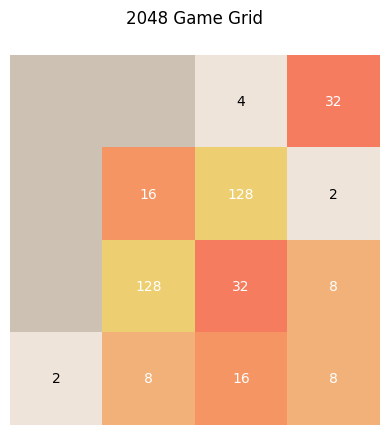

Score to beat: 6000
Dorment model score: 1356.4


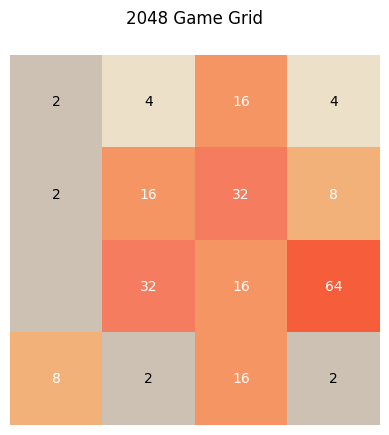

Score to beat: 6000
Dorment model score: 724.2


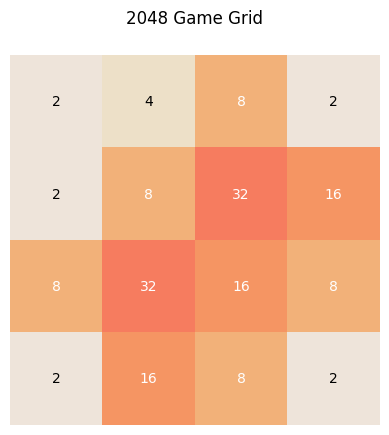

Score to beat: 6000
Dorment model score: 560.0


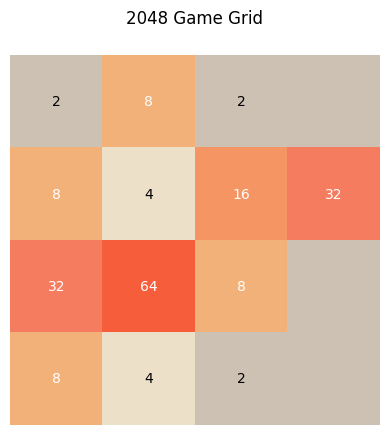

Score to beat: 6000
Dorment model score: 551.1999999999999


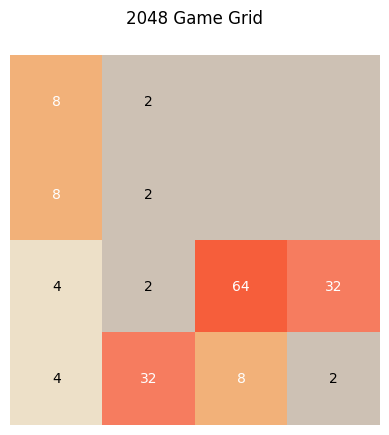

Score to beat: 6000
Dorment model score: 538.3


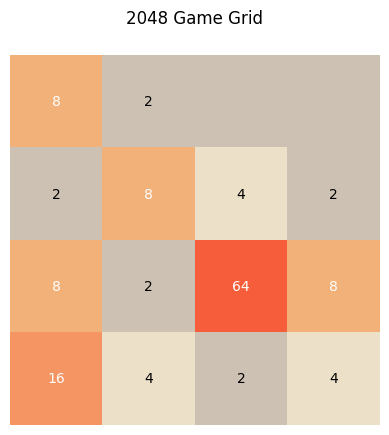

Score to beat: 6000
Dorment model score: 390.1


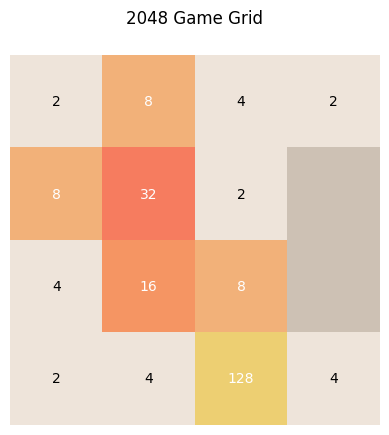

Score to beat: 6000
Dorment model score: 704.3999999999999


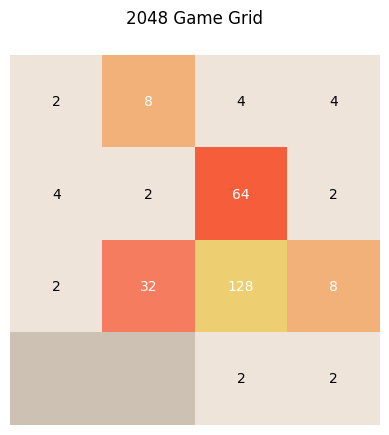

Score to beat: 6000
Dorment model score: 837.8


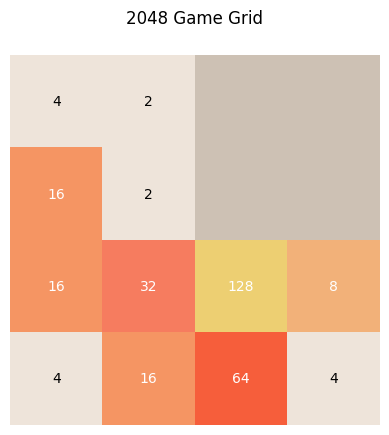

Score to beat: 6000
Dorment model score: 1023.6999999999998


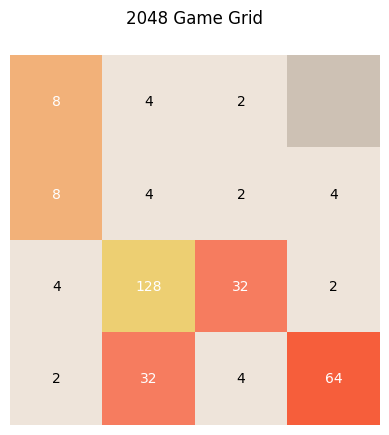

Score to beat: 6000
Dorment model score: 1060.7


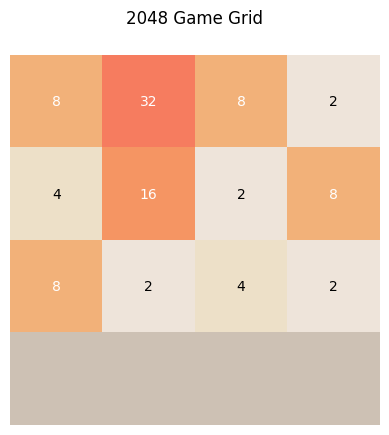

Score to beat: 6000
Dorment model score: 268.9


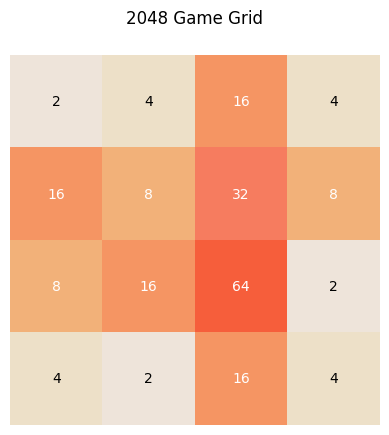

Score to beat: 6000
Dorment model score: 637.0


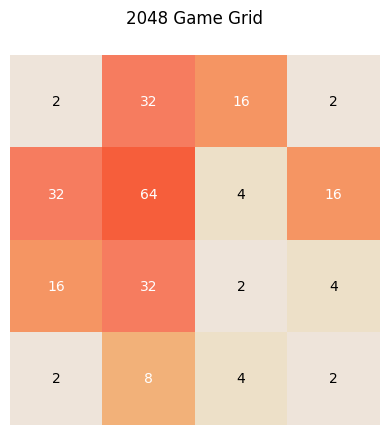

Score to beat: 6000
Dorment model score: 804.1999999999998


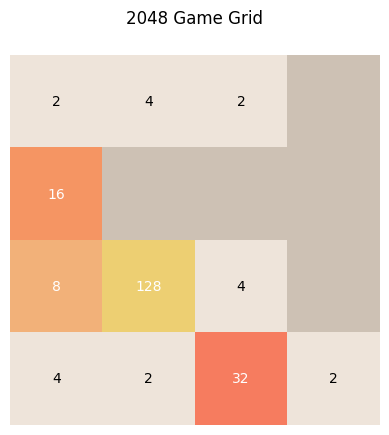

Score to beat: 6000
Dorment model score: 692.0


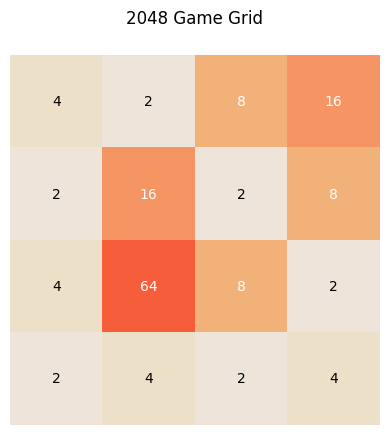

Score to beat: 6000
Dorment model score: 402.8


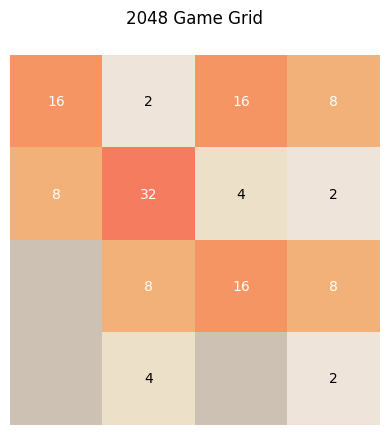

Score to beat: 6000
Dorment model score: 366.4


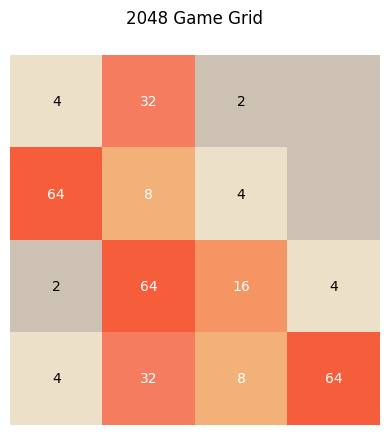

Score to beat: 6000
Dorment model score: 1063.6999999999998


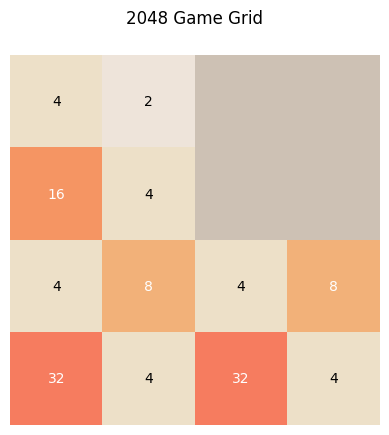

Score to beat: 6000
Dorment model score: 343.8


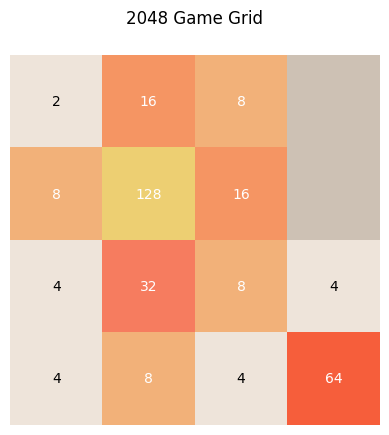

Score to beat: 6000
Dorment model score: 1088.1999999999998


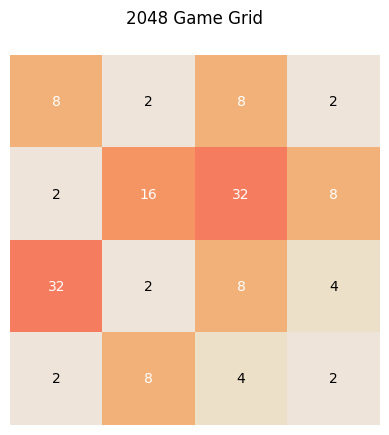

Score to beat: 6000
Dorment model score: 467.20000000000005


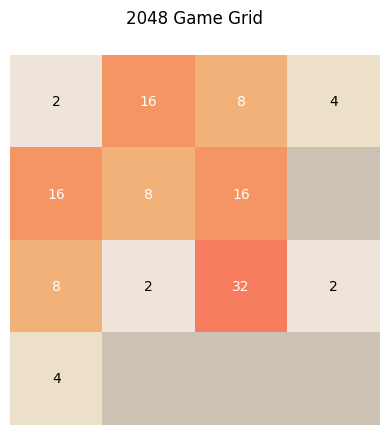

Score to beat: 6000
Dorment model score: 318.29999999999995


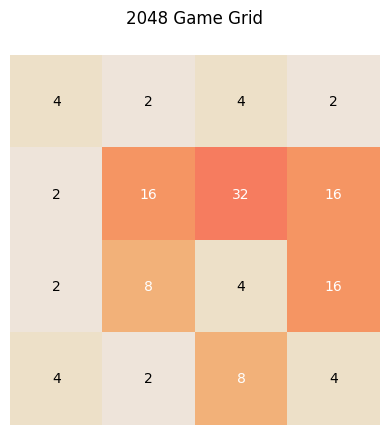

Score to beat: 6000
Dorment model score: 355.6


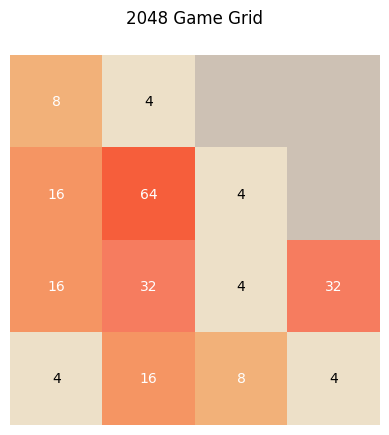

Score to beat: 6000
Dorment model score: 720.6


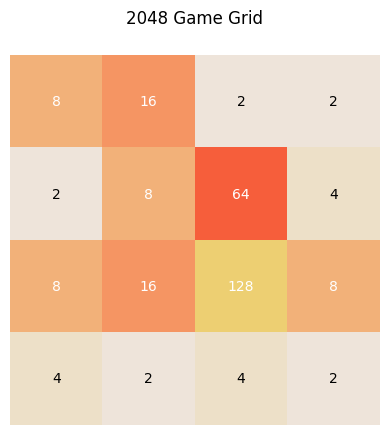

Score to beat: 6000
Dorment model score: 976.3


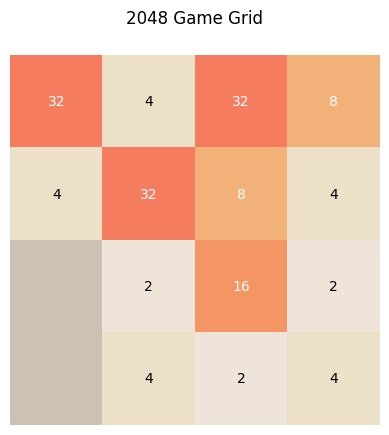

Score to beat: 6000
Dorment model score: 461.0


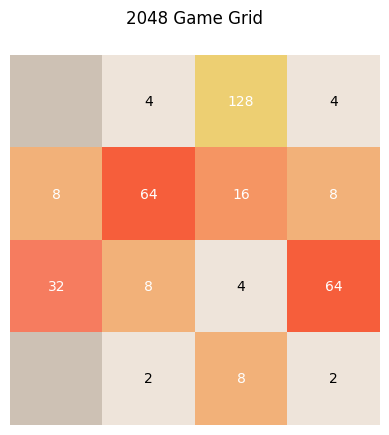

Score to beat: 6000
Dorment model score: 1257.2


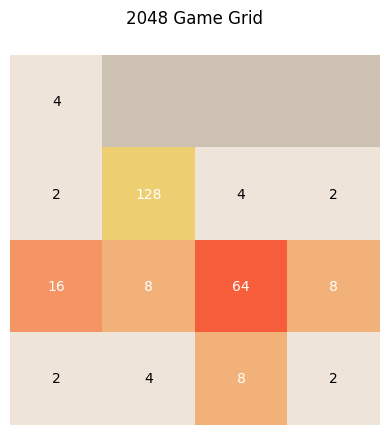

Score to beat: 6000
Dorment model score: 877.0


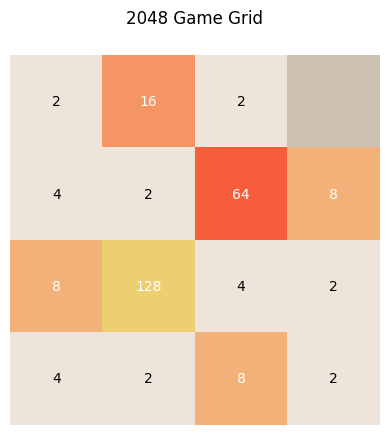

Score to beat: 6000
Dorment model score: 886.8
TARGET UPDATED


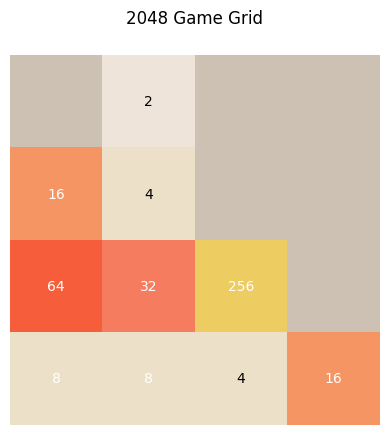

Score to beat: 6000
Dorment model score: 1566.3999999999999


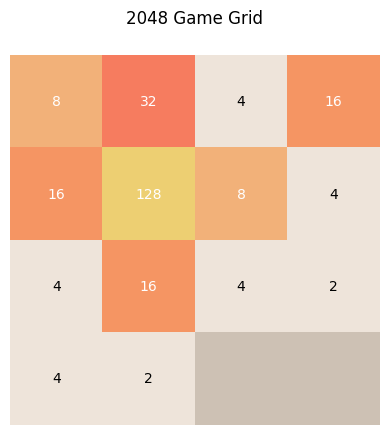

Score to beat: 6000
Dorment model score: 854.0


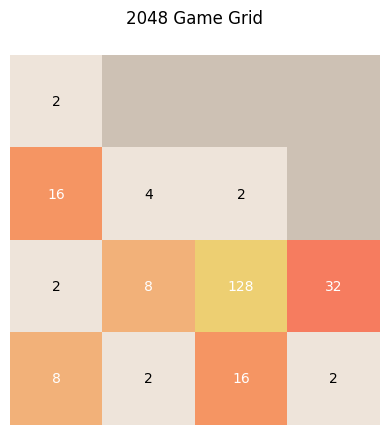

Score to beat: 6000
Dorment model score: 803.4999999999998


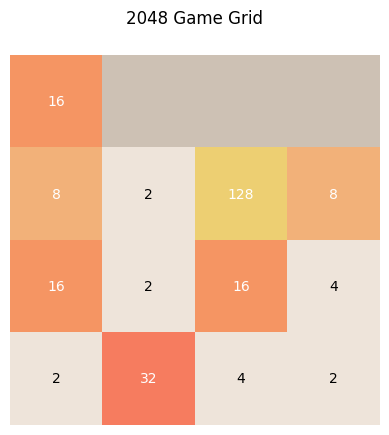

Score to beat: 6000
Dorment model score: 799.7


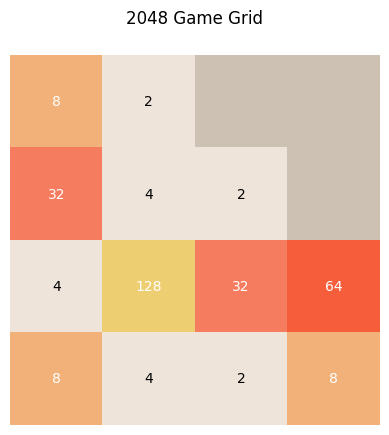

Score to beat: 6000
Dorment model score: 998.4000000000001


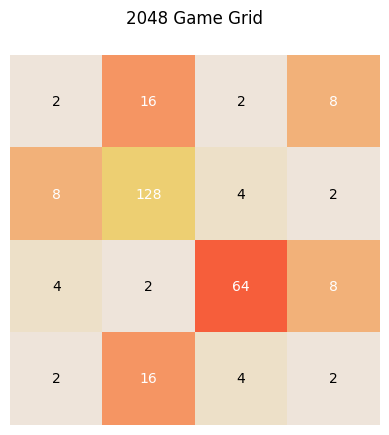

Score to beat: 6000
Dorment model score: 853.9999999999999


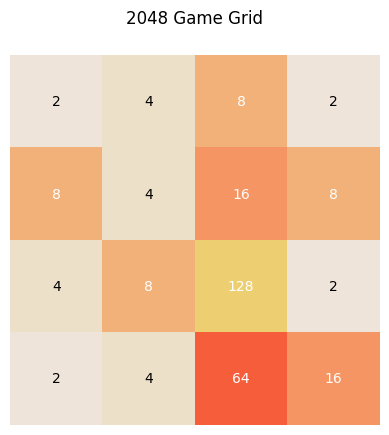

Score to beat: 6000
Dorment model score: 975.1


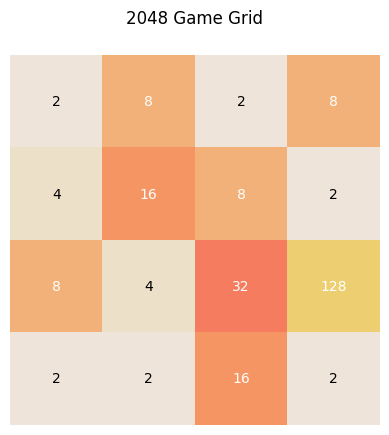

Score to beat: 6000
Dorment model score: 804.4999999999999


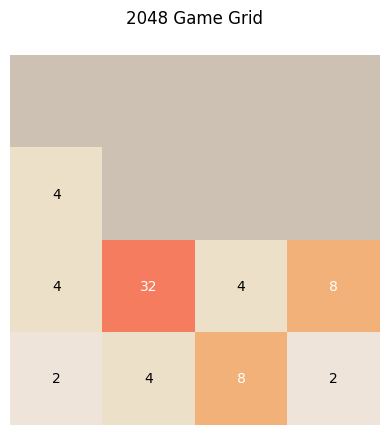

Score to beat: 6000
Dorment model score: 163.8


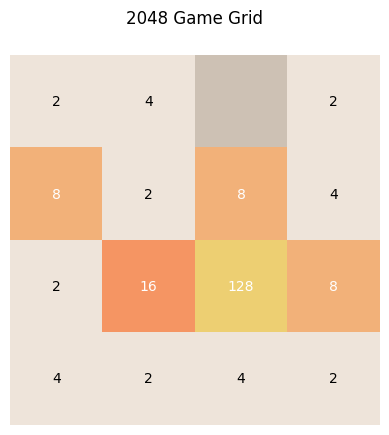

Score to beat: 6000
Dorment model score: 656.5


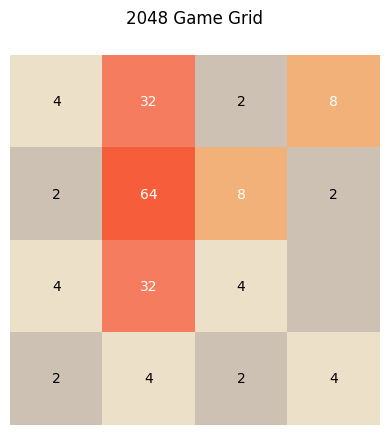

Score to beat: 6000
Dorment model score: 510.0999999999999


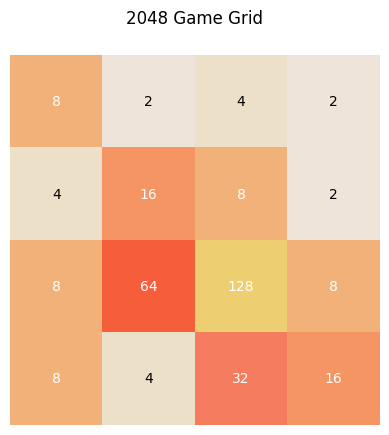

Score to beat: 6000
Dorment model score: 1078.3999999999999


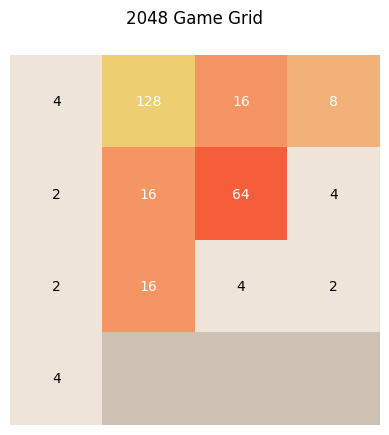

Score to beat: 6000
Dorment model score: 921.7


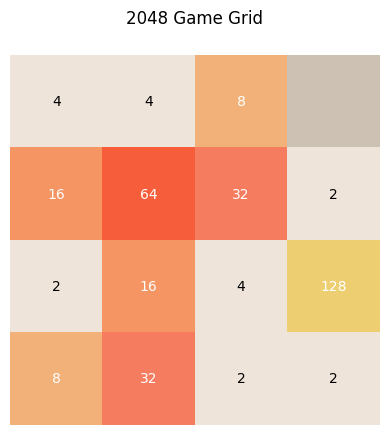

Score to beat: 6000
Dorment model score: 1047.4999999999995


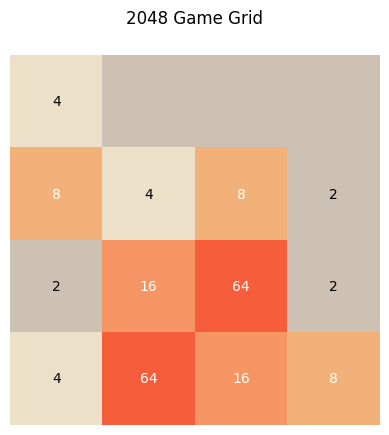

Score to beat: 6000
Dorment model score: 665.1


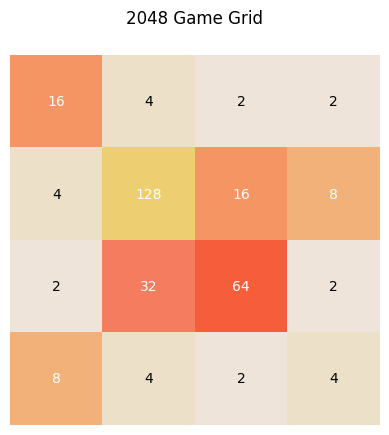

Score to beat: 6000
Dorment model score: 1059.0


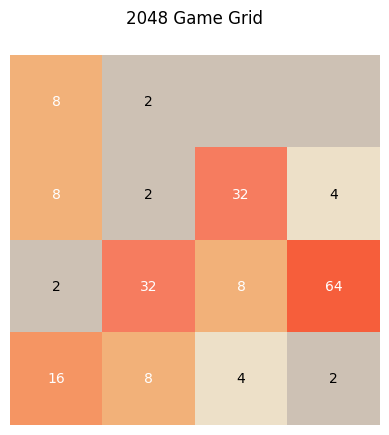

Score to beat: 6000
Dorment model score: 625.1


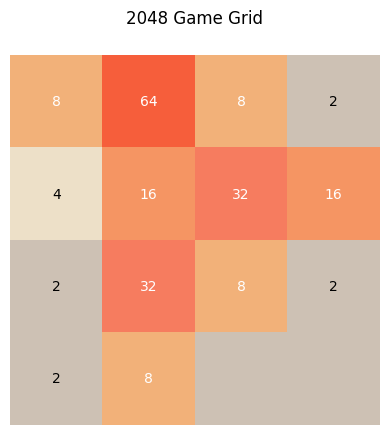

Score to beat: 6000
Dorment model score: 643.2


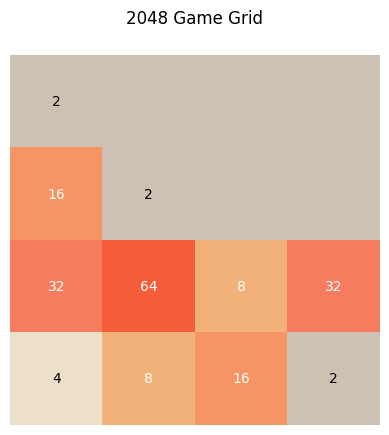

Score to beat: 6000
Dorment model score: 648.2999999999998


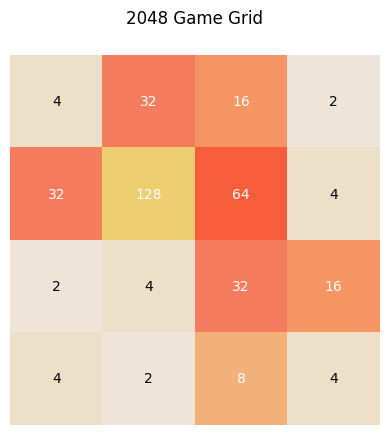

Score to beat: 6000
Dorment model score: 1246.1999999999998


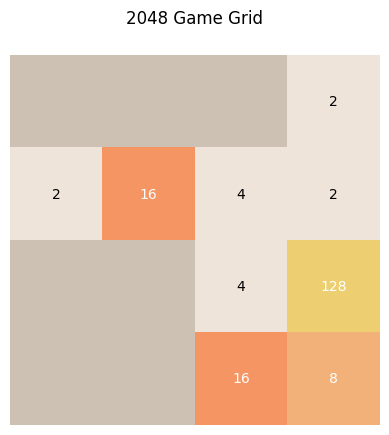

Score to beat: 6000
Dorment model score: 623.1999999999999


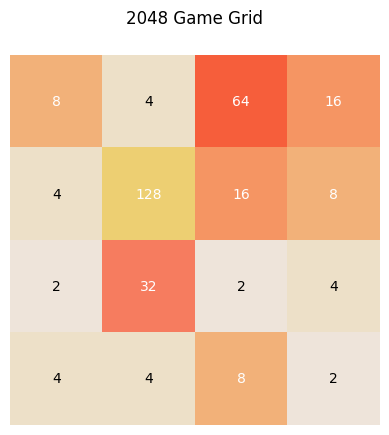

Score to beat: 6000
Dorment model score: 1134.1000000000001


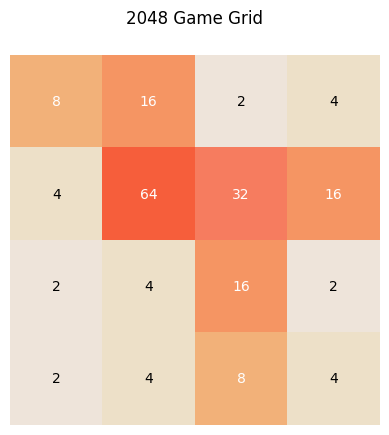

Score to beat: 6000
Dorment model score: 634.6


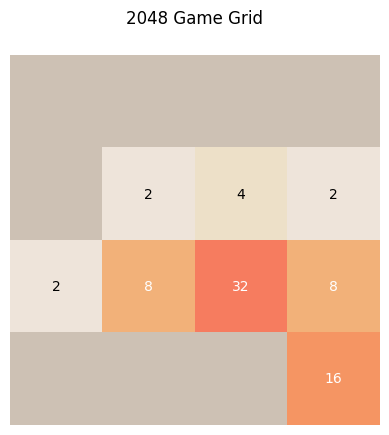

Score to beat: 6000
Dorment model score: 196.39999999999998


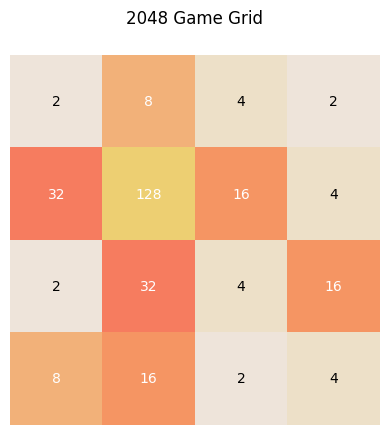

Score to beat: 6000
Dorment model score: 1015.1999999999998


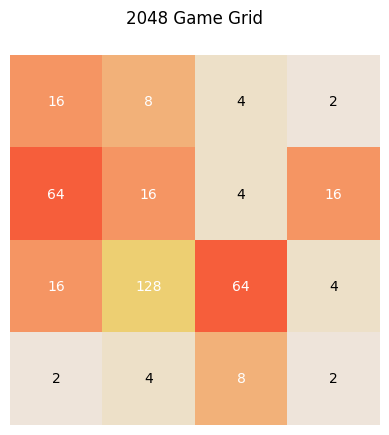

Score to beat: 6000
Dorment model score: 1280.2999999999997


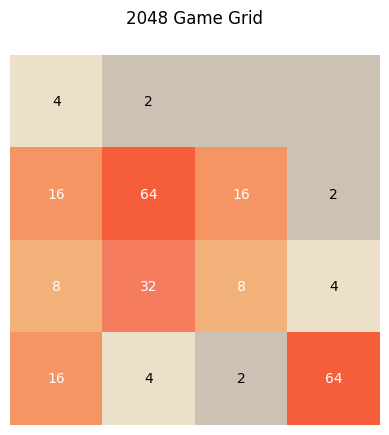

Score to beat: 6000
Dorment model score: 817.8000000000001


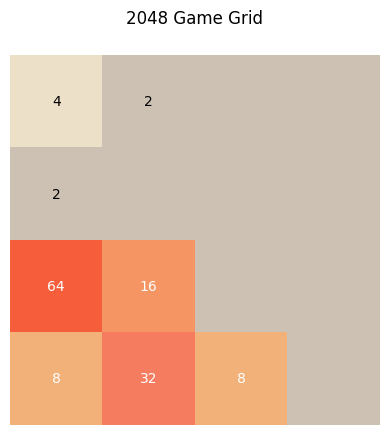

Score to beat: 6000
Dorment model score: 408.7


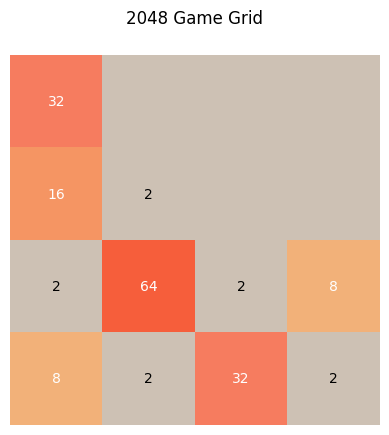

Score to beat: 6000
Dorment model score: 600.4999999999998


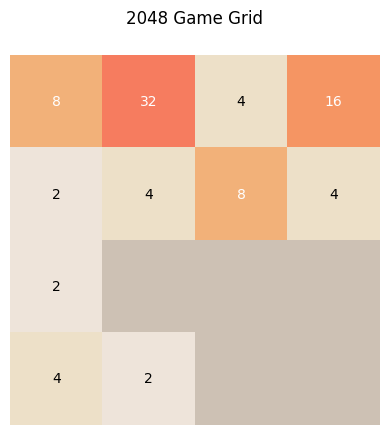

Score to beat: 6000
Dorment model score: 237.7


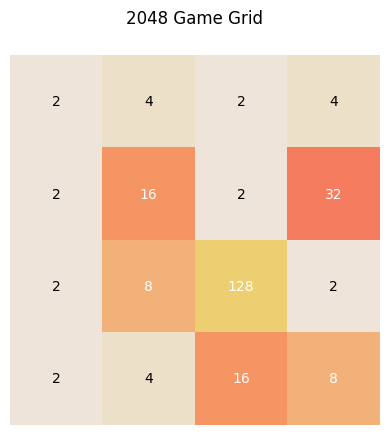

Score to beat: 6000
Dorment model score: 844.5999999999999


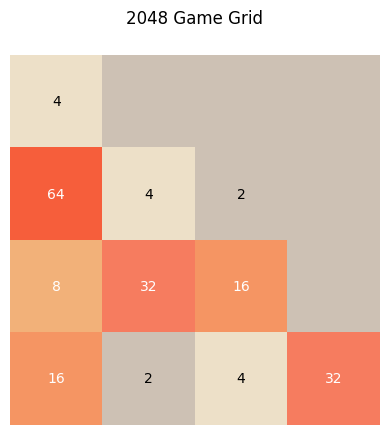

Score to beat: 6000
Dorment model score: 673.9


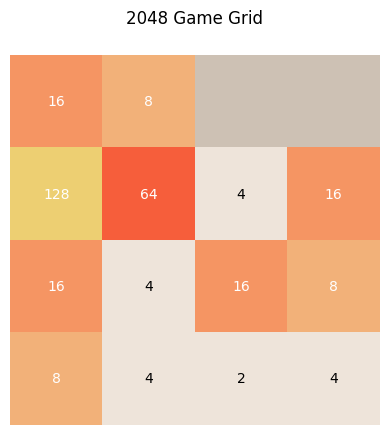

Score to beat: 6000
Dorment model score: 1016.7999999999997


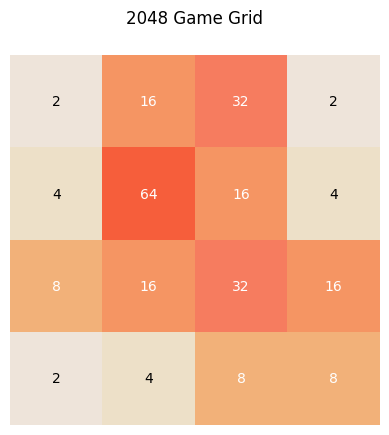

Score to beat: 6000
Dorment model score: 808.4


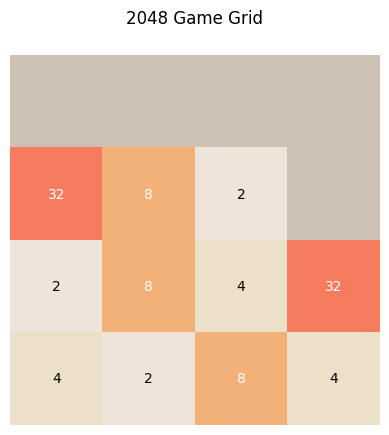

Score to beat: 6000
Dorment model score: 296.09999999999997


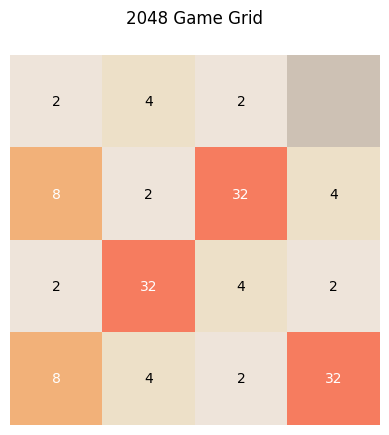

Score to beat: 6000
Dorment model score: 418.0


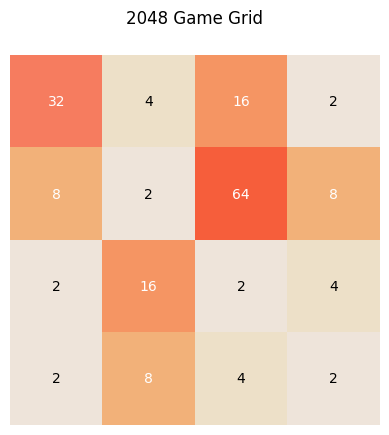

Score to beat: 6000
Dorment model score: 586.5


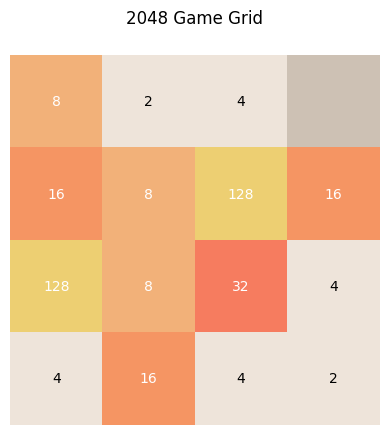

Score to beat: 6000
Dorment model score: 1388.3


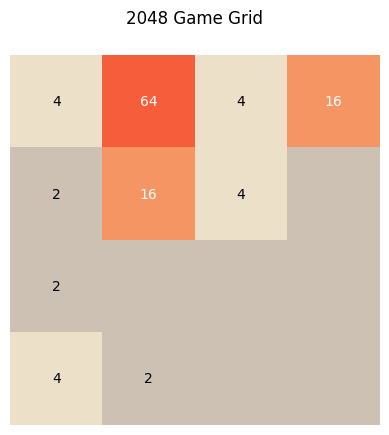

Score to beat: 6000
Dorment model score: 382.5


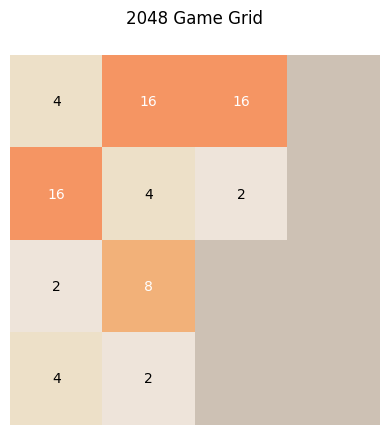

Score to beat: 6000
Dorment model score: 211.7


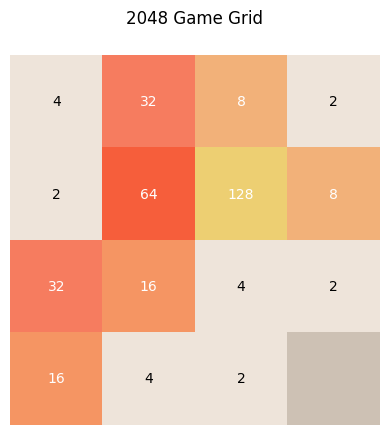

Score to beat: 6000
Dorment model score: 1219.3999999999999


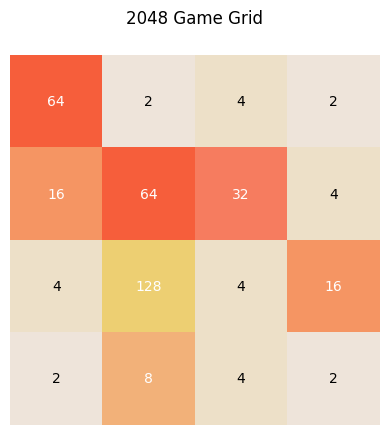

Score to beat: 6000
Dorment model score: 1272.5


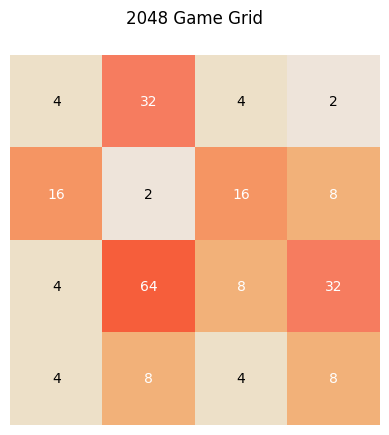

Score to beat: 6000
Dorment model score: 697.3


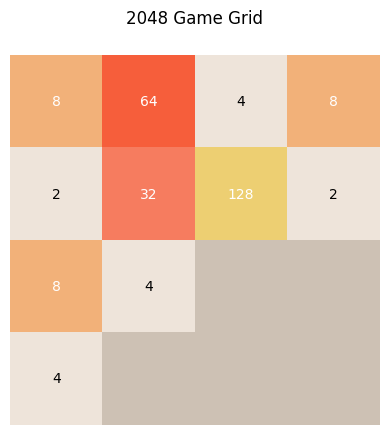

Score to beat: 6000
Dorment model score: 921.5999999999999


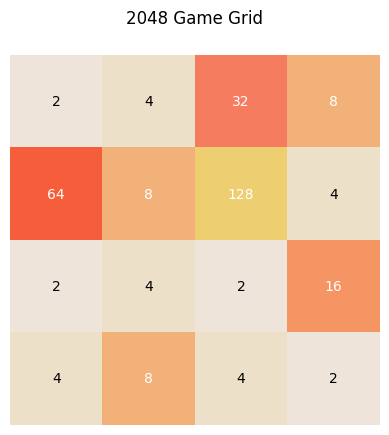

Score to beat: 6000
Dorment model score: 1074.1000000000001


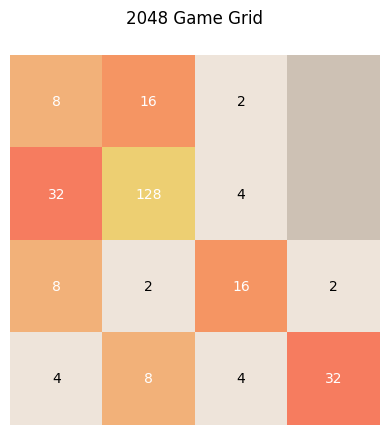

Score to beat: 6000
Dorment model score: 915.1


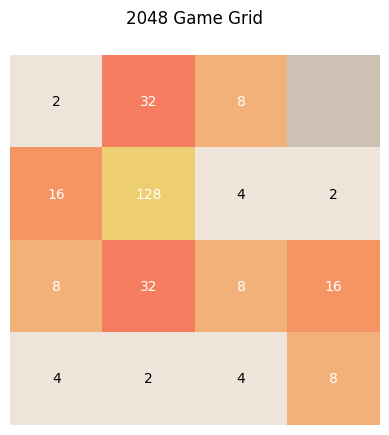

Score to beat: 6000
Dorment model score: 856.4999999999999


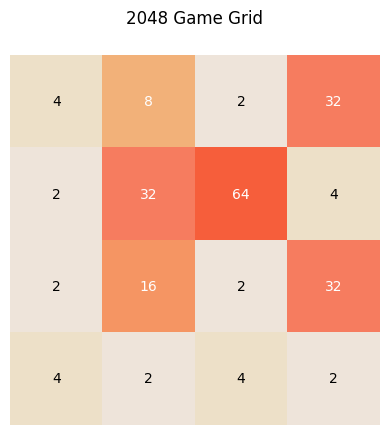

Score to beat: 6000
Dorment model score: 656.0


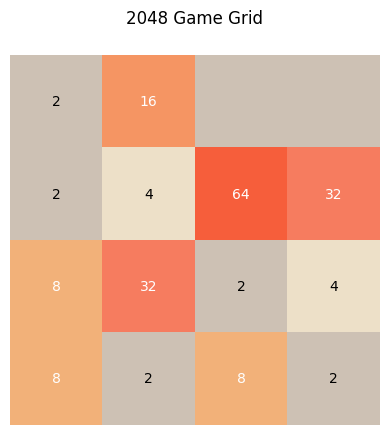

Score to beat: 6000
Dorment model score: 572.0000000000001


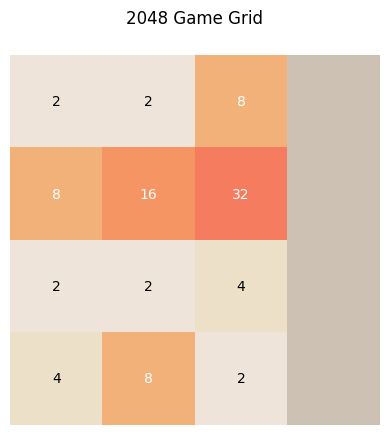

Score to beat: 6000
Dorment model score: 251.79999999999995


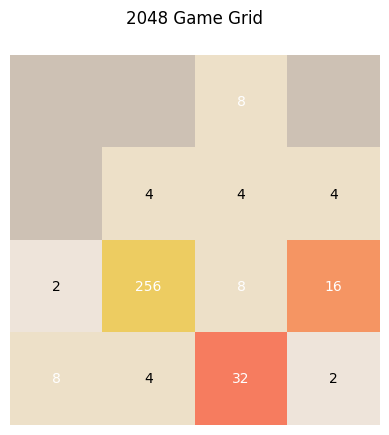

Score to beat: 6000
Dorment model score: 1236.1


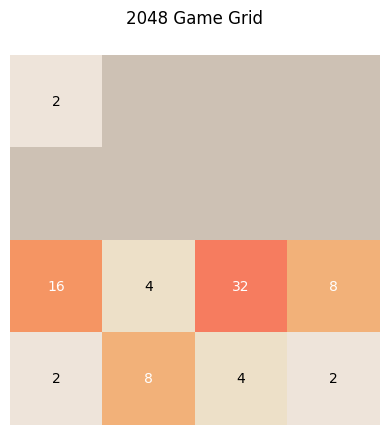

Score to beat: 6000
Dorment model score: 195.7


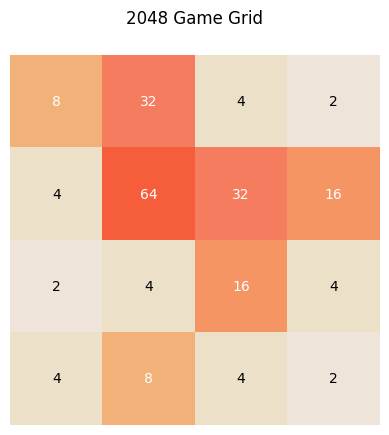

Score to beat: 6000
Dorment model score: 613.3000000000001


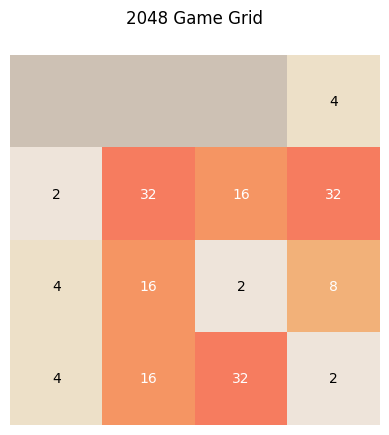

Score to beat: 6000
Dorment model score: 560.1999999999999


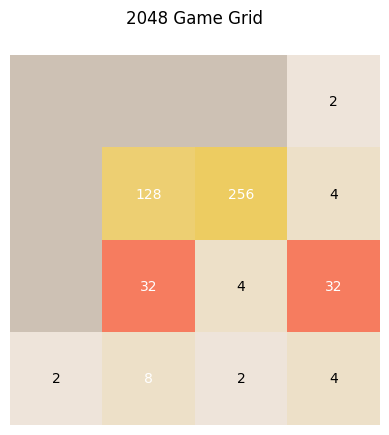

Score to beat: 6000
Dorment model score: 1757.8999999999994


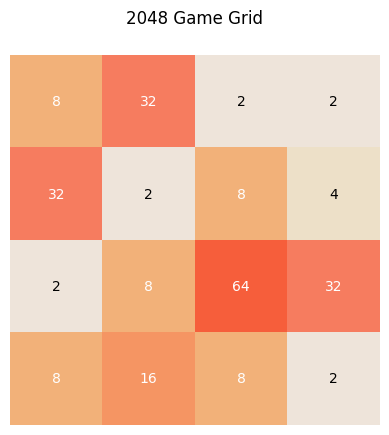

Score to beat: 6000
Dorment model score: 811.9000000000001


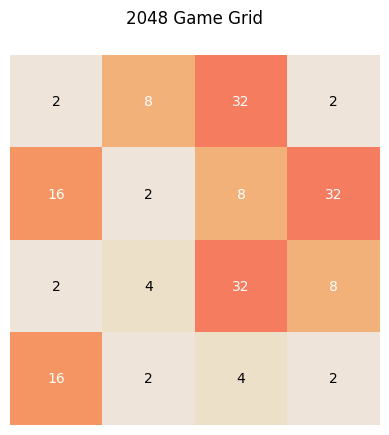

Score to beat: 6000
Dorment model score: 542.0999999999999


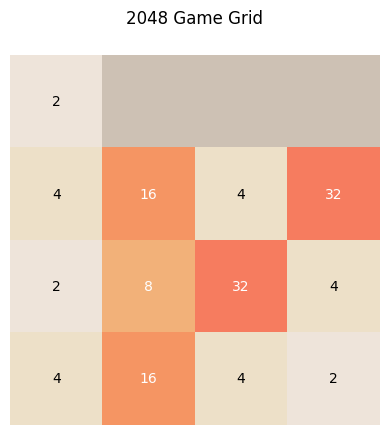

Score to beat: 6000
Dorment model score: 399.7


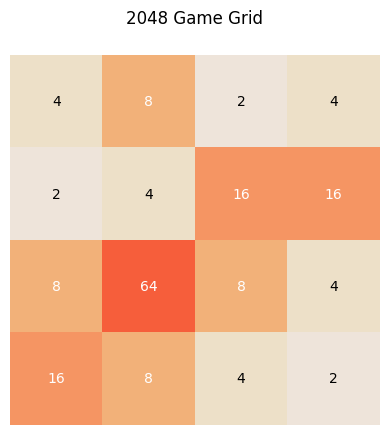

Score to beat: 6000
Dorment model score: 498.0999999999999


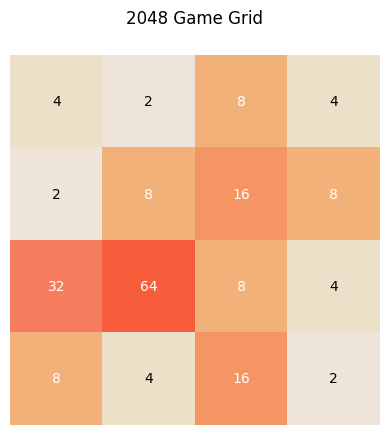

Score to beat: 6000
Dorment model score: 587.8


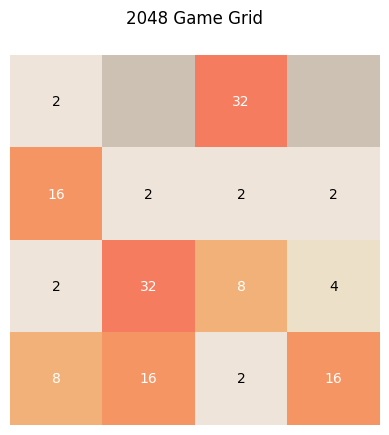

Score to beat: 6000
Dorment model score: 439.9


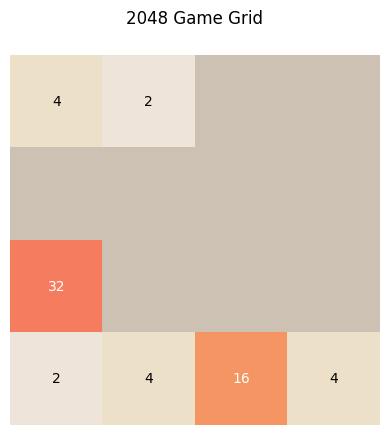

Score to beat: 6000
Dorment model score: 176.79999999999998


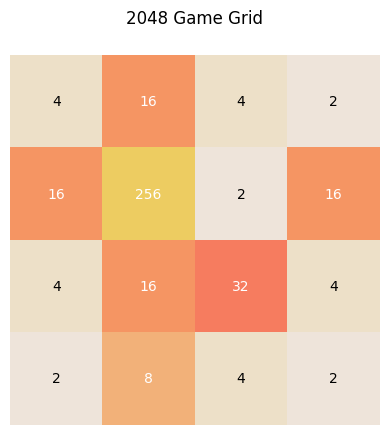

Score to beat: 6000
Dorment model score: 1372.6999999999996


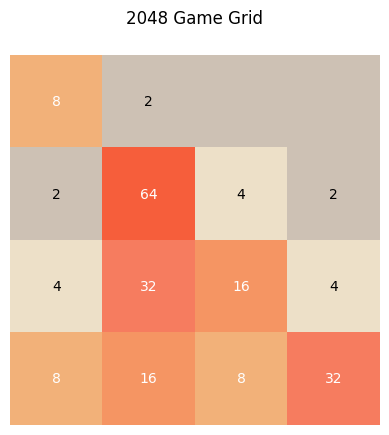

Score to beat: 6000
Dorment model score: 645.6


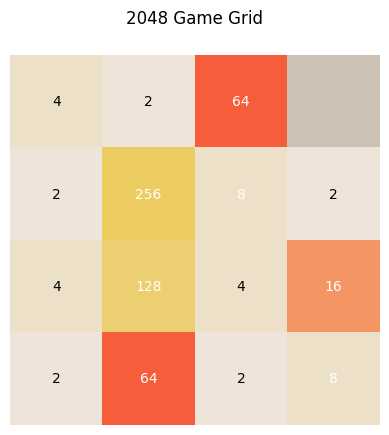

Score to beat: 6000
Dorment model score: 2075.9


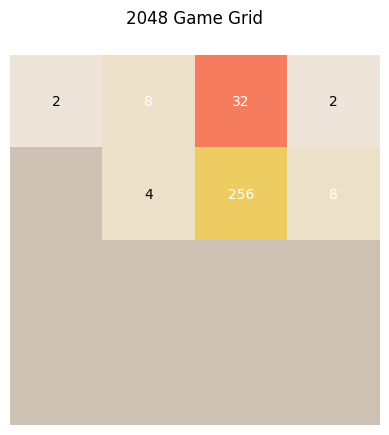

Score to beat: 6000
Dorment model score: 1147.7


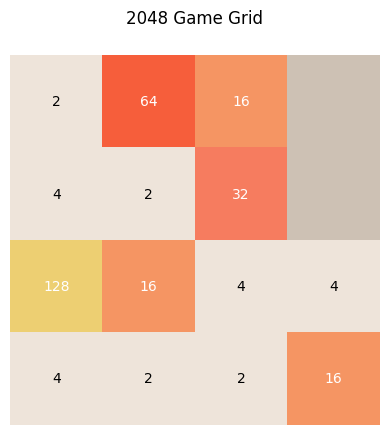

Score to beat: 6000
Dorment model score: 1000.4000000000001
TARGET UPDATED


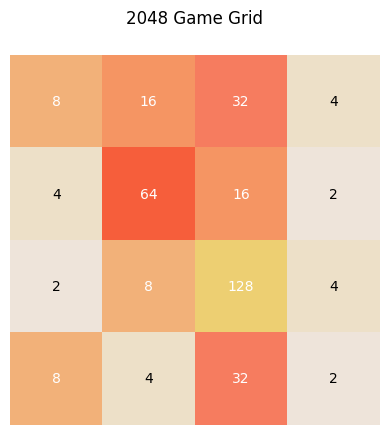

Score to beat: 6000
Dorment model score: 1190.7


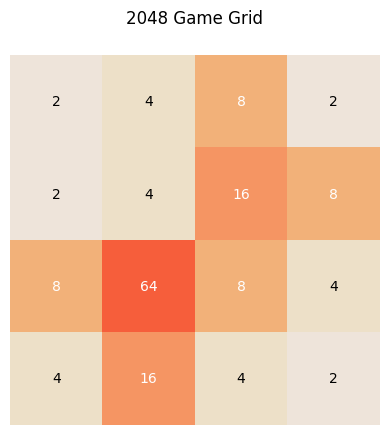

Score to beat: 6000
Dorment model score: 530.9000000000001


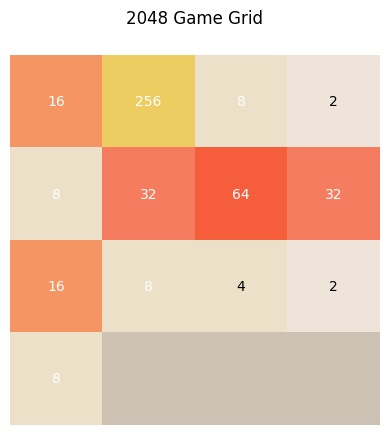

Score to beat: 6000
Dorment model score: 1729.6000000000001


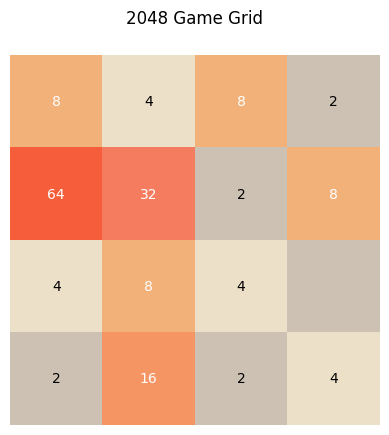

Score to beat: 6000
Dorment model score: 549.8


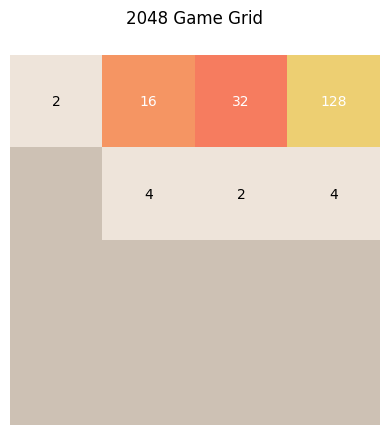

Score to beat: 6000
Dorment model score: 700.3999999999999


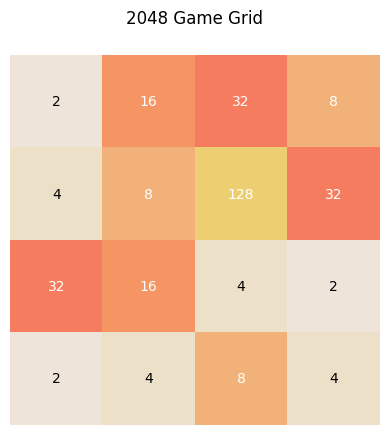

Score to beat: 6000
Dorment model score: 1046.7999999999997


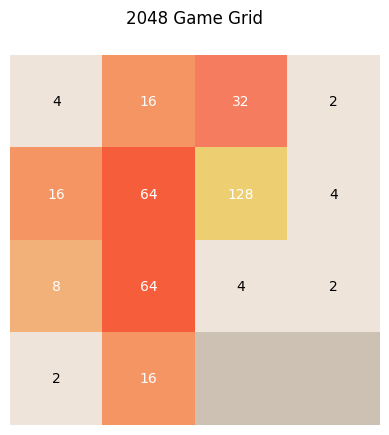

Score to beat: 6000
Dorment model score: 1316.1000000000001


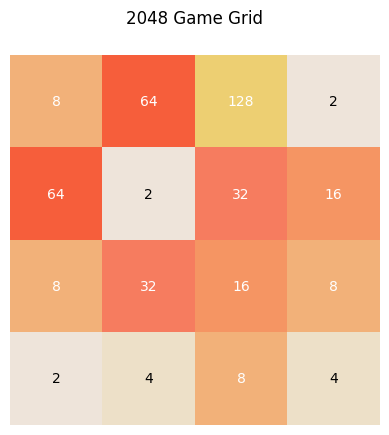

Score to beat: 6000
Dorment model score: 1463.7000000000005


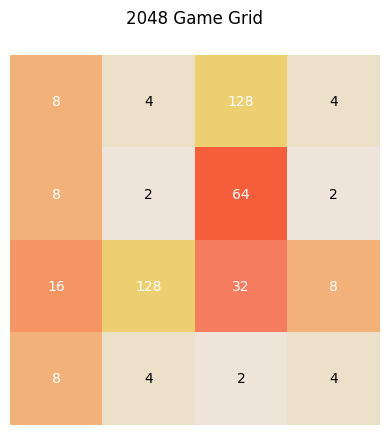

Score to beat: 6000
Dorment model score: 1501.1000000000001


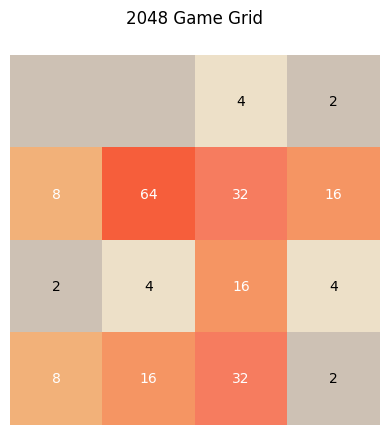

Score to beat: 6000
Dorment model score: 688.2


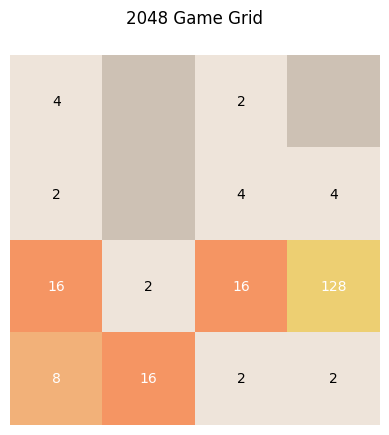

Score to beat: 6000
Dorment model score: 718.2999999999998


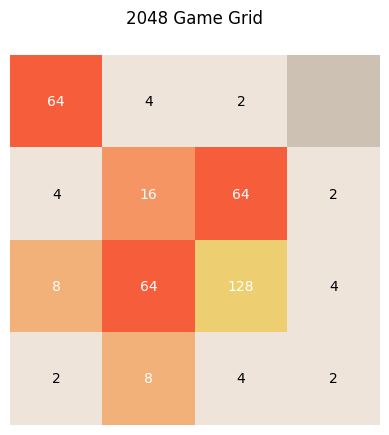

Score to beat: 6000
Dorment model score: 1354.6999999999998


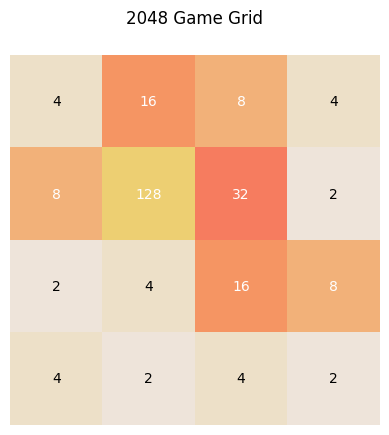

Score to beat: 6000
Dorment model score: 788.4999999999999


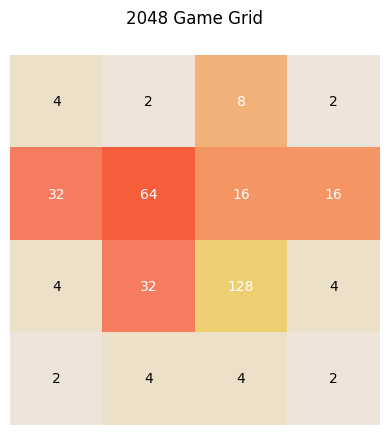

Score to beat: 6000
Dorment model score: 1121.0


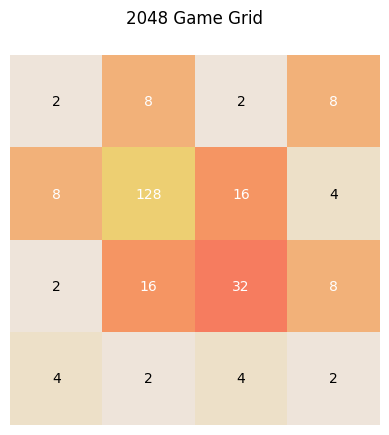

Score to beat: 6000
Dorment model score: 884.9999999999999


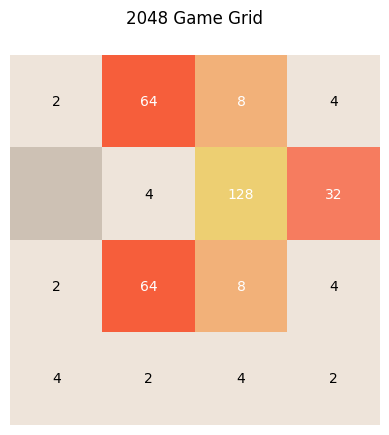

Score to beat: 6000
Dorment model score: 1126.9999999999998


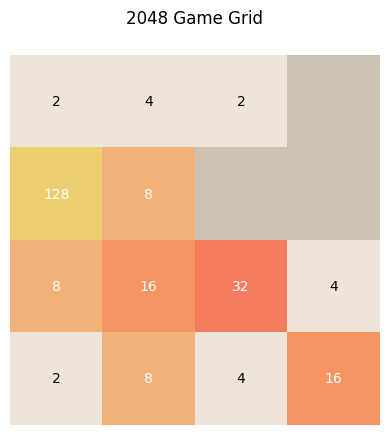

Score to beat: 6000
Dorment model score: 853.9


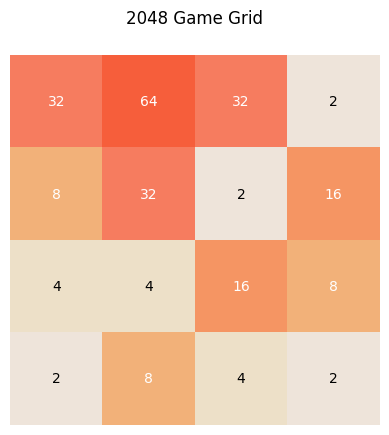

Score to beat: 6000
Dorment model score: 800.7


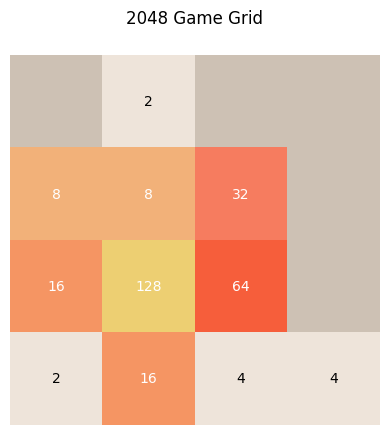

Score to beat: 6000
Dorment model score: 1038.1999999999998


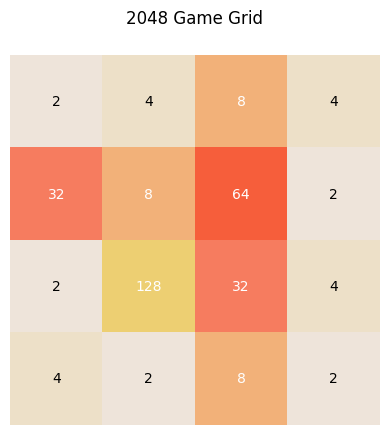

Score to beat: 6000
Dorment model score: 1115.3999999999999


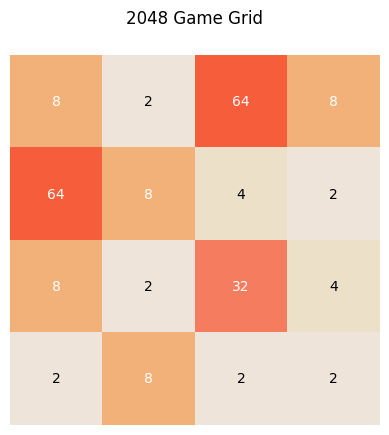

Score to beat: 6000
Dorment model score: 728.4999999999999


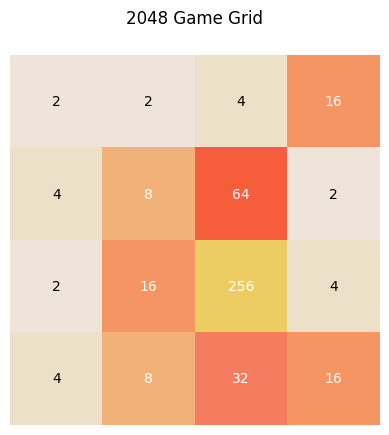

Score to beat: 6000
Dorment model score: 1551.7


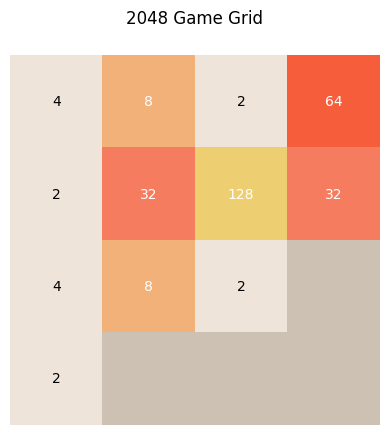

Score to beat: 6000
Dorment model score: 1045.1


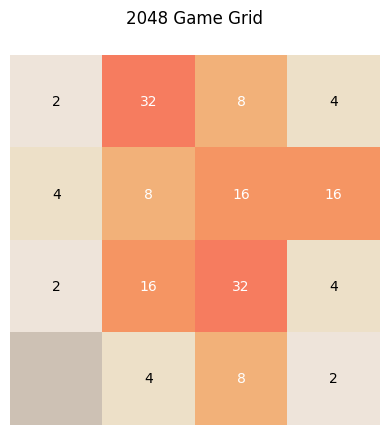

Score to beat: 6000
Dorment model score: 490.5


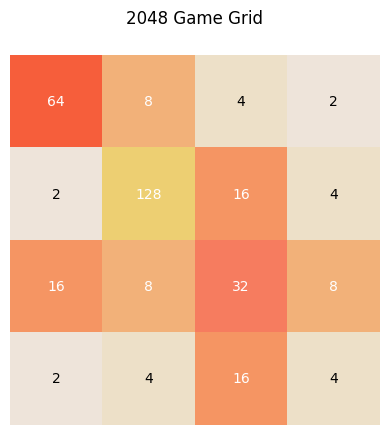

Score to beat: 6000
Dorment model score: 1243.6000000000001


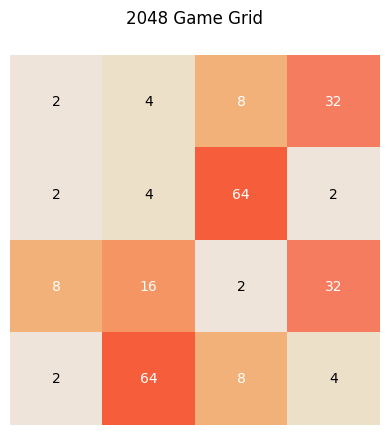

Score to beat: 6000
Dorment model score: 888.9


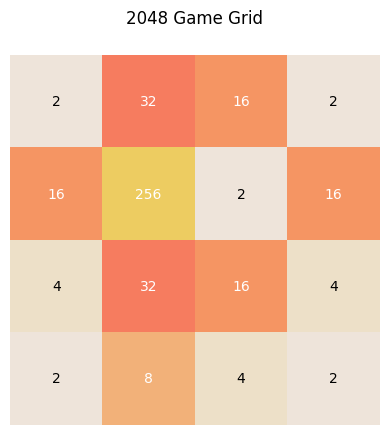

Score to beat: 6000
Dorment model score: 1530.4999999999995


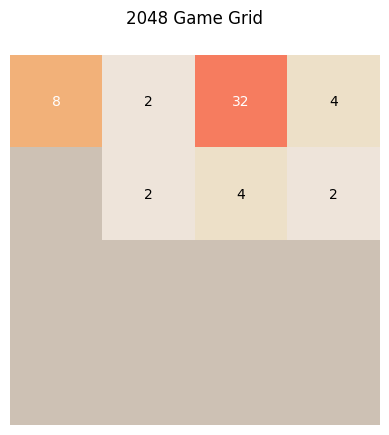

Score to beat: 6000
Dorment model score: 116.39999999999998


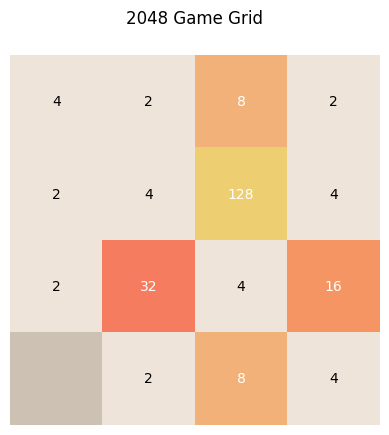

Score to beat: 6000
Dorment model score: 748.8999999999999


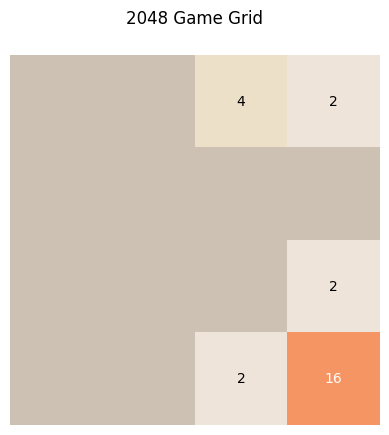

Score to beat: 6000
Dorment model score: 22.799999999999997


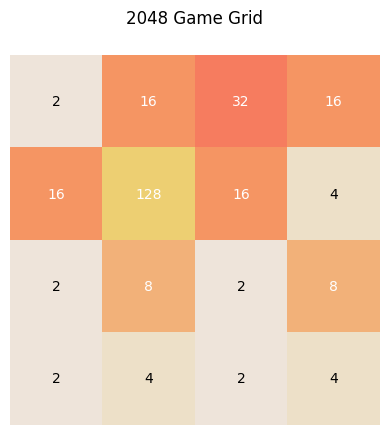

Score to beat: 6000
Dorment model score: 900.1999999999998


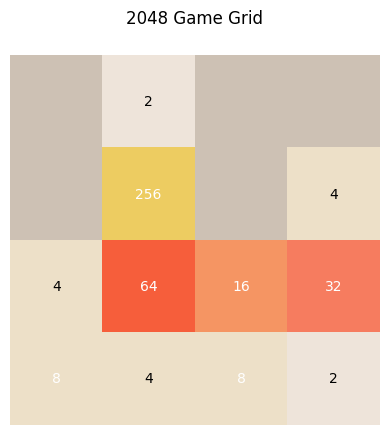

Score to beat: 6000
Dorment model score: 1456.9999999999998


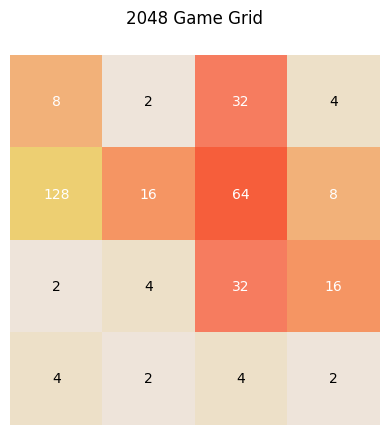

Score to beat: 6000
Dorment model score: 1124.8


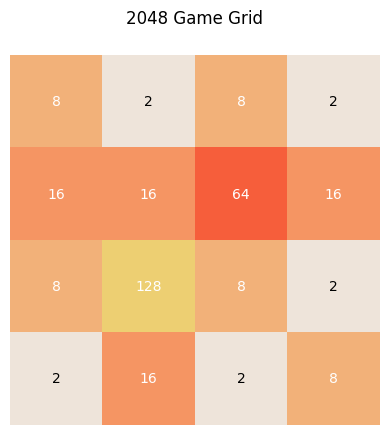

Score to beat: 6000
Dorment model score: 1133.4


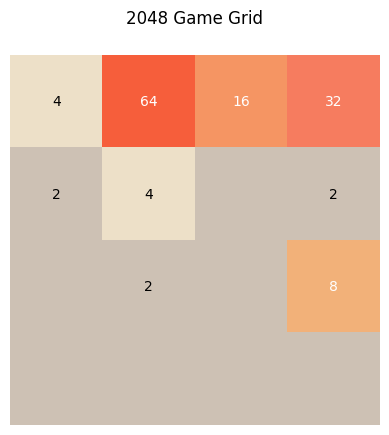

Score to beat: 6000
Dorment model score: 418.5


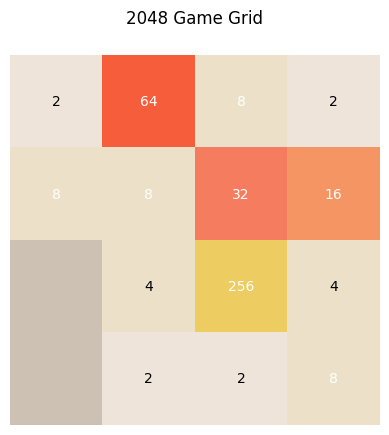

Score to beat: 6000
Dorment model score: 1439.5999999999995


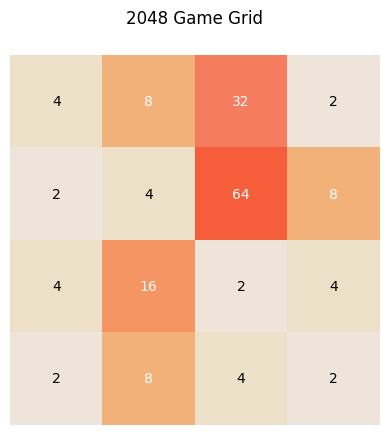

Score to beat: 6000
Dorment model score: 541.6


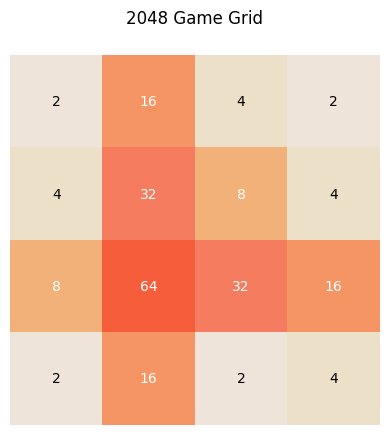

Score to beat: 6000
Dorment model score: 710.7


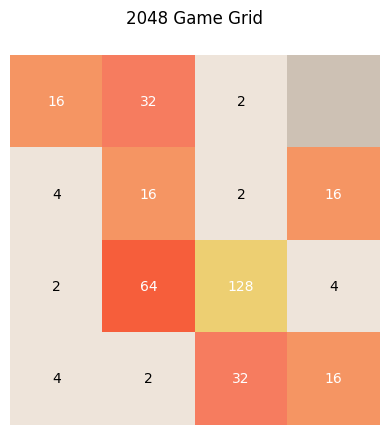

Score to beat: 6000
Dorment model score: 1194.8999999999999


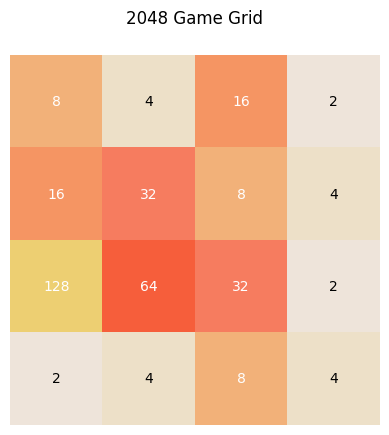

Score to beat: 6000
Dorment model score: 1114.4


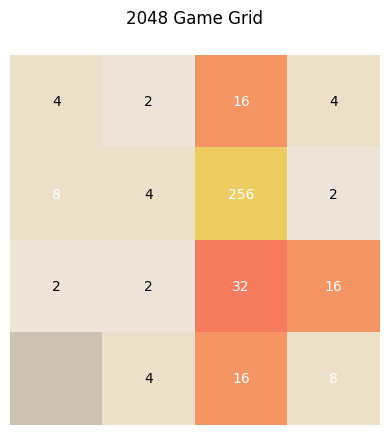

Score to beat: 6000
Dorment model score: 1391.6999999999996


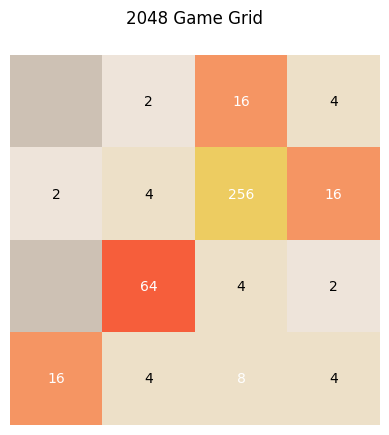

Score to beat: 6000
Dorment model score: 1479.3999999999999


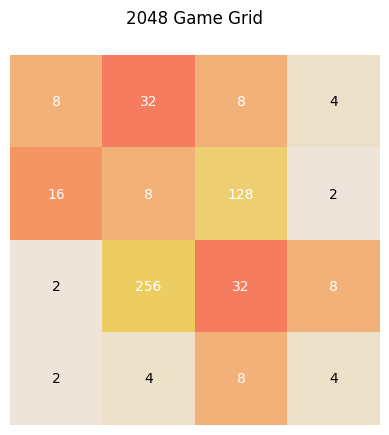

Score to beat: 6000
Dorment model score: 2009.3999999999996


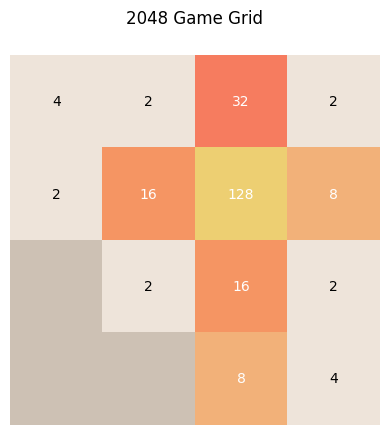

Score to beat: 6000
Dorment model score: 792.4


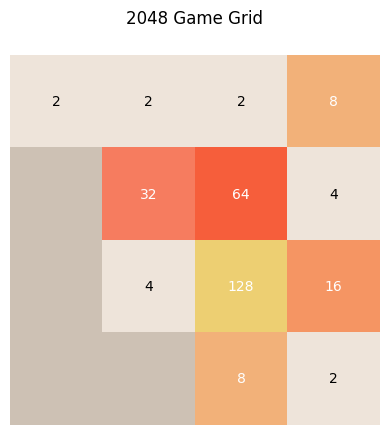

Score to beat: 6000
Dorment model score: 1029.7


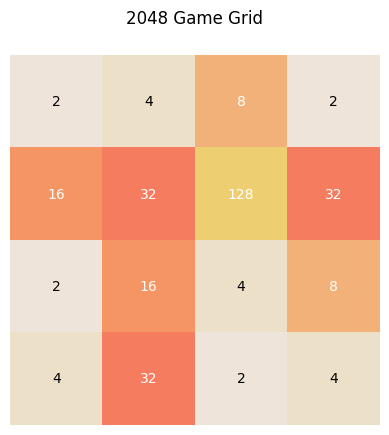

Score to beat: 6000
Dorment model score: 1021.6999999999998


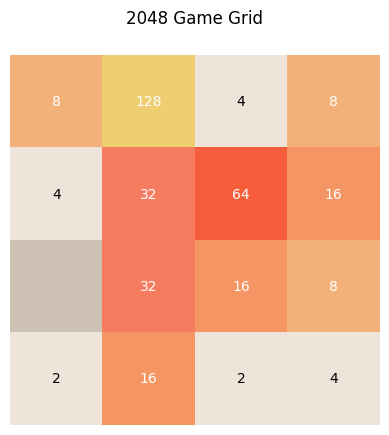

Score to beat: 6000
Dorment model score: 1249.6


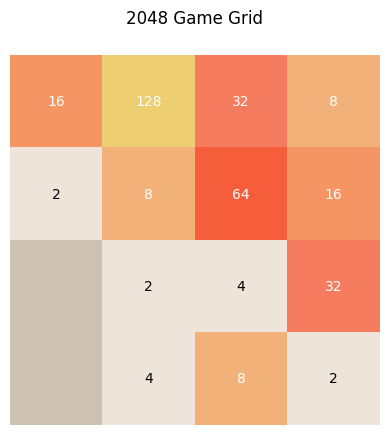

Score to beat: 6000
Dorment model score: 1157.2


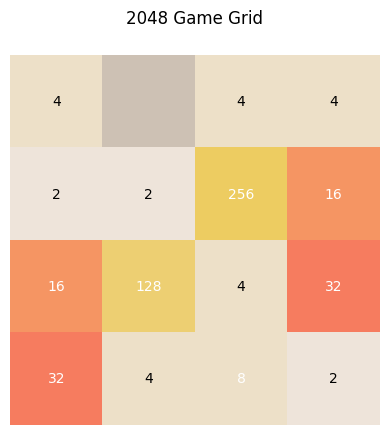

Score to beat: 6000
Dorment model score: 1954.8999999999996


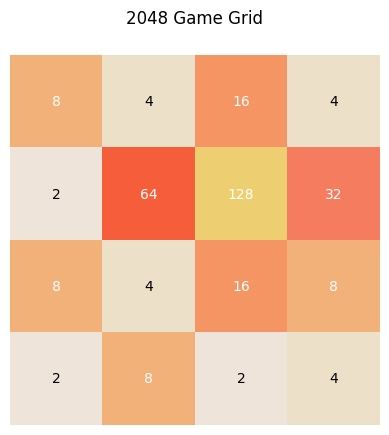

Score to beat: 6000
Dorment model score: 1072.8999999999999


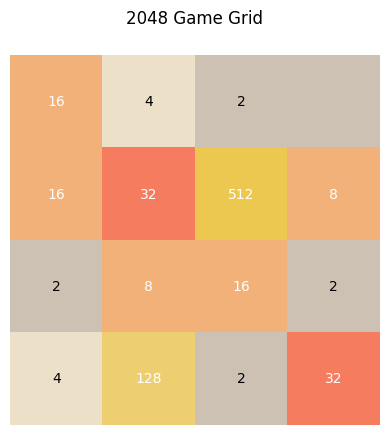

Score to beat: 6000
Dorment model score: 3193.8999999999996


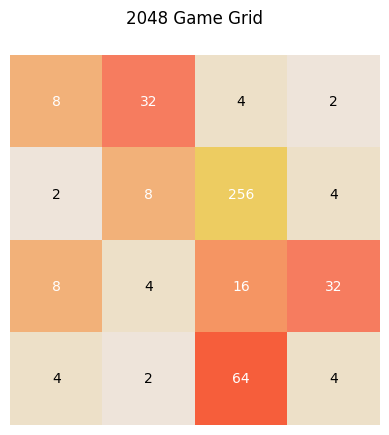

Score to beat: 6000
Dorment model score: 1640.3999999999996


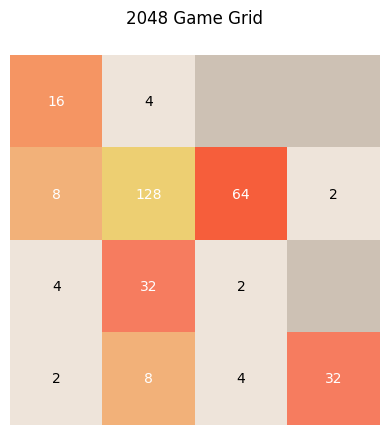

Score to beat: 6000
Dorment model score: 1137.9


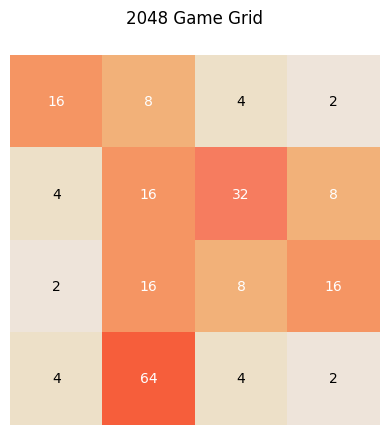

Score to beat: 6000
Dorment model score: 675.9
TARGET UPDATED


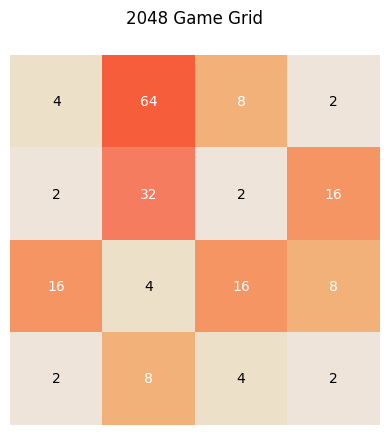

Score to beat: 6000
Dorment model score: 622.1


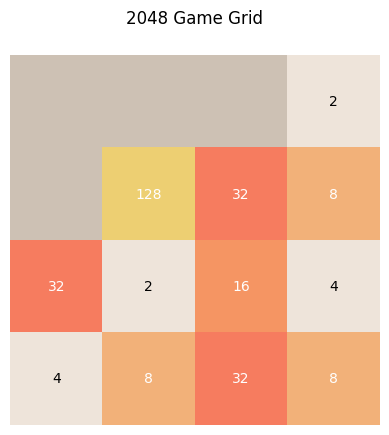

Score to beat: 6000
Dorment model score: 1083.1


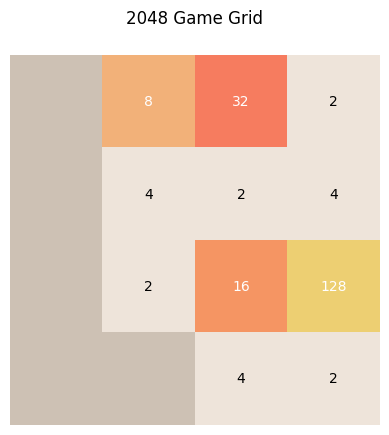

Score to beat: 6000
Dorment model score: 684.9


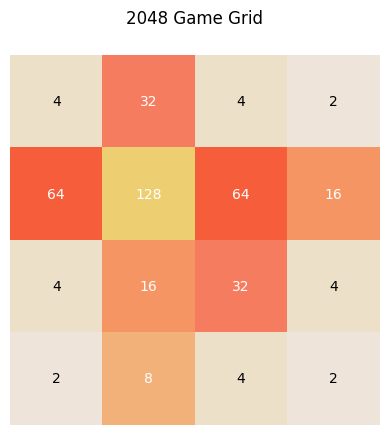

Score to beat: 6000
Dorment model score: 1531.6999999999996


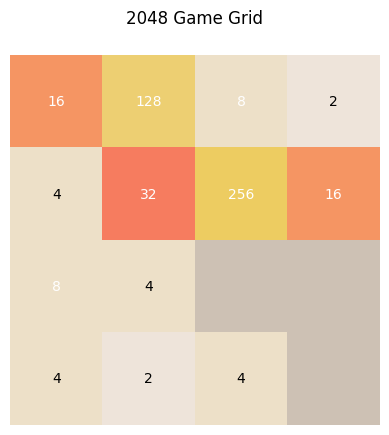

Score to beat: 6000
Dorment model score: 1877.4999999999998


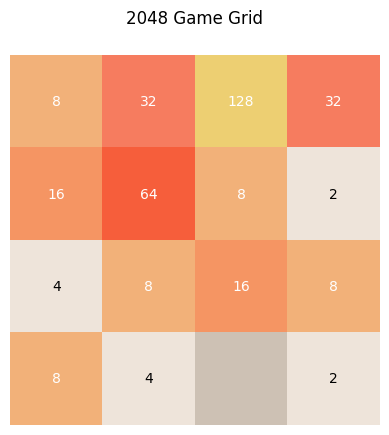

Score to beat: 6000
Dorment model score: 1205.5999999999997


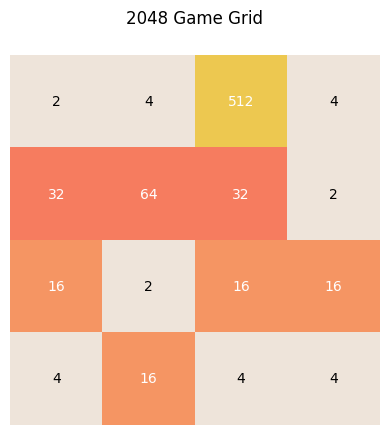

Score to beat: 6000
Dorment model score: 2855.8999999999996


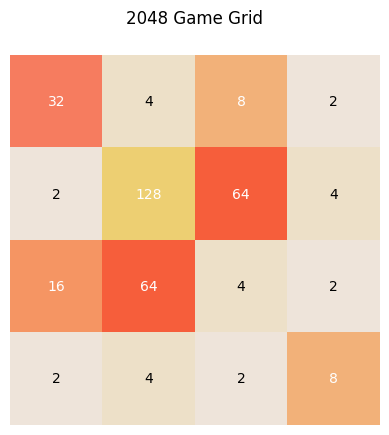

Score to beat: 6000
Dorment model score: 1329.8999999999999


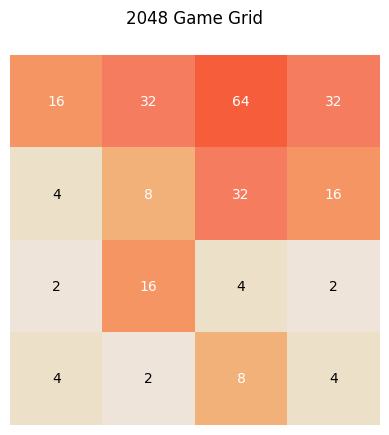

Score to beat: 6000
Dorment model score: 832.8999999999999


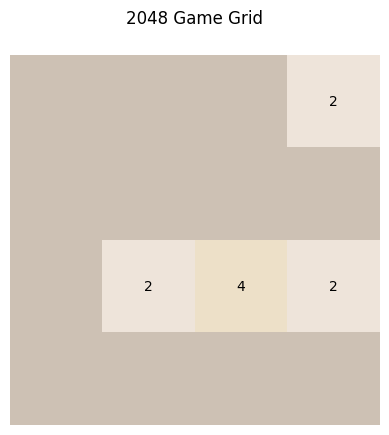

Score to beat: 6000
Dorment model score: -27.1


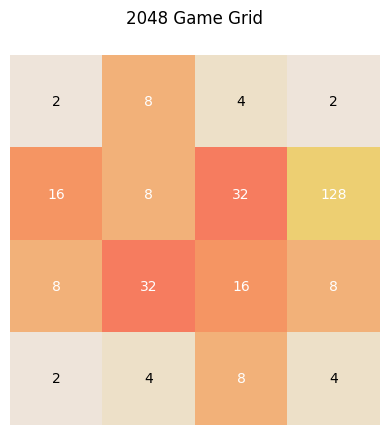

Score to beat: 6000
Dorment model score: 974.4


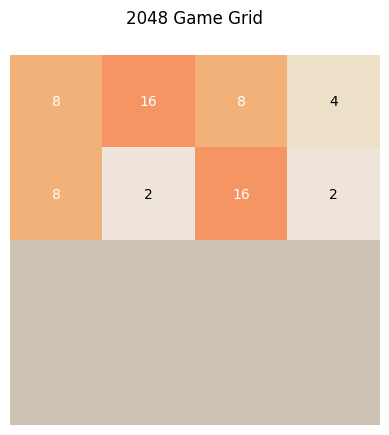

Score to beat: 6000
Dorment model score: 170.1


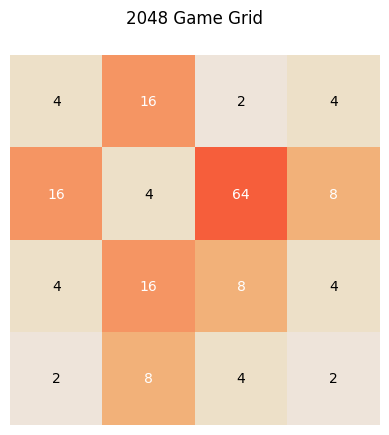

Score to beat: 6000
Dorment model score: 553.6999999999999


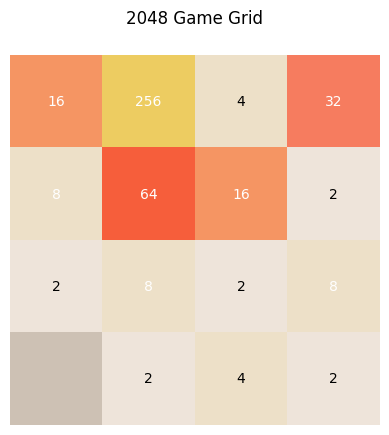

Score to beat: 6000
Dorment model score: 1606.3999999999999


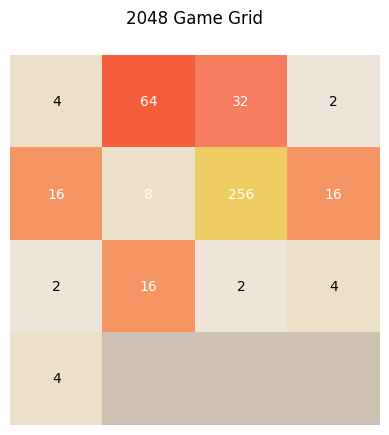

Score to beat: 6000
Dorment model score: 1562.7999999999995


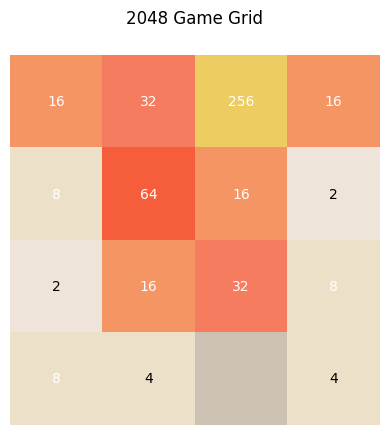

Score to beat: 6000
Dorment model score: 1841.4


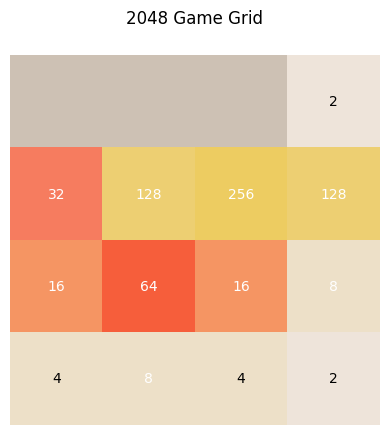

Score to beat: 6000
Dorment model score: 2876.8000000000006


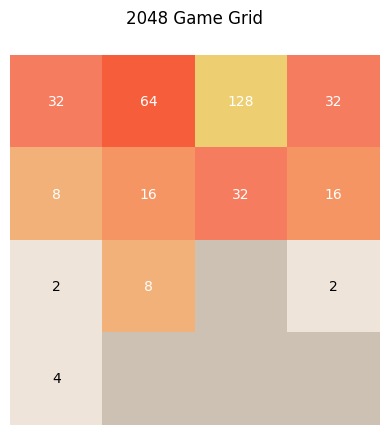

Score to beat: 6000
Dorment model score: 1292.0999999999997


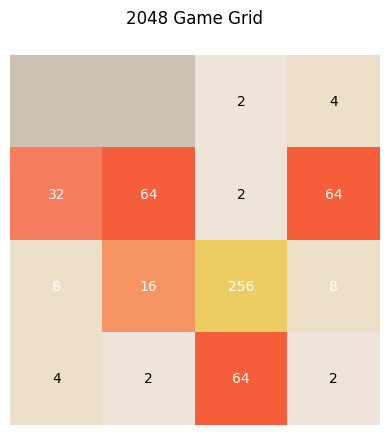

Score to beat: 6000
Dorment model score: 2250.8


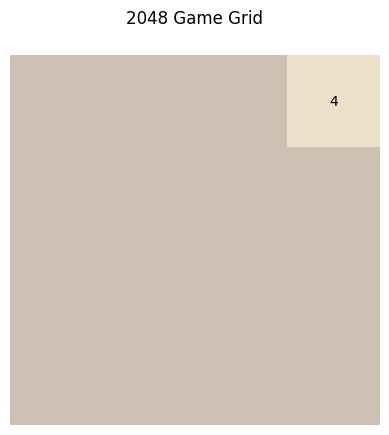

Score to beat: 6000
Dorment model score: -45


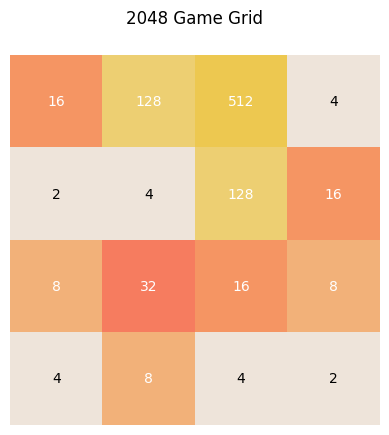

Score to beat: 6000
Dorment model score: 3562.9


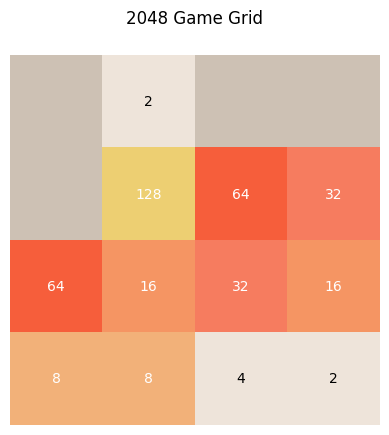

Score to beat: 6000
Dorment model score: 1479.9999999999998


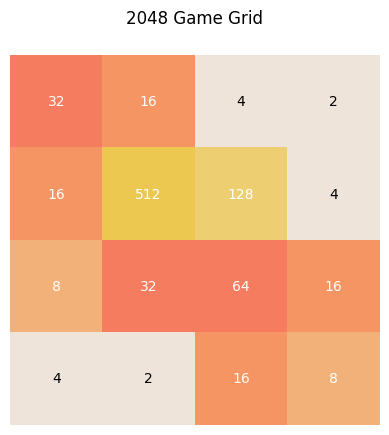

Score to beat: 6000
Dorment model score: 3582.6000000000004


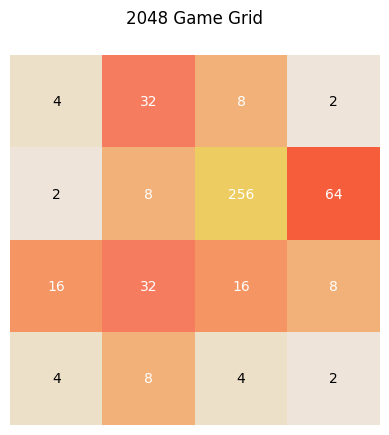

Score to beat: 6000
Dorment model score: 1926.1


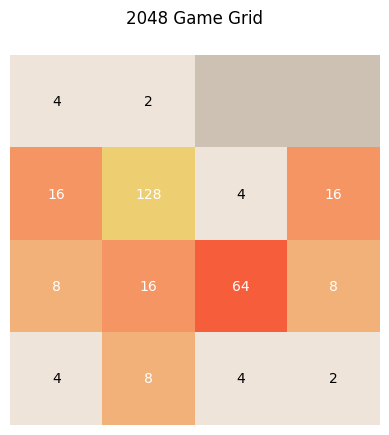

Score to beat: 6000
Dorment model score: 1111.5


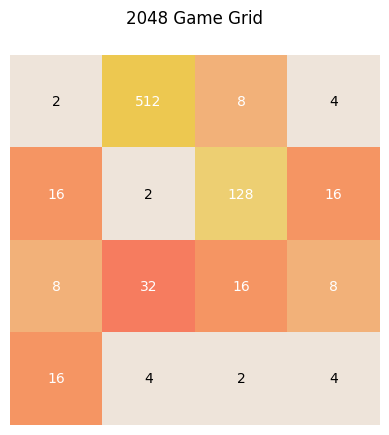

Score to beat: 6000
Dorment model score: 3282.900000000001


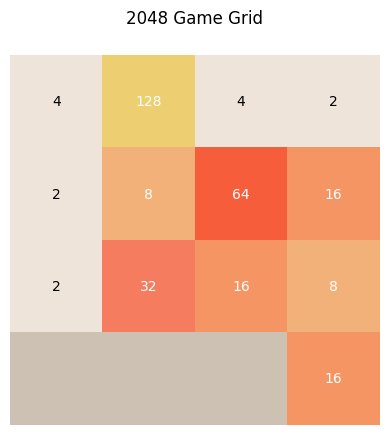

Score to beat: 6000
Dorment model score: 1111.6999999999996


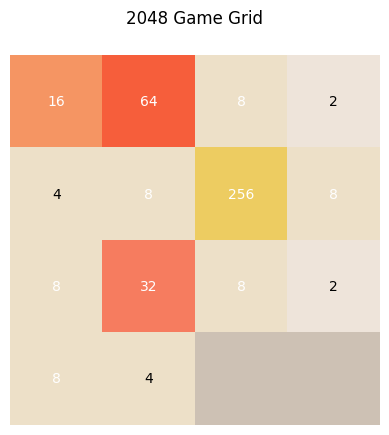

Score to beat: 6000
Dorment model score: 1682.0999999999997


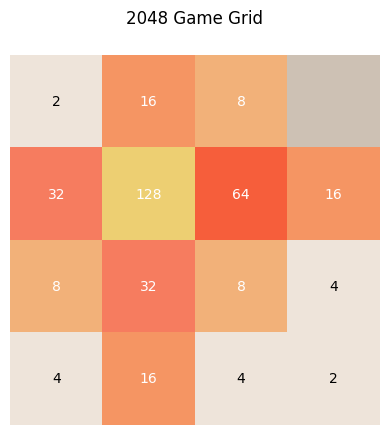

Score to beat: 6000
Dorment model score: 1414.9999999999998


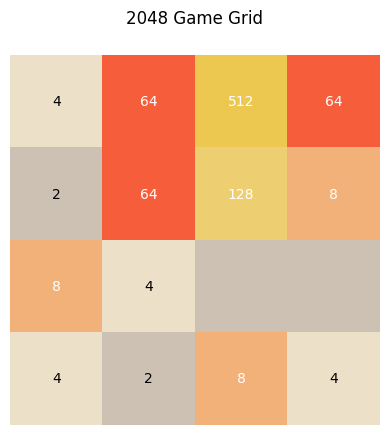

Score to beat: 6000
Dorment model score: 3627.0000000000014


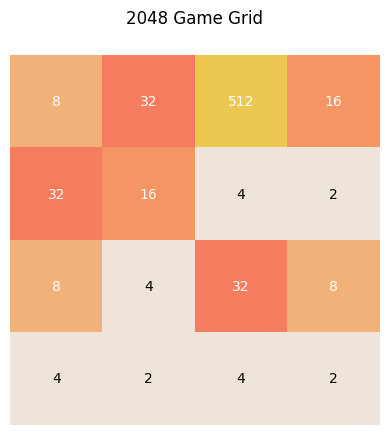

Score to beat: 6000
Dorment model score: 2762.8999999999996


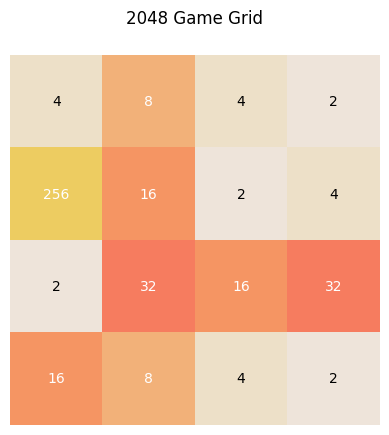

Score to beat: 6000
Dorment model score: 1615.1999999999996


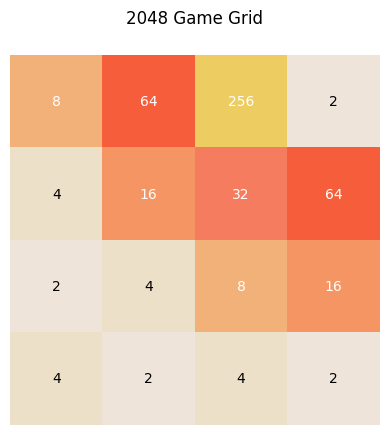

Score to beat: 6000
Dorment model score: 1863.0


KeyboardInterrupt: 

In [9]:
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from collections import deque

# Hyperparameters
STATE_SHAPE = (4, 4, 1)  # Shape of the state
ACTION_SIZE = 4  # Number of possible actions (up, down, left, right)
REPLAY_MEMORY_SIZE = 1000000  # Number of tuples in experience replay
MIN_REPLAY_MEMORY_SIZE = 16  # Minimum number of tuples for training
MINIBATCH_SIZE = 16  # Size of minibatch used for training
DISCOUNT = 0.98  # Discount factor
UPDATE_TARGET_EVERY = 1000  # How frequently to update the target network
LEARNING_RATE = 0.0001
    
# Counter to update target model
target_update_counter = 0

action_map = {
    0: 'UP',
    1: 'DOWN',
    2: 'LEFT',
    3: 'RIGHT'
}

scores = []

# Get a minibatch of random samples from memory
def train_replay():
    if len(replay_memory) < MIN_REPLAY_MEMORY_SIZE:
        return

    minibatch = random.sample(replay_memory, MINIBATCH_SIZE)

    current_states = np.array([transition[0] for transition in minibatch])
    current_qs_list = model.predict(current_states, verbose=0)
    
    new_current_states = np.array([transition[3] for transition in minibatch])
    future_qs_list = target_model.predict(new_current_states, verbose=0)

    X = []
    y = []

    for index, (current_state, action, reward, new_current_state) in enumerate(minibatch):
        max_future_q = np.max(future_qs_list[index])
        new_q = reward + DISCOUNT * max_future_q

        current_qs = current_qs_list[index]
        current_qs[action] = new_q

        X.append(current_state)
        y.append(current_qs)

    model.fit(np.array(X), np.array(y), batch_size=MINIBATCH_SIZE, verbose=0, shuffle=True)

    global target_update_counter
    target_update_counter += 1
    if target_update_counter > UPDATE_TARGET_EVERY:
        print("TARGET UPDATED")
        target_model.set_weights(model.get_weights())
        target_update_counter = 0

def play_one_step(state, epsilon, score, model):
    original_state = np.copy(state)  # Preserve the original state for comparison

    # Decide on an action
    if np.random.random() > epsilon:
        state_tensor = tf.convert_to_tensor(state.reshape((1, 4, 4, 1)), dtype=tf.float32)
        action_probs = model(state_tensor, training=False)
        action = tf.argmax(action_probs[0]).numpy()
    else:
        action = np.random.randint(0, 4)  # Random action (explore)

    # Perform the action
    next_state, reward = move(state, action_map[action], score, steps)  # Assumes move() is adjusted to return the next state and reward
    done = True
    # If state is changed, add a random tile, else, apply a penalty
    if not np.array_equal(next_state, original_state):
        next_state = add_tile(next_state)
    else:
        reward = -5  # No change in state, apply a penalty for dormancy

    # Save the experience to replay memory
    add_to_replay_memory(original_state, action, reward, next_state)
    return next_state, reward

# Add transition to replay memory
def add_to_replay_memory(state, action, reward, next_state):
    replay_memory.append((state, action, reward, next_state))
        
model = load_model('dev_model.keras') # create_model() #

# Target Model
target_model = load_model('04_model.keras') # 

# Replay memory
replay_memory = deque(maxlen=REPLAY_MEMORY_SIZE)

# Example game loop
state = np.zeros((4, 4), dtype=int)  # Initialize your
state = add_tile(state)
done = False
score = 0
epsilon = 1.0  # Start with a high epsilon to promote exploration
epsilon_decay = 0.999  # Decay epsilon
min_epsilon = 0.01  # Minimum epsilon
steps = 0
dorment = 0
rewards = []

while not done:
    steps += 1
    new_state, reward = play_one_step(state, epsilon,score,model)
    score += reward
    if np.array_equal(state, new_state):
        dorment += 1
    state = new_state
    if dorment > 8:
        done = True
    epsilon = max(epsilon * epsilon_decay, min_epsilon)  # Decay epsilon
    if steps % 8 == 0:
        train_replay()
    if done:
        if score > high_score:
            high_score = score
            model.save('dev_model.keras')
            print(f'Score to beat: {high_score}')
            print(f'model saved, score: {high_score}')
        train_replay()
        display_grid(state)
        state = np.zeros((4, 4), dtype=int)  # Reset state to initial
        state = add_tile(state)
        scores.append(score)
        steps = 0
        print(f'Score to beat: {high_score}')
        done = False
        if high_score > 8000:
            done = True
    if dorment > 8:
        print(f'Dorment model score: {score}')
        score = 0
        dorment = 0

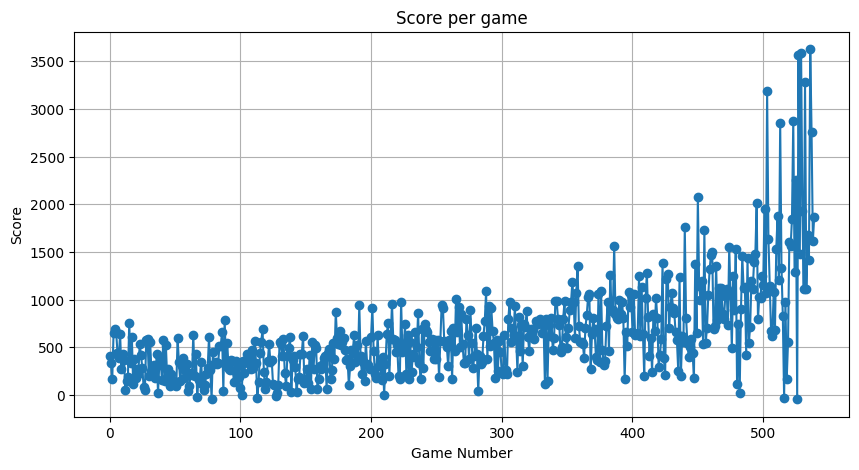

In [11]:
import matplotlib.pyplot as plt

# Data: a list of integers
data = scores
# Creating a plot
plt.figure(figsize=(10, 5))  # Optional: you can specify the size of the figure
plt.plot(data, marker='o')  # 'o' creates round markers at each data point

# Adding title and labels
plt.title('Score per game')
plt.xlabel('Game Number')
plt.ylabel('Score')

# Showing grid
plt.grid(True)

# Display the plot
plt.show()

# Make a Move

In [ ]:
predictions = model.predict(grid.reshape(1, 4, 4, 1))

action = np.argmax(predictions[0])

print(f'Predictions: {predictions}')
print(f'Action: {action_map[action]}')

new_grid, reward = move(grid, action_map[action], score, steps)
if not np.array_equal(new_grid, grid):
    new_grid = add_tile(new_grid)
grid = new_grid
display_grid(grid)
print(f'Score: {score}')

In [ ]:
print(grid)

# Save the Model

In [10]:
model.save('dev_model.keras')

# Restart Game

In [ ]:
loops += 1
grid = np.zeros((4, 4), dtype=int)  # Reset state to initial
grid = add_tile(grid)
print(f"End of game {loops}. Score: {score}")
scores.append(score)
score = 0
steps = 0
dorment = 0
done = False